# Librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from mesa.batchrunner import batch_run
from model import ClassAttendanceModel
from collections import Counter, defaultdict

# Simulaciones

Aquí se presentan las simulaciones que se utilizarán para el informe, las cuales se dividen en dos tipos:

1) Simulación general: Busca evaluar el comportamiento de los agentes en un escenario "realista", con una distribución variada de características. El objetivo es obtener una visión global del sistema y observar si emergen patrones de comportamiento relevantes.

2) Simulaciones específicas: Corresponden a escenarios controlados en los que solo se modifica una característica a la vez, manteniendo las demás constantes o balanceadas. Esto permite analizar cómo influye cada atributo particular en el comportamiento de los agentes.

En ambos casos, se realizarán 75 iteraciones por escenario, con el fin de obtener promedios representativos, ya que el modelo incorpora aleatoriedad en la asignación de atributos. Para ejecutar estas simulaciones, se utilizará la función batch_run de la librería Mesa, que permite correr múltiples ejecuciones del modelo con diferentes combinaciones de parámetros.

## Simulación General

Se comienza con una simulación general, que consiste en ejecutar el modelo utilizando los parámetros base definidos previamente, con el objetivo de analizar su comportamiento en un escenario representativo. Para ello, se emplea la función batch_run de Mesa, realizando 75 iteraciones del modelo, cada una con una duración de 25 pasos (equivalentes a 25 semanas). Esto permite obtener estadísticas promedio que reflejan el comportamiento esperado del sistema bajo condiciones generales.

In [32]:
# Definimos los parámetros del escenario general
params = {
    "num_students": 50,
    "min_credits": 21,
    "max_credits": 39,
    "prob_mandatory": [0.35],            
    "weather_type": ["random"],  
    "personal_weight": [0.5], 
    "social_weight": [0.3],
    "external_weight": [0.2],
    "network_k": [4],
    "network_p": [0.3],
}

# Ejecutamos el modelo con los parámetros definidos usando batch_run
results_general = batch_run(
    ClassAttendanceModel,
    parameters=params,
    iterations=75,         
    max_steps=25,
    data_collection_period=1,  
    number_processes=1,        
    display_progress=True
)

# Convertimos a dataframe para análisis
general = pd.DataFrame(results_general)
general.head()

  0%|          | 0/75 [00:00<?, ?it/s]

RunId  iteration  Step  num_students  min_credits  max_credits  \
0      0          0     0            50           21           39   
1      0          0     0            50           21           39   
2      0          0     0            50           21           39   
3      0          0     0            50           21           39   
4      0          0     0            50           21           39   

   prob_mandatory weather_type  personal_weight  social_weight  ...  \
0            0.35       random              0.5            0.3  ...   
1            0.35       random              0.5            0.3  ...   
2            0.35       random              0.5            0.3  ...   
3            0.35       random              0.5            0.3  ...   
4            0.35       random              0.5            0.3  ...   

   network_p  Attendance Rate  Attendance  Reasons Count  \
0        0.3              1.0          50             {}   
1        0.3              1.0          50             {}   
2        0.3              1.0          50             {}   
3        0.3              1.0          50             {}   
4        0.3              1.0          50             {}   

   Reasons Effect Count Motivation Weather  AgentID Attends Class  \
0                    {}   0.827643  random        1          True   
1                    {}   0.827643  random        2          True   
2                    {}   0.827643  random        3          True   
3                    {}   0.827643  random        4          True   
4                    {}   0.827643  random        5          True   

                                           Week Data  
0  [{'week': 1, 'days': [{'day': 'mon', 'attended...  
1  [{'week': 1, 'days': [{'day': 'mon', 'attended...  
2  [{'week': 1, 'days': [{'day': 'mon', 'attended...  
3  [{'week': 1, 'days': [{'day': 'mon', 'attended...  
4  [{'week': 1, 'days': [{'day': 'mon', 'attended...  

[5 rows x 22 columns]

In [33]:
# Función auxiliar
def promediar_o_cero(lista):
    return np.mean(lista) if lista else 0

def procesar_general(general):
    # Tomamos el último estado de cada agente
    general_last_step = general.groupby(["RunId", "iteration", "AgentID"]).tail(1).reset_index(drop=True)

    resultados = {
        "motivations": [],
        "attendances": [],
        "attendance_mandatory": [],
        "attendance_elective": [],
        "attendance_percentage": [],
        "attendance_percentage_mandatory": [],
        "attendance_percentage_elective": [],
        "total_credits": [],
        "total_mandatory": [],
        "total_elective": [],
        "all_reasons": [],
        "all_reasons_effect": []
    }

    # Procesamos por corrida (RunId, iteration)
    for (run, it), grupo in general_last_step.groupby(["RunId", "iteration"]):
        motivaciones, asistencias = [], []
        mandatorias, electivas = [], []
        perc_tot, perc_mand, perc_elec = [], [], []
        creditos, mand_count, elec_count = [], [], []

        razones = []
        razones_effect = []

        for _, row in grupo.iterrows():
            week_data = row["Week Data"]
            if not week_data:
                continue

            w_mot, w_att, w_mand, w_elec = [], [], [], []
            w_perc, w_perc_mand, w_perc_elec = [], [], []

            reasons_student = defaultdict(int)
            reasons_effect_student = defaultdict(int)
            total_missed = 0

            for week in week_data:
                mot_day, att_day, mand_day, elec_day = [], [], [], []
                possible = attended = 0
                possible_mand = attended_mand = 0
                possible_elec = attended_elec = 0

                for day in week["days"]:
                    # Créditos solo en primer lunes
                    if week["week"] == 1 and day["day"] == "mon":
                        cursos = day.get("courses", [])
                        creditos.append(sum(c.credits for c in cursos))
                        mand_count.append(sum(1 for c in cursos if c.is_mandatory))
                        elec_count.append(sum(1 for c in cursos if not c.is_mandatory))

                    mot_day.append(day["motivation"])
                    att_day.append(day["attended"])

                    if not day["attended"] and day["absence_reason"] != "No tiene clases hoy":
                        reasons_student[day["absence_reason"]] += 1
                        reasons_effect_student[day["main_factor"]] += 1
                        total_missed += 1

                    for course in day.get("courses", []):
                        for session in course.sessions:
                            if session.day == day["day"]:
                                possible += 1
                                if course.is_mandatory:
                                    possible_mand += 1
                                    if day["attended"]:
                                        mand_day.append(True)
                                        attended_mand += 1
                                        attended += 1
                                else:
                                    possible_elec += 1
                                    if day["attended"]:
                                        elec_day.append(True)
                                        attended_elec += 1
                                        attended += 1

                # Agregar promedios de la semana
                w_mot.append(promediar_o_cero(mot_day))
                w_att.append(promediar_o_cero(att_day))
                w_mand.append(promediar_o_cero(mand_day))
                w_elec.append(promediar_o_cero(elec_day))
                w_perc.append(attended / possible if possible else 0)
                w_perc_mand.append(attended_mand / possible_mand if possible_mand else 0)
                w_perc_elec.append(attended_elec / possible_elec if possible_elec else 0)

            # Promedios por agente
            motivaciones.append(promediar_o_cero(w_mot))
            asistencias.append(promediar_o_cero(w_att))
            mandatorias.append(promediar_o_cero(w_mand))
            electivas.append(promediar_o_cero(w_elec))
            perc_tot.append(promediar_o_cero(w_perc))
            perc_mand.append(promediar_o_cero(w_perc_mand))
            perc_elec.append(promediar_o_cero(w_perc_elec))

            if total_missed:
                razones.append({r: c / total_missed for r, c in reasons_student.items()})
                razones_effect.append({r: c / total_missed for r, c in reasons_effect_student.items()})

        # Guardar resultados promediados de la iteración
        resultados["motivations"].append(promediar_o_cero(motivaciones))
        resultados["attendances"].append(promediar_o_cero(asistencias))
        resultados["attendance_mandatory"].append(promediar_o_cero(mandatorias))
        resultados["attendance_elective"].append(promediar_o_cero(electivas))
        resultados["attendance_percentage"].append(promediar_o_cero(perc_tot))
        resultados["attendance_percentage_mandatory"].append(promediar_o_cero(perc_mand))
        resultados["attendance_percentage_elective"].append(promediar_o_cero(perc_elec))
        resultados["total_credits"].append(promediar_o_cero(creditos))
        resultados["total_mandatory"].append(promediar_o_cero(mand_count))
        resultados["total_elective"].append(promediar_o_cero(elec_count))

        # Promedio de razones (si existen)
        if razones:
            all_keys = set().union(*razones)
            resultados["all_reasons"].append({k: np.mean([r.get(k, 0) for r in razones]) for k in all_keys})
        else:
            resultados["all_reasons"].append({})

        if razones_effect:
            all_keys_eff = set().union(*razones_effect)
            resultados["all_reasons_effect"].append({k: np.mean([r.get(k, 0) for r in razones_effect]) for k in all_keys_eff})
        else:
            resultados["all_reasons_effect"].append({})

    return resultados


In [34]:
resultados = procesar_general(general)

In [35]:
# Creamos un DataFrame con los resultados procesados
summary_df = pd.DataFrame({
    "Motivación promedio": resultados["motivations"],
    "Asistencia promedio": resultados["attendances"],
    "Asistencia obligatoria": resultados["attendance_mandatory"],
    "Asistencia no obligatoria": resultados["attendance_elective"],
    "% Asistencia total": resultados["attendance_percentage"],
    "% Asistencia obligatoria": resultados["attendance_percentage_mandatory"],
    "% Asistencia no obligatoria": resultados["attendance_percentage_elective"],
    "Créditos promedio": resultados["total_credits"],
    "Ramos obligatorios": resultados["total_mandatory"],
    "Ramos no obligatorios": resultados["total_elective"],
    "Razones": resultados["all_reasons"],
    "Razones dominantes": resultados["all_reasons_effect"]
})


In [36]:
summary_df

Motivación promedio  Asistencia promedio  Asistencia obligatoria  \
0              0.365607             0.531077                0.880769   
1              0.333208             0.492462                0.840769   
2              0.314038             0.466308                0.806154   
3              0.299732             0.438769                0.763846   
4              0.324857             0.525385                0.871538   
..                  ...                  ...                     ...   
70             0.308618             0.485846                0.805385   
71             0.350982             0.521231                0.843077   
72             0.289436             0.473692                0.816154   
73             0.356628             0.491385                0.833846   
74             0.343406             0.533077                0.876154   

    Asistencia no obligatoria  % Asistencia total  % Asistencia obligatoria  \
0                    0.810000            0.661702                  0.834745   
1                    0.786923            0.578885                  0.807099   
2                    0.783846            0.560529                  0.770843   
3                    0.720000            0.530288                  0.737938   
4                    0.798462            0.631931                  0.828604   
..                        ...                 ...                       ...   
70                   0.761538            0.593236                  0.777276   
71                   0.822308            0.632025                  0.813841   
72                   0.755385            0.583627                  0.790521   
73                   0.814615            0.620492                  0.798132   
74                   0.830000            0.638716                  0.846412   

    % Asistencia no obligatoria  Créditos promedio  Ramos obligatorios  \
0                      0.522722              31.68                1.86   
1                      0.475339              33.36                1.90   
2                      0.471210              32.16                1.56   
3                      0.424725              31.68                1.62   
4                      0.471290              33.24                2.10   
..                          ...                ...                 ...   
70                     0.500663              32.52                1.62   
71                     0.537748              34.14                1.80   
72                     0.476770              33.00                1.72   
73                     0.549228              34.14                1.62   
74                     0.514289              33.12                1.92   

    Ramos no obligatorios                                            Razones  \
0                    2.84  {'Desgaste': 0.011111111111111112, 'Desmotivac...   
1                    3.32  {'Desgaste': 0.017747863247863246, 'Desmotivac...   
2                    3.30  {'Desgaste': 0.015578947368421052, 'Desmotivac...   
3                    3.20  {'Desgaste': 0.01612121212121212, 'Desmotivaci...   
4                    3.22  {'Desgaste': 0.009914529914529915, 'Desmotivac...   
..                    ...                                                ...   
70                   3.18  {'Desgaste': 0.013611111111111112, 'Desmotivac...   
71                   3.36  {'Desgaste': 0.010993006993006992, 'Desmotivac...   
72                   3.24  {'Desgaste': 0.007948717948717949, 'Desmotivac...   
73                   3.48  {'Desgaste': 0.009722222222222222, 'Desmotivac...   
74                   2.96  {'Desgaste': 0.009555555555555557, 'Desmotivac...   

                                   Razones dominantes  
0   {'Externo': 0.9744683675182825, 'Personal': 0....  
1   {'Externo': 0.9664543683809735, 'Personal': 0....  
2   {'Externo': 0.9554431450673654, 'Personal': 0....  
3   {'Externo': 0.9595648517612129, 'Personal': 0....  
4   {'Externo': 0.9722500411648923, 'Personal': 0....  
..  

Ahora que se tienen las estadísticas de la simulación, se gráficara para poder revisar y analizar de mejor manera el comportamiento que tuvo cada iteración.

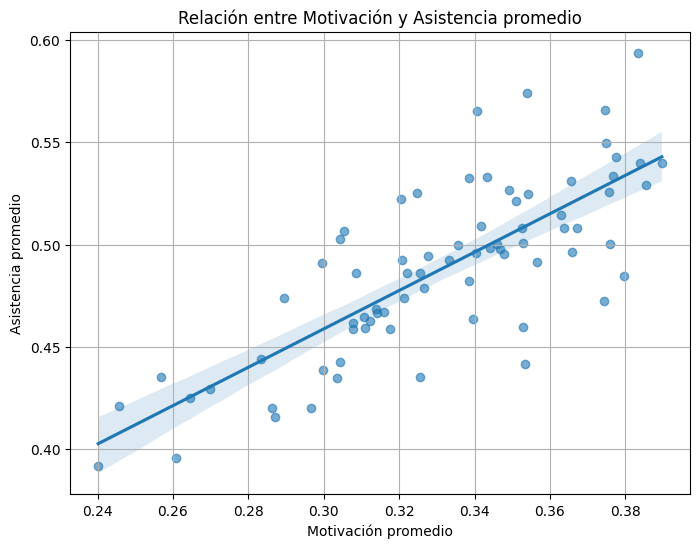

In [37]:
# Visualización de la relación entre motivación y asistencia promedio agregando una línea de regresión
plt.figure(figsize=(8, 6))
sns.regplot(data=summary_df, x="Motivación promedio", y="Asistencia promedio", scatter_kws={'alpha':0.6}) 
plt.title("Relación entre Motivación y Asistencia promedio")
plt.xlabel("Motivación promedio")
plt.ylabel("Asistencia promedio")
plt.grid(True)
plt.show()

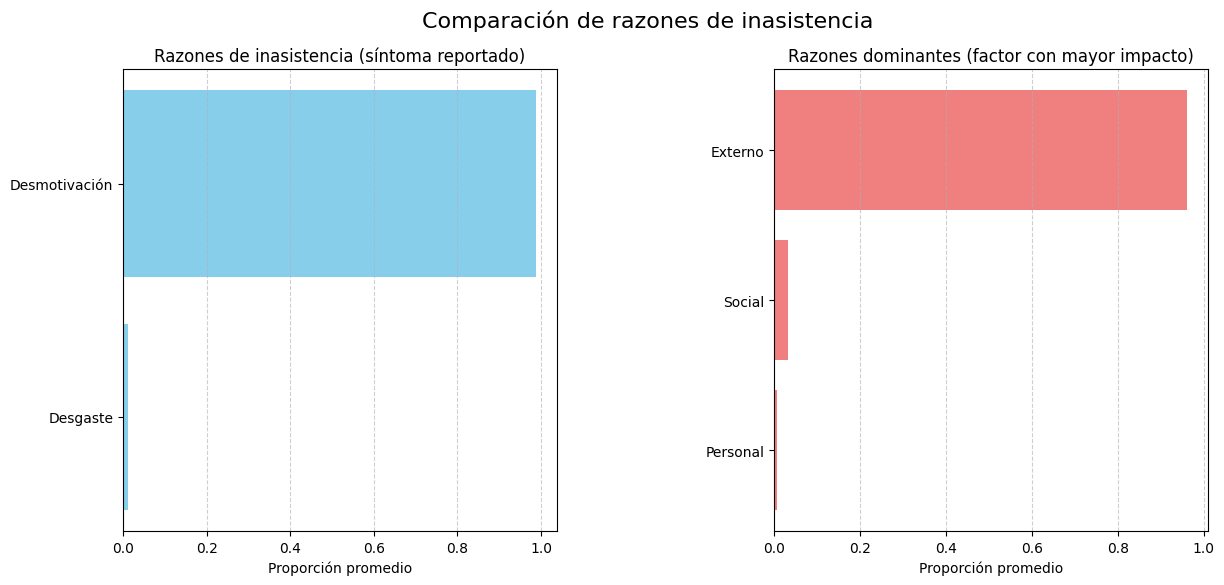

In [38]:
# Esto crea un DataFrame donde cada columna es una razón, y cada fila una iteración
df_sintomas = pd.DataFrame(summary_df["Razones"].tolist()).fillna(0)

# Calcula el promedio por razón
promedios_por_razon = df_sintomas.mean().sort_values(ascending=True)

# Esto crea un DataFrame donde cada columna es una razón dominante, y cada fila una iteración
df_dominantes = pd.DataFrame(summary_df["Razones dominantes"].tolist()).fillna(0)

# Calcula el promedio por razón dominante
promedios_por_razon_dominante = df_dominantes.mean().sort_values(ascending=True)

# Gráfico
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.subplots_adjust(wspace=0.5)

# Gráfico 1: Razones sintomáticas
axes[0].barh(promedios_por_razon.index, promedios_por_razon.values, color="skyblue")
axes[0].set_title("Razones de inasistencia (síntoma reportado)")
axes[0].set_xlabel("Proporción promedio")
axes[0].grid(True, axis='x', linestyle='--', alpha=0.6)

# Gráfico 2: Razón dominante (efecto con mayor peso)
axes[1].barh(promedios_por_razon_dominante.index, promedios_por_razon_dominante.values, color="lightcoral")
axes[1].set_title("Razones dominantes (factor con mayor impacto)")
axes[1].set_xlabel("Proporción promedio")
axes[1].grid(True, axis='x', linestyle='--', alpha=0.6)

plt.suptitle("Comparación de razones de inasistencia", fontsize=16)
plt.show()



C:\Users\thoma\AppData\Local\Temp\ipykernel_13144\419322406.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Tipo", y="Valor", palette="pastel")


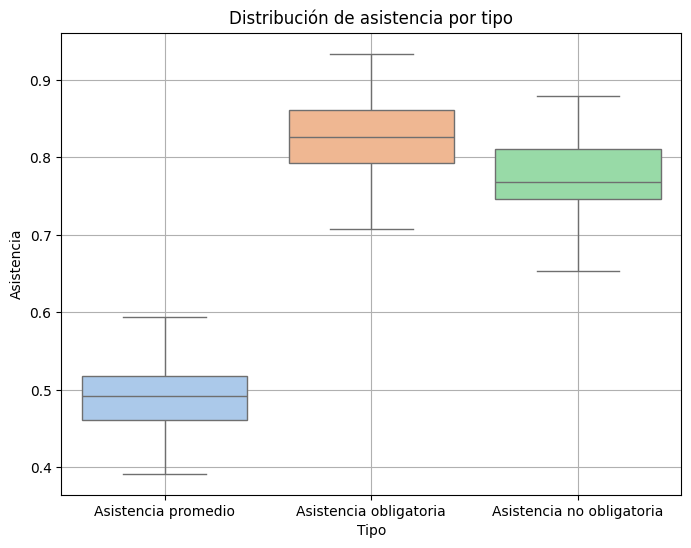

In [39]:
# Visualización de la distribución de porcentajes de asistencia
df_melted = summary_df[["Asistencia promedio", "Asistencia obligatoria", "Asistencia no obligatoria"]].melt(var_name="Tipo", value_name="Valor")

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_melted, x="Tipo", y="Valor", palette="pastel")
plt.title("Distribución de asistencia por tipo")
plt.ylabel("Asistencia")
plt.grid(True)
plt.show()


C:\Users\thoma\AppData\Local\Temp\ipykernel_13144\403324592.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_percent, x="Tipo", y="Porcentaje", palette="pastel")


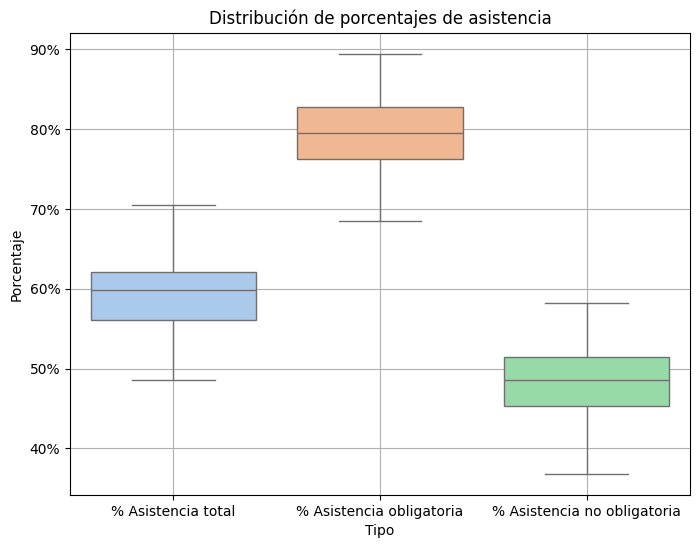

In [40]:
# Visualización de la distribución de porcentajes de asistencia
df_percent = summary_df[["% Asistencia total", "% Asistencia obligatoria", "% Asistencia no obligatoria"]].melt(var_name="Tipo", value_name="Porcentaje")

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_percent, x="Tipo", y="Porcentaje", palette="pastel")
plt.title("Distribución de porcentajes de asistencia")
plt.ylabel("Porcentaje")
plt.grid(True)

# Se pasa el eje y a formato de porcentaje
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()


C:\Users\thoma\AppData\Local\Temp\ipykernel_13144\4120580626.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ramos, x="Tipo", y="Cantidad", palette="coolwarm")


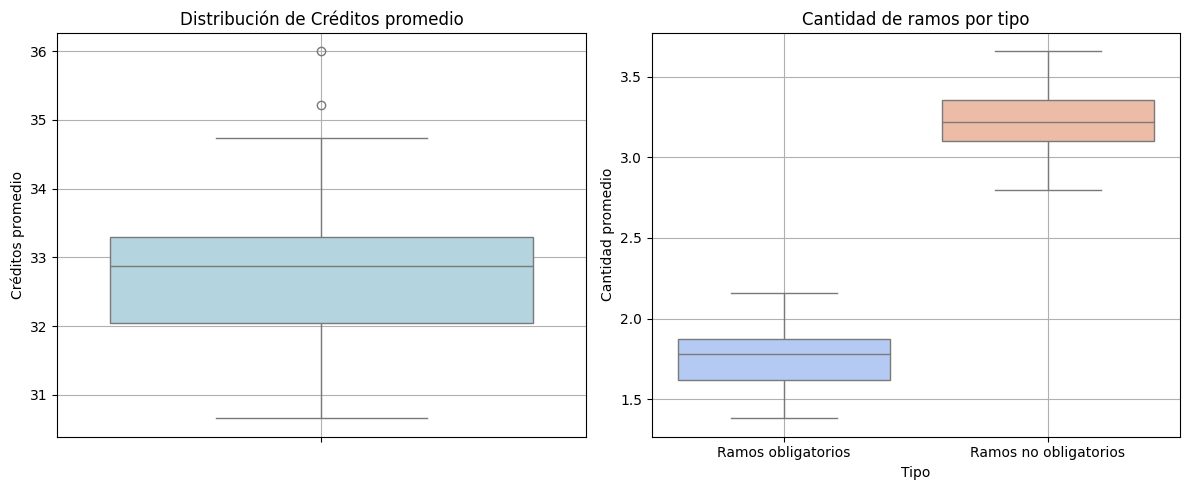

In [41]:
plt.figure(figsize=(12, 5))

# Créditos
plt.subplot(1, 2, 1)
sns.boxplot(data=summary_df, y="Créditos promedio", color="lightblue")
plt.title("Distribución de Créditos promedio")
plt.grid(True)

# Ramos obligatorios vs electivos
df_ramos = summary_df[["Ramos obligatorios", "Ramos no obligatorios"]].melt(var_name="Tipo", value_name="Cantidad")
plt.subplot(1, 2, 2)
sns.boxplot(data=df_ramos, x="Tipo", y="Cantidad", palette="coolwarm")
plt.ylabel("Cantidad promedio")
plt.title("Cantidad de ramos por tipo")
plt.grid(True)

plt.tight_layout()
plt.show()


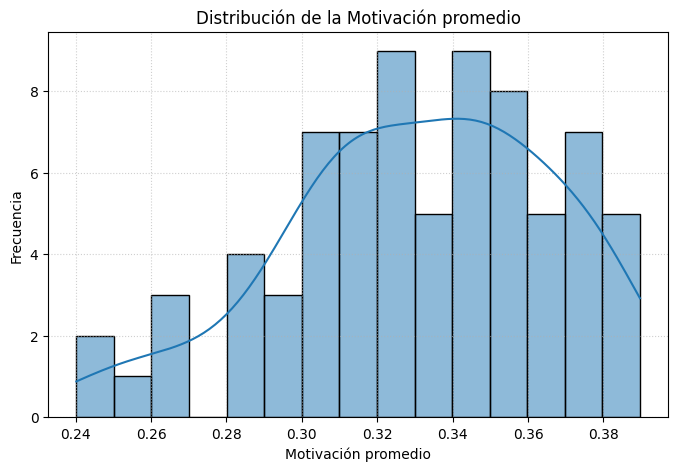

In [42]:
# Visualización de la distribución de la motivación promedio
plt.figure(figsize=(8, 5))
sns.histplot(summary_df["Motivación promedio"], bins=15, kde=True)
plt.title("Distribución de la Motivación promedio")
plt.xlabel("Motivación promedio")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()


## Simulación específica

En esta sección se evaluarán distintos escenarios para analizar el comportamiento de los estudiantes al modificar de manera controlada un único parámetro del modelo, manteniendo los demás constantes. Esto permite aislar y observar el efecto de cada variable en los resultados.

Los escenarios considerados son los siguientes:

1) Créditos: El escenario base corresponde a un rango entre 21 y 39 créditos. Se experimentará con valores fijos y otros rangos alternativos.
2) Clima: El estado base corresponde a random. Se analizará el efecto de fijar un clima específico (solo rainy o solo sunny), así como las diferencias entre ellos.
3) Obligación: Actualmente, la probabilidad de que un curso sea obligatorio es de un 60 %. Se probarán variaciones con valores más altos (90 %), más bajos (30 %) y extremos (100 % y 0 %).
4) Peso motivacional: En el escenario base los factores personal, social y externo tienen pesos de 0.5, 0.3 y 0.2, respectivamente. Se realizarán pruebas modificando estas proporciones e incluso priorizando únicamente uno de los factores.
5) Red social: El escenario base se configura con k = 4 y p = 0.3. Se explorarán variaciones aumentando o reduciendo el nivel de conexiones entre estudiantes.

En todos los casos se utilizarán las mismas métricas definidas en la simulación general: motivación promedio, asistencia total, asistencia obligatoria y electiva, porcentaje de asistencia, créditos inscritos, cantidad de ramos y principales razones de inasistencia. Además, se empleará un orbit chart como herramienta adicional para monitorear y comparar el comportamiento de los distintos escenarios.

### Funciones a utilizar

Se define la función que se usará para cada escenario, donde solo se cambia el params que recibe

In [6]:
def ejecutar_escenario(name, params, step=25, iteraciones=75):
    print(f"Ejecutando escenario: {name}")
    results = batch_run(
        ClassAttendanceModel,
        parameters=params,
        iterations=iteraciones,
        max_steps=step,
        data_collection_period=1,
        number_processes=1,
        display_progress=True
    )
    df = pd.DataFrame(results)
    df["Escenario"] = name
    return df


Además, de funciones que nos ayudarán a procesar los datos para obtener las diferentes métricas que se requieren y para formar los gráficos

In [8]:
def procesar_resultados(df):
    resultados = []

    # Último paso de cada agente en cada iteración
    df_last = (
        df.groupby(["Escenario", "RunId", "iteration", "AgentID"])
          .tail(1)
          .reset_index(drop=True)
    )

    # Procesar por escenario y run
    for (escenario, run), grupo in df_last.groupby(["Escenario", "RunId"]):
        motivations_student = []
        attendances_student = []
        attendance_mandatory_student = []
        attendance_elective_student = []
        attendance_percentage_student = []
        attendance_percentage_mandatory_student = []
        attendance_percentage_elective_student = []
        total_credits_student = []
        total_mandatory_student = []
        total_elective_student = []
        all_reasons_student = []
        all_reasons_effect_student = []

        # Iterar agentes
        for _, row in grupo.iterrows():
            week_data = row["Week Data"]
            if not week_data:
                continue

            # Acumuladores por agente
            motivations_sum, motivations_count = 0, 0
            attendances_sum, attendances_count = 0, 0
            att_mand_sum, att_mand_count = 0, 0
            att_elec_sum, att_elec_count = 0, 0
            att_perc_sum, att_perc_count = 0, 0
            att_perc_mand_sum, att_perc_mand_count = 0, 0
            att_perc_elec_sum, att_perc_elec_count = 0, 0

            reasons_student = Counter()
            reasons_effect_student = Counter()
            total_missed_sessions = 0

            # Iterar semanas
            for week in week_data:
                motivations_week, attendances_week = [], []
                att_mand_week, att_elec_week = [], []

                sessions_possible = sessions_attended = 0
                sessions_possible_mand = sessions_attended_mand = 0
                sessions_possible_elec = sessions_attended_elec = 0

                for day in week["days"]:
                    # Solo una vez (primer lunes de la primera semana)
                    if week["week"] == 1 and day["day"] == "mon":
                        courses = day.get("courses", [])
                        total_credits_student.append(sum(c.credits for c in courses))
                        total_mandatory_student.append(sum(c.is_mandatory for c in courses))
                        total_elective_student.append(sum(not c.is_mandatory for c in courses))

                    motivations_week.append(day["motivation"])
                    attendances_week.append(day["attended"])

                    if not day["attended"] and day["absence_reason"] != "No tiene clases hoy":
                        reasons_student.update([day["absence_reason"]])
                        reasons_effect_student.update([day["main_factor"]])
                        total_missed_sessions += 1

                    for course in day.get("courses", []):
                        for session in course.sessions:
                            if session.day == day["day"]:
                                sessions_possible += 1
                                if course.is_mandatory:
                                    sessions_possible_mand += 1
                                    if day["attended"]:
                                        att_mand_week.append(1)
                                        sessions_attended_mand += 1
                                        sessions_attended += 1
                                else:
                                    sessions_possible_elec += 1
                                    if day["attended"]:
                                        att_elec_week.append(1)
                                        sessions_attended_elec += 1
                                        sessions_attended += 1

                # Promedios semanales → acumular
                if motivations_week:
                    motivations_sum += np.mean(motivations_week)
                    motivations_count += 1
                if attendances_week:
                    attendances_sum += np.mean(attendances_week)
                    attendances_count += 1
                if att_mand_week:
                    att_mand_sum += np.mean(att_mand_week)
                    att_mand_count += 1
                if att_elec_week:
                    att_elec_sum += np.mean(att_elec_week)
                    att_elec_count += 1
                if sessions_possible:
                    att_perc_sum += sessions_attended / sessions_possible
                    att_perc_count += 1
                if sessions_possible_mand:
                    att_perc_mand_sum += sessions_attended_mand / sessions_possible_mand
                    att_perc_mand_count += 1
                if sessions_possible_elec:
                    att_perc_elec_sum += sessions_attended_elec / sessions_possible_elec
                    att_perc_elec_count += 1

            # Guardar resultados por agente
            motivations_student.append(motivations_sum / motivations_count if motivations_count else 0)
            attendances_student.append(attendances_sum / attendances_count if attendances_count else 0)
            attendance_mandatory_student.append(att_mand_sum / att_mand_count if att_mand_count else 0)
            attendance_elective_student.append(att_elec_sum / att_elec_count if att_elec_count else 0)
            attendance_percentage_student.append(att_perc_sum / att_perc_count if att_perc_count else 0)
            attendance_percentage_mandatory_student.append(att_perc_mand_sum / att_perc_mand_count if att_perc_mand_count else 0)
            attendance_percentage_elective_student.append(att_perc_elec_sum / att_perc_elec_count if att_perc_elec_count else 0)

            if total_missed_sessions > 0:
                reasons_normalized = {r: c / total_missed_sessions for r, c in reasons_student.items()}
                reasons_effect_normalized = {r: c / total_missed_sessions for r, c in reasons_effect_student.items()}
            else:
                reasons_normalized = {}
                reasons_effect_normalized = {}

            all_reasons_student.append(reasons_normalized)
            all_reasons_effect_student.append(reasons_effect_normalized)

        # Consolidar razones
        all_possible_reasons = {r for d in all_reasons_student for r in d}
        all_possible_effects = {r for d in all_reasons_effect_student for r in d}

        reasons_mean = {
            r: np.mean([d.get(r, 0.0) for d in all_reasons_student]) for r in all_possible_reasons
        }
        reasons_effect_mean = {
            r: np.mean([d.get(r, 0.0) for d in all_reasons_effect_student]) for r in all_possible_effects
        }

        resultados.append({
            "Escenario": escenario,
            "Motivación promedio": np.mean(motivations_student),
            "Asistencia promedio": np.mean(attendances_student),
            "Asistencia obligatoria": np.mean(attendance_mandatory_student),
            "Asistencia no obligatoria": np.mean(attendance_elective_student),
            "% Asistencia total": np.mean(attendance_percentage_student),
            "% Asistencia obligatoria": np.mean(attendance_percentage_mandatory_student),
            "% Asistencia no obligatoria": np.mean(attendance_percentage_elective_student),
            "Créditos promedio": np.mean(total_credits_student),
            "Ramos obligatorios": np.mean(total_mandatory_student),
            "Ramos electivos": np.mean(total_elective_student),
            "Razones": reasons_mean,
            "Razones dominantes": reasons_effect_mean,
        })

    return pd.DataFrame(resultados)

In [ ]:
def procesar_resultados_para_orbit_chart(df):
    # Último estado de cada agente en cada corrida
    df_last = (
        df.groupby(["Escenario", "RunId", "iteration", "AgentID"])
          .tail(1)
          .reset_index(drop=True)
    )

    detalle = []
    for (escenario, run), grupo in df_last.groupby(["Escenario", "RunId"]):
        # Acumuladores por semana
        resumen_por_semana = defaultdict(lambda: {
            "mot_sum": 0, "mot_count": 0,
            "asi_sum": 0, "asi_count": 0,
            "ob_sum": 0,  "ob_count": 0,
            "no_sum": 0,  "no_count": 0,
        })

        for _, row in grupo.iterrows():
            for week in row.get("Week Data", []):
                semana = week.get("week")
                dias = week.get("days", [])
                if not dias:
                    continue

                mot_sum = asi_sum = ob_sum = no_sum = 0
                mot_count = asi_count = ob_count = no_count = 0

                for dia in dias:
                    mot = dia.get("motivation", 0)
                    mot_sum += mot
                    mot_count += 1

                    if dia.get("absence_reason") != "No tiene clases hoy":
                        asi_sum += int(dia.get("attended", False))
                        asi_count += 1

                    attended = int(dia.get("attended", False))
                    for course in dia.get("courses", []):
                        if course.is_mandatory:
                            ob_sum += attended
                            ob_count += 1
                        else:
                            no_sum += attended
                            no_count += 1

                # Acumular para esta semana en este run
                r = resumen_por_semana[semana]
                if mot_count:
                    r["mot_sum"] += mot_sum / mot_count
                    r["mot_count"] += 1
                if asi_count:
                    r["asi_sum"] += asi_sum / asi_count
                    r["asi_count"] += 1
                if ob_count:
                    r["ob_sum"] += ob_sum / ob_count
                    r["ob_count"] += 1
                if no_count:
                    r["no_sum"] += no_sum / no_count
                    r["no_count"] += 1

        # Volcar cada semana de este run
        for semana, d in sorted(resumen_por_semana.items()):
            detalle.append({
                "escenario": escenario,
                "run": run,
                "semana": semana,
                "motivacion": d["mot_sum"] / d["mot_count"] if d["mot_count"] else 0,
                "asistencia": d["asi_sum"] / d["asi_count"] if d["asi_count"] else 0,
                "% obligatoria": d["ob_sum"] / d["ob_count"] if d["ob_count"] else 0,
                "% no obligatoria": d["no_sum"] / d["no_count"] if d["no_count"] else 0,
            })

    df_detalle = pd.DataFrame(detalle)

    # DataFrame promedio por escenario y semana
    df_promedio = (
        df_detalle
        .groupby(["escenario", "semana"])
        .mean(numeric_only=True)
        .reset_index()
    )

    return df_detalle, df_promedio

### Créditos

In [10]:
# Los siguientes escenarios son para comparar diferentes configuraciones de créditos
credit_scenarios = [
    {"name": "Base",        "min_credits": 21, "max_credits": 39},
    {"name": "Carga baja",  "min_credits": 24, "max_credits": 27},
    {"name": "Carga media", "min_credits": 27, "max_credits": 33},
    {"name": "Carga alta",  "min_credits": 33, "max_credits": 39},
    {"name": "Sobrecarga",  "min_credits": 39, "max_credits": 45},
    {"name": "Fijo 24",     "min_credits": 24, "max_credits": 24},
    {"name": "Fijo 30",     "min_credits": 30, "max_credits": 30},
    {"name": "Fijo 36",     "min_credits": 36, "max_credits": 36},
]

# Definimos los parámetros base para cada escenario de créditos
dfs = []
for esc in credit_scenarios:
    base_params = {
        "num_students": 50,
        "prob_mandatory": [0.35],
        "personal_weight": [0.5],
        "social_weight": [0.3],
        "external_weight": [0.2],
        "weather_type": ["random"],
        "min_credits": [esc["min_credits"]],
        "max_credits": [esc["max_credits"]],
        "network_k": [4],
        "network_p": [0.3],
    }
    df = ejecutar_escenario(esc["name"], base_params)
    dfs.append(df)

# Concatenar todos
resultados_comparativos_creditos = pd.concat(dfs, ignore_index=True)


Ejecutando escenario: Base


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Carga baja


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Carga media


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Carga alta


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Sobrecarga


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Fijo 24


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Fijo 30


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Fijo 36


  0%|          | 0/75 [00:00<?, ?it/s]

In [11]:
resultados_comparativos_creditos.head()

RunId  iteration  Step  num_students  prob_mandatory  personal_weight  \
0      0          0     0            50            0.35              0.5   
1      0          0     0            50            0.35              0.5   
2      0          0     0            50            0.35              0.5   
3      0          0     0            50            0.35              0.5   
4      0          0     0            50            0.35              0.5   

   social_weight  external_weight weather_type  min_credits  ...  \
0            0.3              0.2       random           21  ...   
1            0.3              0.2       random           21  ...   
2            0.3              0.2       random           21  ...   
3            0.3              0.2       random           21  ...   
4            0.3              0.2       random           21  ...   

   Attendance Rate  Attendance  Reasons Count  Reasons Effect Count  \
0              1.0          50             {}                    {}   
1              1.0          50             {}                    {}   
2              1.0          50             {}                    {}   
3              1.0          50             {}                    {}   
4              1.0          50             {}                    {}   

   Motivation Weather AgentID  Attends Class  \
0    0.846041  random       1           True   
1    0.846041  random       2           True   
2    0.846041  random       3           True   
3    0.846041  random       4           True   
4    0.846041  random       5           True   

                                           Week Data  Escenario  
0  [{'week': 1, 'days': [{'day': 'mon', 'attended...       Base  
1  [{'week': 1, 'days': [{'day': 'mon', 'attended...       Base  
2  [{'week': 1, 'days': [{'day': 'mon', 'attended...       Base  
3  [{'week': 1, 'days': [{'day': 'mon', 'attended...       Base  
4  [{'week': 1, 'days': [{'day': 'mon', 'attended...       Base  

[5 rows x 23 columns]

In [12]:
# Procesar los resultados de los escenarios de créditos
df_resultados_creditos = procesar_resultados(resultados_comparativos_creditos)
df_resultados_creditos

Escenario  Motivación promedio  Asistencia promedio  \
0          Base             0.430908             0.577846   
1          Base             0.331262             0.495846   
2          Base             0.334010             0.522154   
3          Base             0.326605             0.476000   
4          Base             0.328385             0.449231   
..          ...                  ...                  ...   
595  Sobrecarga             0.350756             0.585385   
596  Sobrecarga             0.418870             0.627846   
597  Sobrecarga             0.356087             0.585846   
598  Sobrecarga             0.394306             0.602462   
599  Sobrecarga             0.413379             0.599692   

     Asistencia obligatoria  Asistencia no obligatoria  % Asistencia total  \
0                      0.98                       1.00            0.726485   
1                      0.90                       0.94            0.630141   
2                      0.90                       0.86            0.656649   
3                      0.82                       0.80            0.587305   
4                      0.82                       0.86            0.538729   
..                      ...                        ...                 ...   
595                    0.96                       0.96            0.675723   
596                    0.90                       1.00            0.682579   
597                    0.96                       0.98            0.658359   
598                    0.94                       1.00            0.688193   
599                    0.94                       0.98            0.669732   

     % Asistencia obligatoria  % Asistencia no obligatoria  Créditos promedio  \
0                    0.909288                     0.644751              33.30   
1                    0.831131                     0.528174              31.92   
2                    0.832470                     0.521775              33.36   
3                    0.756186                     0.464168              33.12   
4                    0.755016                     0.454008              32.94   
..                        ...                          ...                ...   
595                  0.883954                     0.578066              44.70   
596                  0.840561                     0.611279              44.94   
597                  0.887023                     0.574751              44.64   
598                  0.870886                     0.617067              46.08   
599                  0.875399                     0.600599              44.88   

     Ramos obligatorios  Ramos electivos  \
0                  1.96             2.94   
1                  1.74             3.10   
2                  1.86             3.22   
3                  1.90             3.22   
4                  1.56             3.42   
..                  ...              ...   
595                2.42             4.54   
596                2.38             4.42   
597                2.40             4.72   
598                2.44             4.34   
599                2.12             4.82   

                                               Razones  \
0    {'Desgaste': 0.009000000000000001, 'Desmotivac...   
1    {'Desgaste': 0.00404040404040404, 'Desmotivaci...   
2    {'Desgaste': 0.014217171717171717, 'Desmotivac...   
3    {'Desgaste': 0.0036363636363636364, 'Desmotiva...   
4    {'Desgaste': 0.011555555555555555, 'Desmotivac...   
..                                                 ...   
595  {'Desgaste': 0.01923853923853924, 'Desmotivaci...   
596  {'Desgaste': 0.024944444444444446, 'Desmotivac...   
597  {'Desgaste': 0.005818181818181818, 'Desmotivac...   
598  {'Desgaste': 0.019611111111111107, 'Desmotivac...   
599  {'Desgaste': 0.012888888888888887, 'Desmotivac...   

                                    Razones dominantes  
0    {'Externo': 0.9179280487997873, 'Social': 0.04...  
1    {'Externo': 0.9372

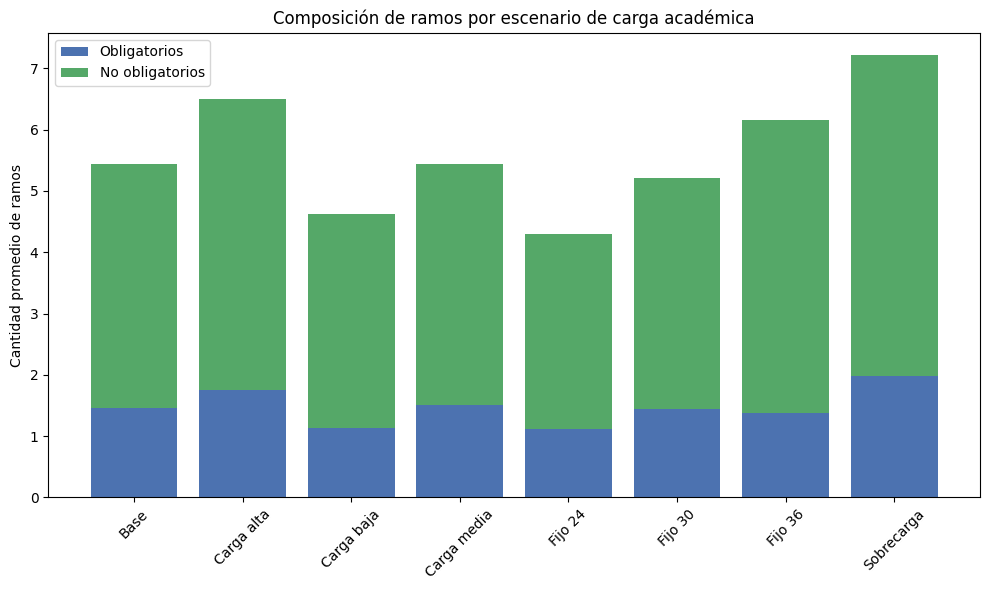

In [13]:
# Gráfico de barras apiladas para comparar ramos obligatorios y no obligatorios por escenario
df = df_resultados_creditos.copy()
escenarios = df["Escenario"]
obligatorios = df["Ramos obligatorios"]
no_obligatorios = df["Ramos electivos"]

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(escenarios, obligatorios, label="Obligatorios", color="#4C72B0")
ax.bar(escenarios, no_obligatorios, bottom=obligatorios, label="No obligatorios", color="#55A868")

ax.set_ylabel("Cantidad promedio de ramos")
ax.set_title("Composición de ramos por escenario de carga académica")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


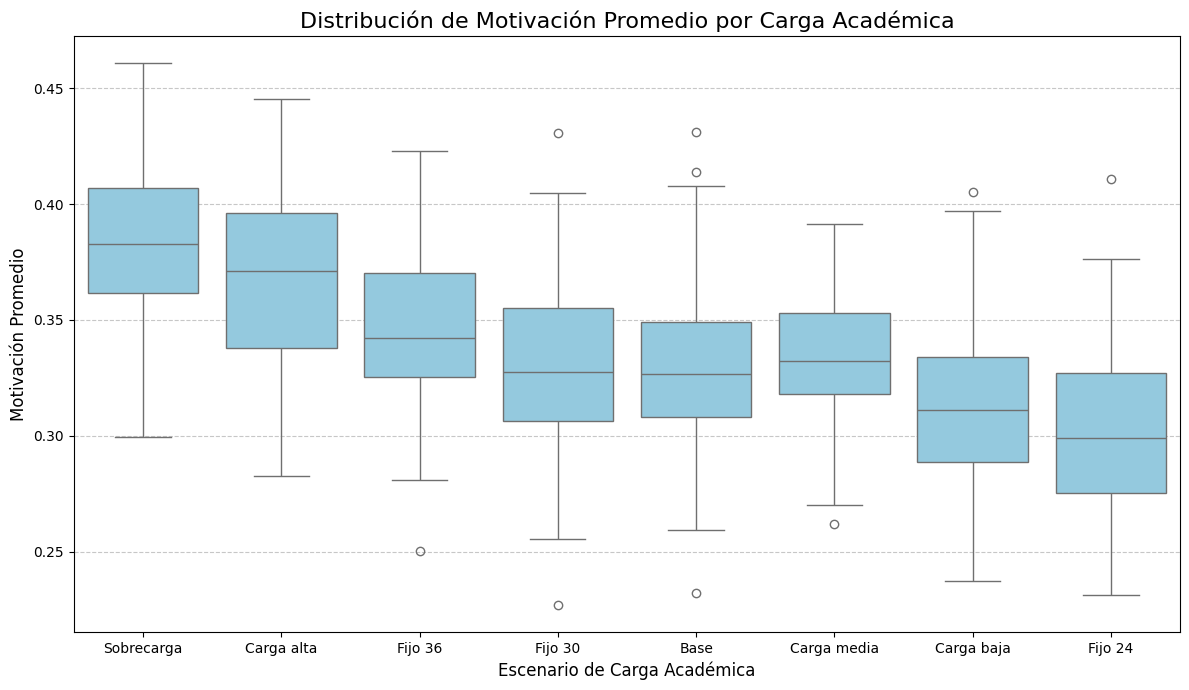

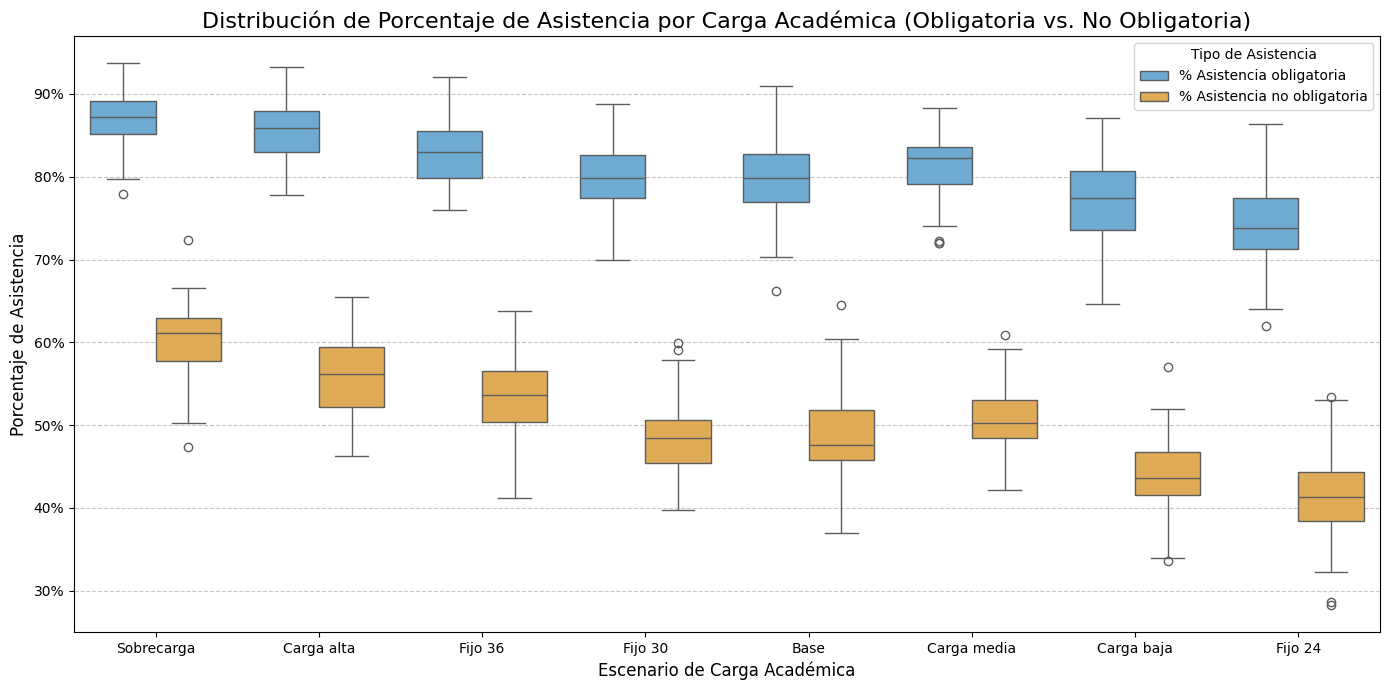

In [14]:
# Gráfico de cajas para comparar motivación y asistencia por escenario de créditos
# Definir el orden de los escenarios de créditos
orden_creditos = ["Sobrecarga", "Carga alta", "Fijo 36", "Fijo 30", "Base", "Carga media", "Carga baja", "Fijo 24"]

# Gráfico 1: Motivación Promedio por Carga Académica
plt.figure(figsize=(12, 7)) 

sns.boxplot(x="Escenario", y="Motivación promedio", data=df_resultados_creditos, order=orden_creditos, color="#87CEEB")

plt.title("Distribución de Motivación Promedio por Carga Académica", fontsize=16)
plt.xlabel("Escenario de Carga Académica", fontsize=12)
plt.ylabel("Motivación Promedio", fontsize=12)
#plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show() 


# Gráfico 2: Asistencia Obligatoria vs. No Obligatoria por Carga Académica 

df_asistencia_melted = df_resultados_creditos.melt(
    id_vars=['Escenario'],
    value_vars=['% Asistencia obligatoria', '% Asistencia no obligatoria'],
    var_name='Tipo de Asistencia',
    value_name='Porcentaje de Asistencia'
)

# Definir colores para los tipos de asistencia
colors_asistencia = {
    '% Asistencia obligatoria': '#5DADE2',
    '% Asistencia no obligatoria': '#F5B041'
}

plt.figure(figsize=(14, 7))
ax = sns.boxplot(
    x="Escenario",
    y="Porcentaje de Asistencia",
    hue="Tipo de Asistencia", 
    order=orden_creditos,
    palette=colors_asistencia #
)

plt.title("Distribución de Porcentaje de Asistencia por Carga Académica (Obligatoria vs. No Obligatoria)", fontsize=16)
plt.xlabel("Escenario de Carga Académica", fontsize=12)
plt.ylabel("Porcentaje de Asistencia", fontsize=12)
#plt.xticks(rotation=45, ha='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0)) 
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.legend(title="Tipo de Asistencia") 
plt.tight_layout()
plt.show()

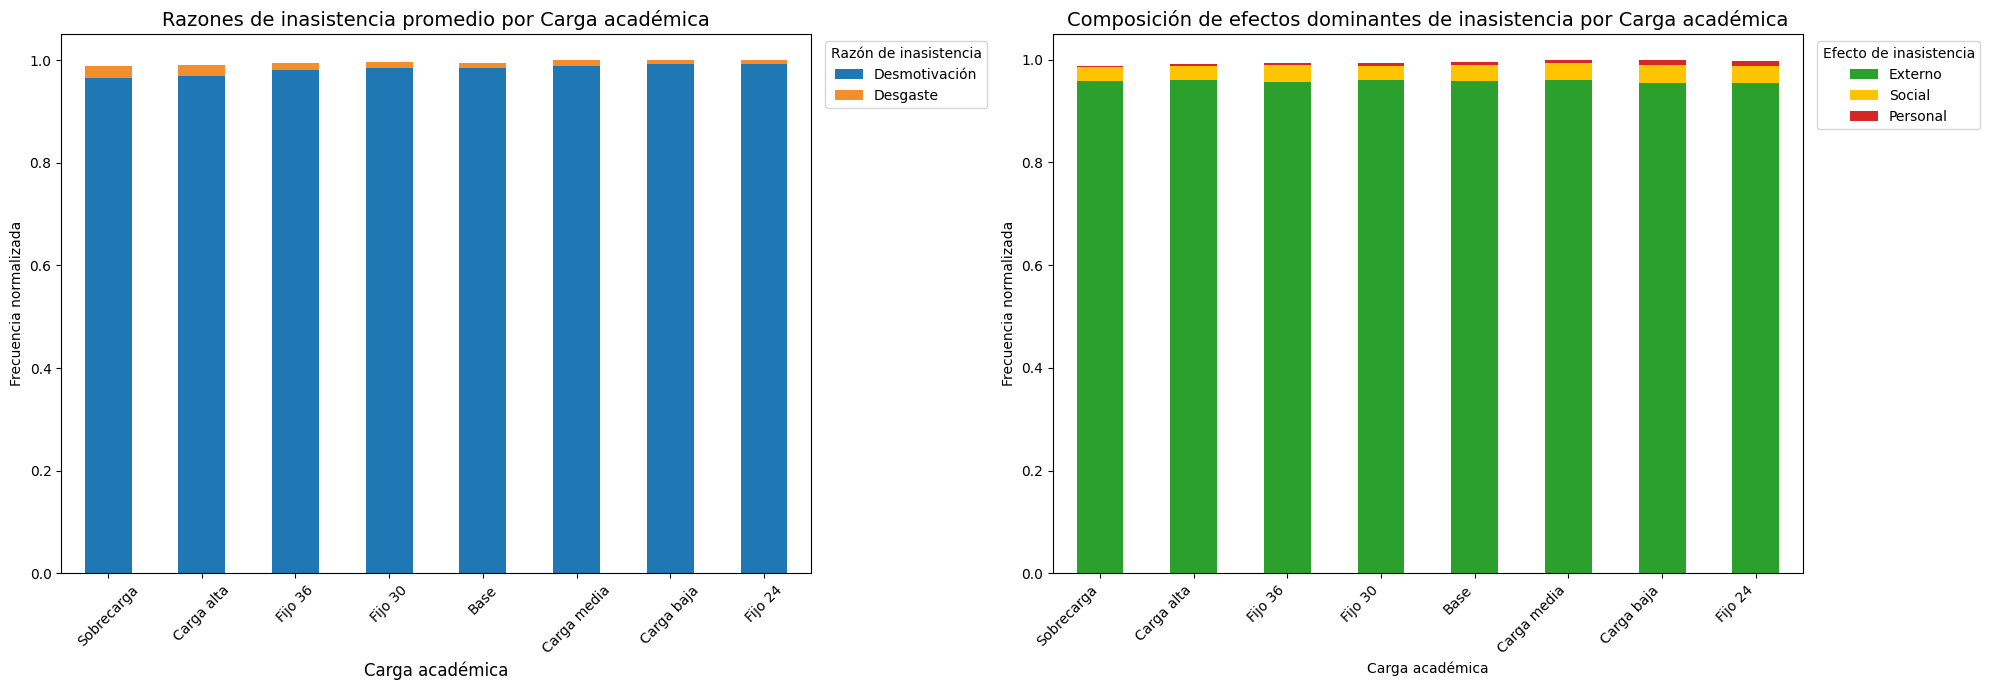

In [15]:
# Expandimos las razones a columnas
df_razones = df_resultados_creditos[["Escenario", "Razones"]].copy()
razones_expandido = df_razones["Razones"].apply(pd.Series)
df_razones_expandido = pd.concat([df_razones["Escenario"], razones_expandido], axis=1)

# Agrupar por escenario y sacar promedio por razón
df_reasons_avg = df_razones_expandido.groupby("Escenario").mean().fillna(0).T

# Ordenar según carga académica
orden_creditos = ["Sobrecarga", "Carga alta", "Fijo 36", "Fijo 30", "Base", "Carga media",  "Carga baja", "Fijo 24"]
df_reasons_avg = df_reasons_avg[orden_creditos if all(c in df_reasons_avg.columns for c in orden_creditos) else df_reasons_avg.columns]

# Expandimos las razones dominantes a columnas
df_reasons_effect = df_resultados_creditos[["Escenario", "Razones dominantes"]].copy()
reasons_effect_expandido = df_reasons_effect["Razones dominantes"].apply(pd.Series)
df_reasons_effect_expandido = pd.concat([df_reasons_effect["Escenario"], reasons_effect_expandido], axis=1)
df_reasons_effect_avg = df_reasons_effect_expandido.groupby("Escenario").mean().fillna(0).T

clim_orden_reasons_effect = [c for c in orden_creditos if c in df_reasons_effect_avg.columns]
df_reasons_effect_avg = df_reasons_effect_avg[clim_orden_reasons_effect]

# Reordenar razones promedio (de mayor a menor para cada escenario)
df_reasons_avg = df_reasons_avg.sort_values(by=df_reasons_avg.columns.tolist(), ascending=False)

# Reordenar efectos promedio (también de mayor a menor)
df_reasons_effect_avg = df_reasons_effect_avg.sort_values(by=df_reasons_effect_avg.columns.tolist(), ascending=False)

# Crear gráfico de barras apiladas
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Graficar razones de inasistencia y efectos dominantes
colors_for_reasons = ['#1f77b4','#F28E2B']
df_reasons_avg.T.plot(kind="bar", stacked=True, ax=axes[0], color=colors_for_reasons)
axes[0].set_title("Razones de inasistencia promedio por Carga académica", fontsize=14)
axes[0].set_ylabel("Frecuencia normalizada")
axes[0].set_xlabel("Carga académica", fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

axes[0].legend(title="Razón de inasistencia", bbox_to_anchor=(1.01, 1), loc='upper left')

colors_for_effects = ['#2CA02C', "#FFC400",'#d62728']
df_reasons_effect_avg.T.plot(kind="bar", stacked=True, ax=axes[1], color=colors_for_effects)
axes[1].set_title("Composición de efectos dominantes de inasistencia por Carga académica", fontsize=14)
axes[1].set_ylabel("Frecuencia normalizada")
axes[1].set_xlabel("Carga académica")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].legend(title="Efecto de inasistencia", bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()


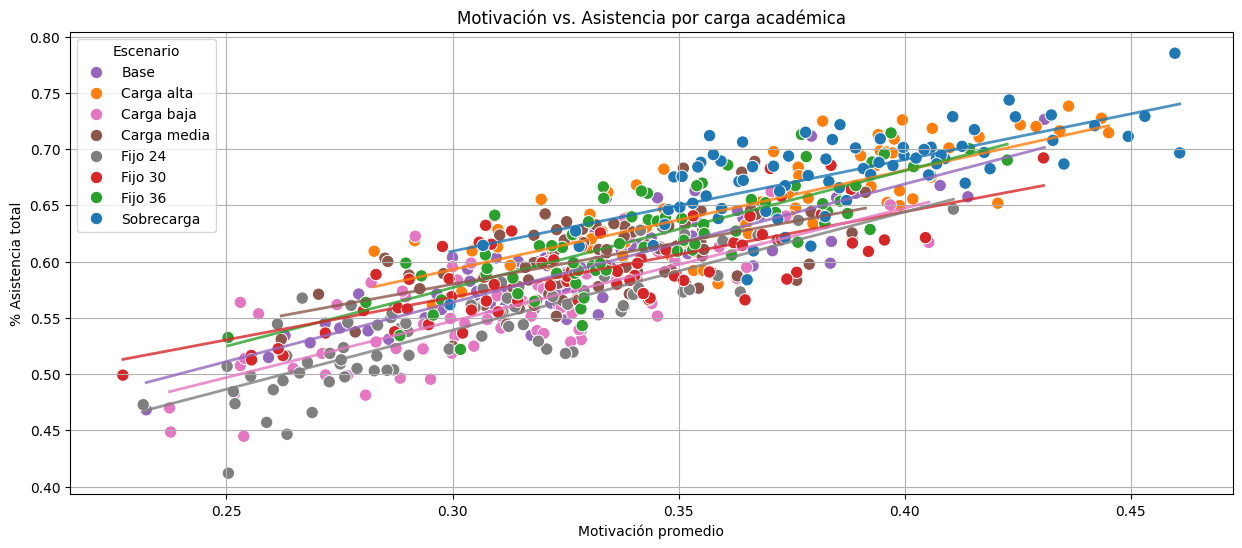

In [ ]:
# Gráfico de dispersión de motivación promedio vs asistencia total por escenario
plt.figure(figsize=(15, 6))

# Definir colores para cada escenario
colores_escenarios = sns.color_palette("tab10", n_colors=len(orden_creditos))
mapa_colores = dict(zip(orden_creditos, colores_escenarios))

sns.scatterplot(
    x="Motivación promedio",
    y="% Asistencia total",
    hue="Escenario",
    data=df_resultados_creditos,
    s=80,
    palette=mapa_colores,
)
for i, escenario in enumerate(orden_creditos):
    # Filtra los datos para el escenario actual
    df_temp = df_resultados_creditos[df_resultados_creditos["Escenario"] == escenario]

    sns.regplot(
        x="Motivación promedio",
        y="% Asistencia total",
        data=df_temp,
        scatter=False,
        color=mapa_colores[escenario],
        line_kws={'linewidth': 2, 'alpha': 0.8},
        ci=None
    )

plt.title("Motivación vs. Asistencia por carga académica")
plt.xlabel("Motivación promedio")
plt.ylabel("% Asistencia total")
plt.grid(True)
plt.legend(title="Escenario")
plt.show()


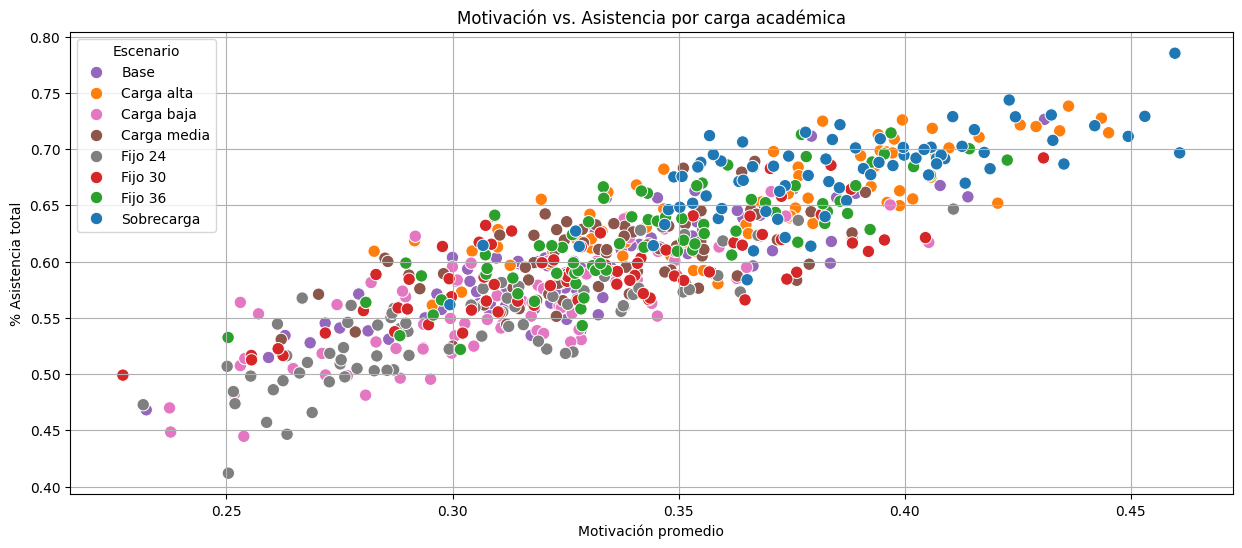

In [ ]:
# Gráfico de dispersión de motivación promedio vs asistencia total por escenario
plt.figure(figsize=(15, 6))

# Colores para cada escenario
colores_escenarios = sns.color_palette("tab10", n_colors=len(orden_creditos))
mapa_colores = dict(zip(orden_creditos, colores_escenarios))

sns.scatterplot(
    x="Motivación promedio",
    y="% Asistencia total",
    hue="Escenario",
    data=df_resultados_creditos,
    s=80,
    palette=mapa_colores,
)

plt.title("Motivación vs. Asistencia por carga académica")
plt.xlabel("Motivación promedio")
plt.ylabel("% Asistencia total")
plt.grid(True)
plt.legend(title="Escenario")
plt.show()


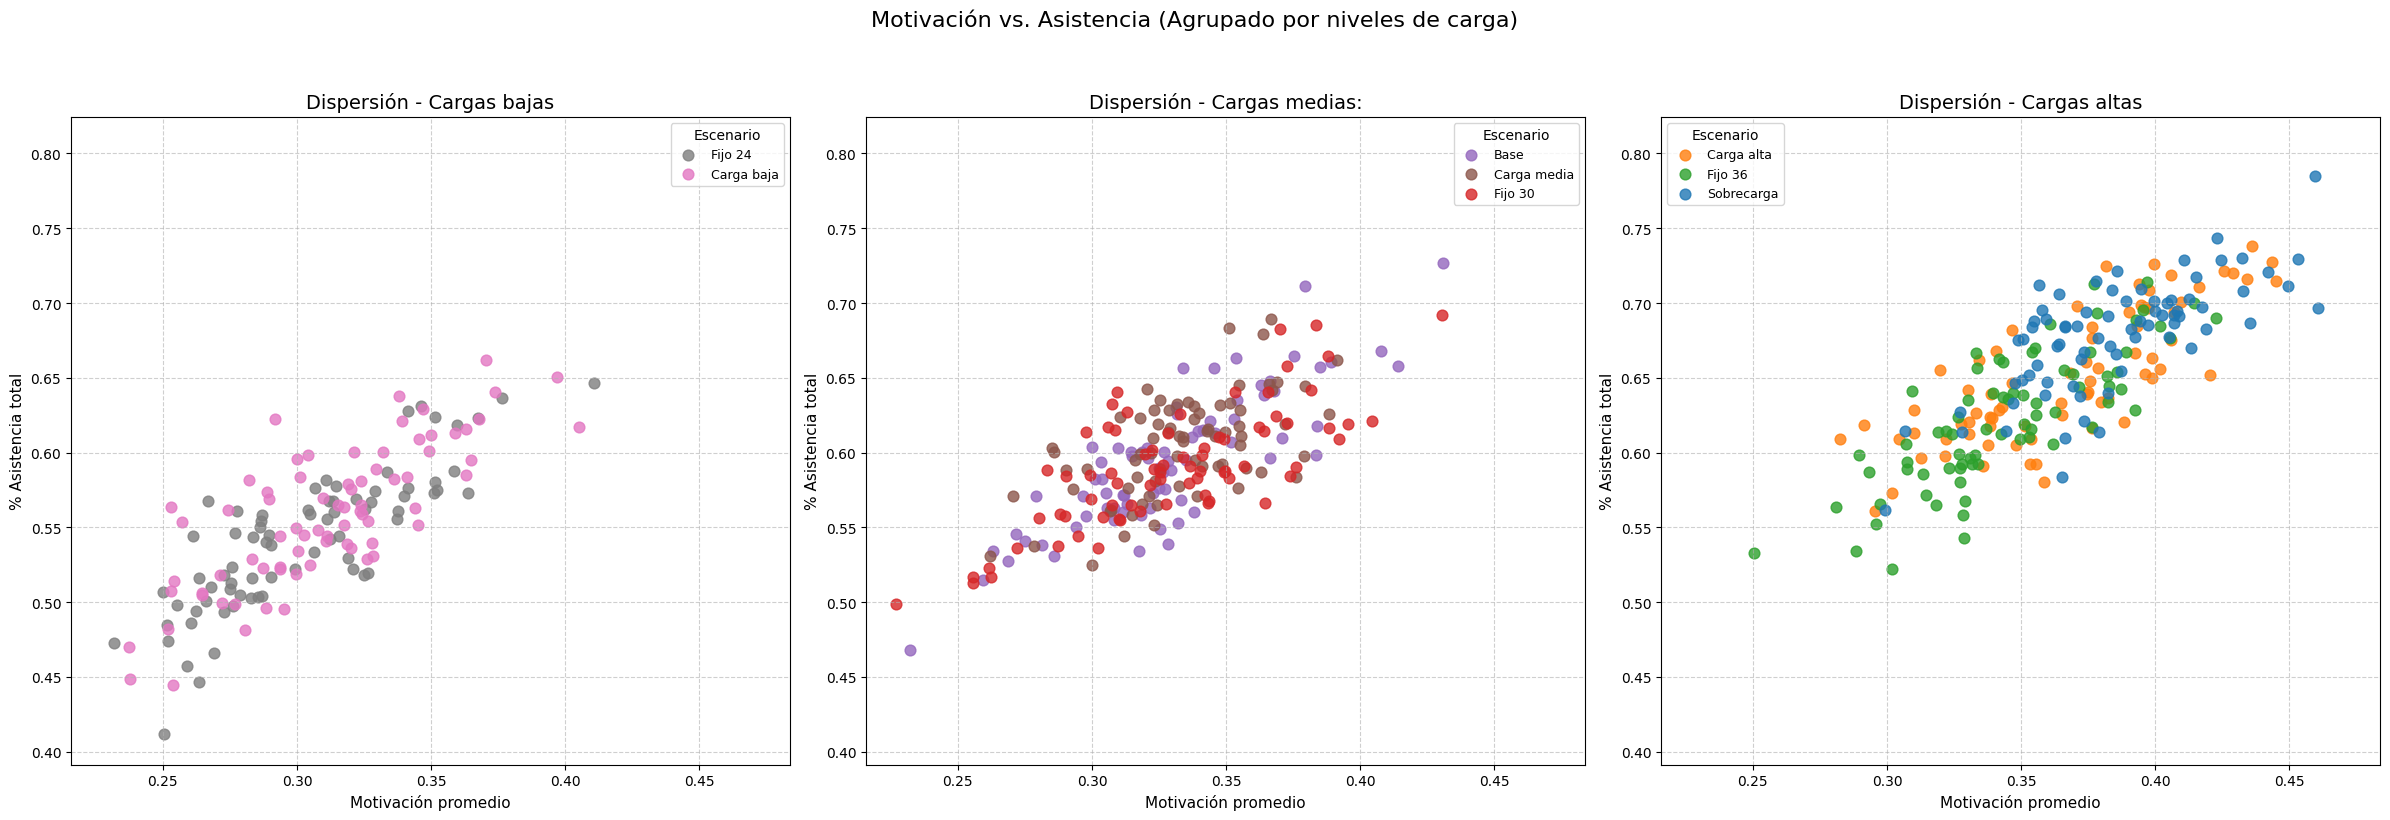

In [ ]:
# Crear grupos 
grupo_bajo = ["Fijo 24", "Carga baja"]
grupo_medio = [ "Base", "Carga media", "Fijo 30"]
grupo_alto = ["Carga alta", "Fijo 36", "Sobrecarga"]

grupos = {
    "Cargas bajas": grupo_bajo,
    "Cargas medias:": grupo_medio,
    "Cargas altas": grupo_alto,
}

# Se calculan los límites globales de los ejes
min_mot = df_resultados_creditos["Motivación promedio"].min()
max_mot = df_resultados_creditos["Motivación promedio"].max()
min_asi = df_resultados_creditos["% Asistencia total"].min()
max_asi = df_resultados_creditos["% Asistencia total"].max()

# Se ajustan los límites para dejar un pequeño margen y redondear
global_xlim = (min_mot * 0.95, max_mot * 1.05)
global_ylim = (min_asi * 0.95, max_asi * 1.05)

# La figura con 3 subplots (uno por grupo)
fig, axes = plt.subplots(1, 3, figsize=(24, 8)) 
axes = axes.flatten()

# Colores para cada escenario
colores_escenarios = sns.color_palette("tab10", n_colors=len(orden_creditos))
mapa_colores = dict(zip(orden_creditos, colores_escenarios))

for i, (nombre_grupo, escenarios) in enumerate(grupos.items()):
    ax = axes[i]

    for escenario in escenarios:
        df_temp = df_resultados_creditos[df_resultados_creditos["Escenario"] == escenario]

        ax.scatter(
            df_temp["Motivación promedio"],
            df_temp["% Asistencia total"],
            label=escenario,
            color=mapa_colores[escenario],
            s=60,
            alpha=0.8
        )

    # Títulos y ejes
    ax.set_title(f"Dispersión - {nombre_grupo}", fontsize=14)
    ax.set_xlabel("Motivación promedio", fontsize=11)
    ax.set_ylabel("% Asistencia total", fontsize=11)
    ax.set_xlim(global_xlim)
    ax.set_ylim(global_ylim)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(title="Escenario", fontsize=9)

fig.suptitle("Motivación vs. Asistencia (Agrupado por niveles de carga)", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


In [29]:
# Procesar los resultados para el gráfico de Orbit Chart semanal
df_semanal_creditos_detalle, df_semanal_creditos = procesar_resultados_para_orbit_chart(resultados_comparativos_creditos)


In [30]:
df_semanal_creditos_detalle

escenario  run  semana  motivacion  asistencia  % obligatoria  \
0            Base    0       1    0.642152    0.745333       0.648980   
1            Base    0       2    0.589188    0.671667       0.591837   
2            Base    0       3    0.597093    0.727667       0.644898   
3            Base    0       4    0.446810    0.541667       0.473469   
4            Base    0       5    0.343580    0.286667       0.248980   
...           ...  ...     ...         ...         ...            ...   
15595  Sobrecarga   74      22    0.334680    0.645000       0.663830   
15596  Sobrecarga   74      23    0.471146    0.657000       0.676596   
15597  Sobrecarga   74      24    0.386216    0.653000       0.672340   
15598  Sobrecarga   74      25    0.331102    0.649000       0.668085   
15599  Sobrecarga   74      26    0.362678    0.653000       0.672340   

       % no obligatoria  
0                 0.644  
1                 0.580  
2                 0.632  
3                 0.464  
4                 0.244  
...                 ...  
15595             0.624  
15596             0.636  
15597             0.632  
15598             0.628  
15599             0.632  

[15600 rows x 7 columns]

In [31]:
df_semanal_creditos

escenario  semana   run  motivacion  asistencia  % obligatoria  \
0          Base       1  37.0    0.485424    0.486236       0.482193   
1          Base       2  37.0    0.338161    0.247124       0.250507   
2          Base       3  37.0    0.333932    0.370689       0.386952   
3          Base       4  37.0    0.337149    0.468671       0.489962   
4          Base       5  37.0    0.327591    0.503436       0.525643   
..          ...     ...   ...         ...         ...            ...   
203  Sobrecarga      22  37.0    0.375282    0.663982       0.687158   
204  Sobrecarga      23  37.0    0.358502    0.661249       0.684490   
205  Sobrecarga      24  37.0    0.369636    0.662018       0.685141   
206  Sobrecarga      25  37.0    0.370593    0.662071       0.685167   
207  Sobrecarga      26  37.0    0.370187    0.663111       0.686450   

     % no obligatoria  
0            0.429722  
1            0.215432  
2            0.331578  
3            0.419433  
4            0.450599  
..                ...  
203          0.646307  
204          0.643752  
205          0.644385  
206          0.644441  
207          0.645615  

[208 rows x 7 columns]

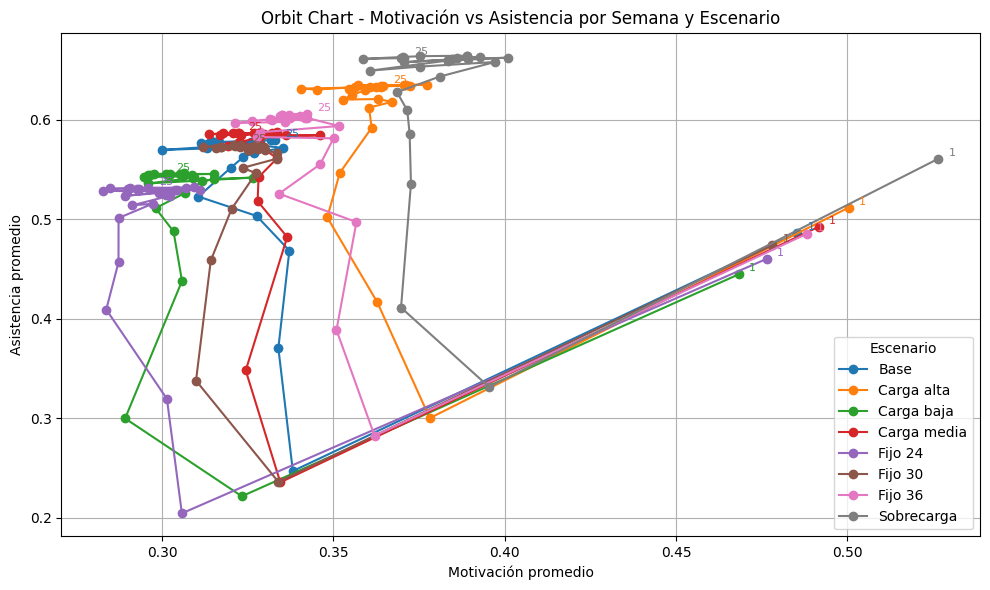

In [24]:
# Gráfico de Orbit Chart: Motivación vs Asistencia por Semana y Escenario
plt.figure(figsize=(10, 6))

# Paleta de colores por escenario
palette = sns.color_palette("tab10", len(df_semanal_creditos["escenario"].unique()))

# Orbit chart: línea por escenario
for i, (escenario, grupo) in enumerate(df_semanal_creditos.groupby("escenario")):
    grupo_sorted = grupo.sort_values("semana")
    plt.plot(grupo_sorted["motivacion"], grupo_sorted["asistencia"],
             marker="o", label=escenario, color=palette[i])

    # Agregar número de semana en cada punto para ver la semana correspondiente
    for _, row in grupo_sorted.iterrows():
        if row["semana"] in [1, 25]:
            plt.text(row["motivacion"] + 0.003, row["asistencia"] + 0.003,
                 str(row["semana"]), fontsize=8, color=palette[i])

plt.title("Orbit Chart - Motivación vs Asistencia por Semana y Escenario")
plt.xlabel("Motivación promedio")
plt.ylabel("Asistencia promedio")
plt.legend(title="Escenario")
plt.grid(True)
plt.autoscale(enable=True, axis='both', tight=False)
plt.tight_layout()
plt.show()


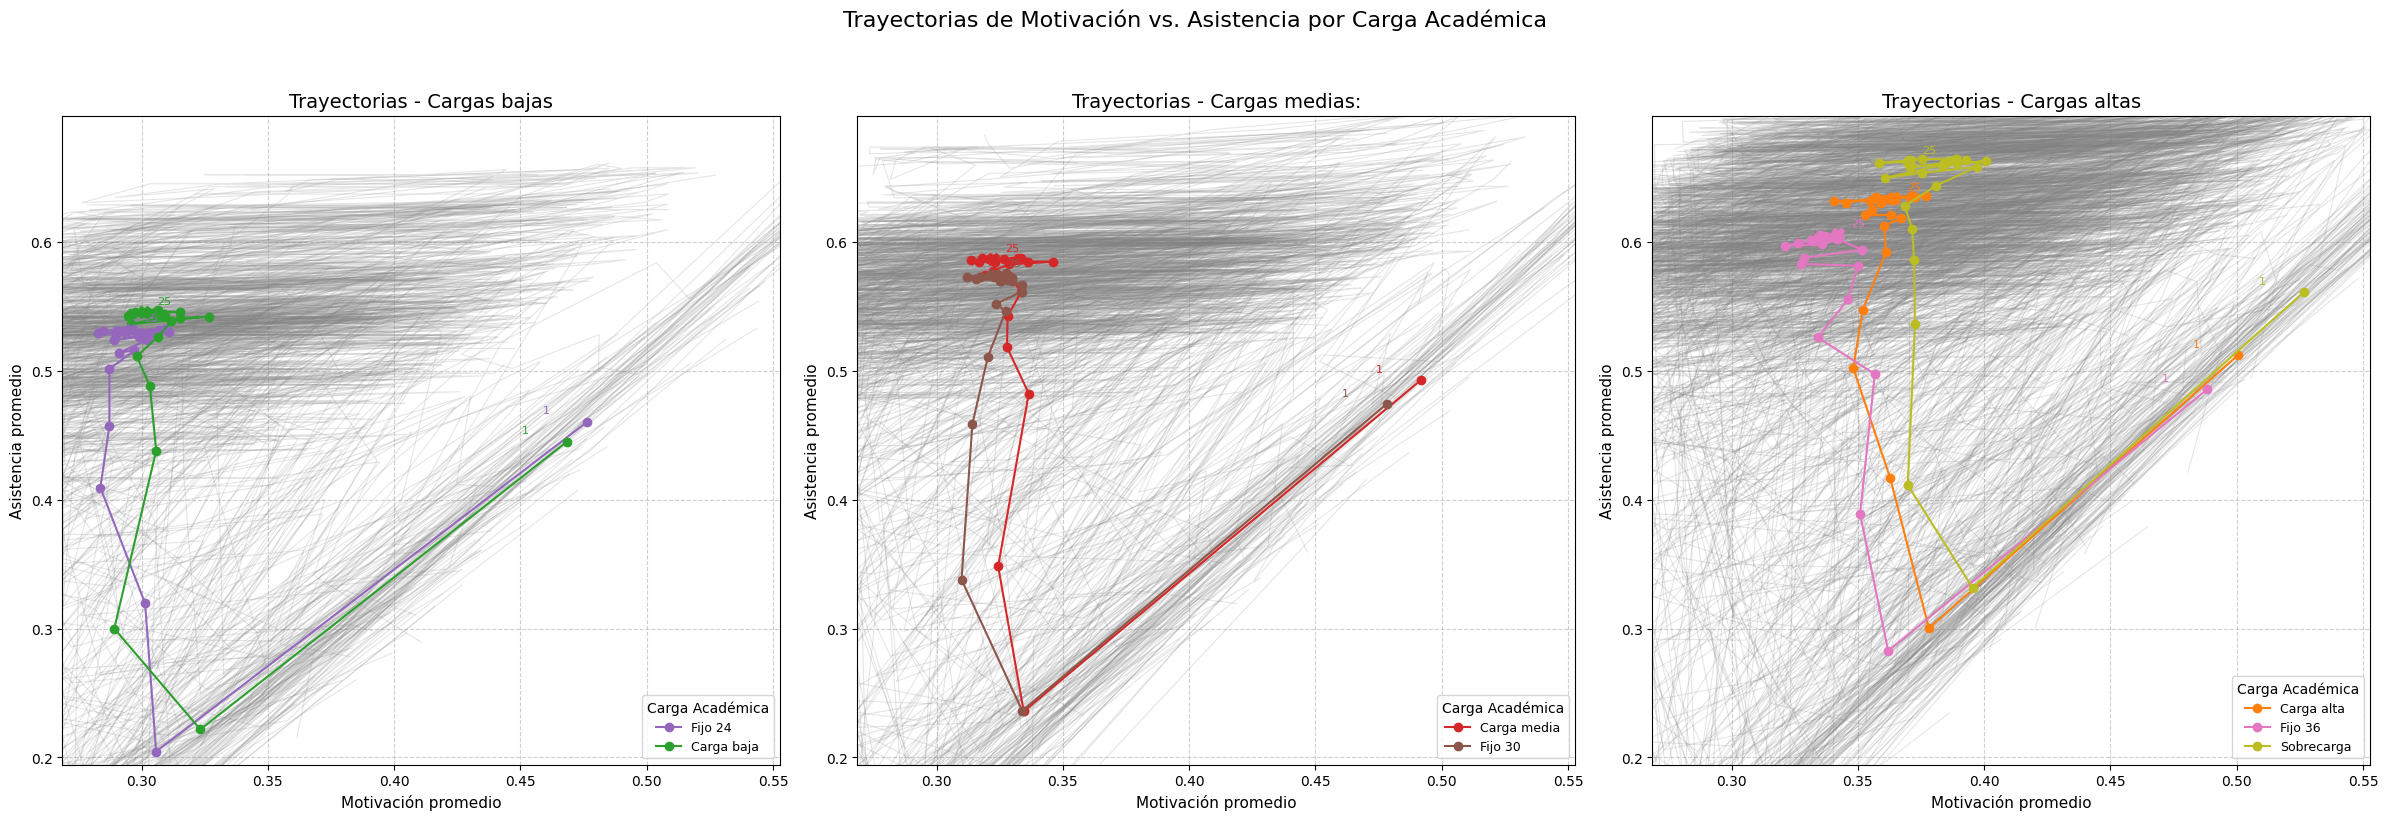

In [ ]:
# Crear grupos 
grupo_bajo = ["Fijo 24", "Carga baja"]
grupo_medio = [ "Carga media", "Fijo 30"]
grupo_alto = ["Carga alta", "Fijo 36", "Sobrecarga"]

grupos = {
    "Cargas bajas": grupo_bajo,
    "Cargas medias:": grupo_medio,
    "Cargas altas": grupo_alto,
}

# Calcular los límites globales de los ejes 
min_mot = df_semanal_creditos["motivacion"].min()
max_mot = df_semanal_creditos["motivacion"].max()
min_asi = df_semanal_creditos["asistencia"].min()
max_asi = df_semanal_creditos["asistencia"].max()

# Ajusta los límites para dejar un pequeño margen y redondear
global_xlim = (min_mot * 0.95, max_mot * 1.05)
global_ylim = (min_asi * 0.95, max_asi * 1.05)

# La figura combinada con subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8)) 
axes = axes.flatten() 

# Obtener la paleta de colores consistente para todos los escenarios
all_scenarios = df_semanal_creditos["escenario"].unique()
palette_colors = sns.color_palette("tab10", len(all_scenarios) + 2)
del palette_colors[7]

# Crear un mapeo de escenario a color para asegurar consistencia
color_map = {scenario: palette_colors[i] for i, scenario in enumerate(all_scenarios)}

# Dibujar las trayectorias de motivación vs asistencia por grupo
for i, (nombre_grupo, escenarios) in enumerate(grupos.items()):
    ax = axes[i] # Selecciona el subplot actual

    # 1) Pinto cada trayectoria individual en gris y con alpha
    for escenario in escenarios:
        for run in df_semanal_creditos_detalle[df_semanal_creditos_detalle["escenario"] == escenario]["run"].unique():
            serie = df_semanal_creditos_detalle[
                (df_semanal_creditos_detalle["escenario"] == escenario) &
                (df_semanal_creditos_detalle["run"] == run)
            ].sort_values("semana")
            ax.plot(
                serie["motivacion"], serie["asistencia"],
                color="gray", alpha=0.2, linewidth=0.8
            )

    # 2) Pinto encima la media en color consistente
    for escenario in escenarios:
        grupo = df_semanal_creditos[df_semanal_creditos["escenario"] == escenario]
        grupo_sorted = grupo.sort_values("semana")
        
        # Usa el mapeo de color para obtener el color correcto y consistente
        line_color = color_map[escenario]
        

        ax.plot(grupo_sorted["motivacion"], grupo_sorted["asistencia"],
                marker="o", label=escenario, color=line_color, linewidth=1.5, markersize=6)
        
        for _, row in grupo_sorted.iterrows():
            if row["semana"] in [1, 25]:
                # Ajusta el offset del texto para que no se superponga
                x_offset = 0.005 if row["semana"] == 25 else -0.015 
                y_offset = 0.005
                ha = 'left' if row["semana"] == 25 else 'right'
                ax.text(row["motivacion"] + x_offset, row["asistencia"] + y_offset,
                        str(row["semana"]), fontsize=8, color=line_color, ha=ha, va='bottom')
            
            # Distintibo para la semana 25
            if row["semana"] == 25:
                ax.plot(row["motivacion"], row["asistencia"],
                        marker="X", markersize=9, color=line_color, zorder=5, linestyle='none') # Marcador 'X' más grande

    # Título y etiquetas al subplot
    ax.set_title(f"Trayectorias - {nombre_grupo}", fontsize=14) 
    ax.set_xlabel("Motivación promedio", fontsize=11)
    ax.set_ylabel("Asistencia promedio", fontsize=11)
    

    ax.set_xlim(global_xlim)
    ax.set_ylim(global_ylim)
    ax.grid(True, linestyle="--", alpha=0.6) 
    ax.legend(title="Carga Académica", loc="lower right", fontsize=9, title_fontsize=10) 

# Título general de la figura
fig.suptitle("Trayectorias de Motivación vs. Asistencia por Carga Académica", fontsize=16, y=1.02)

plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()

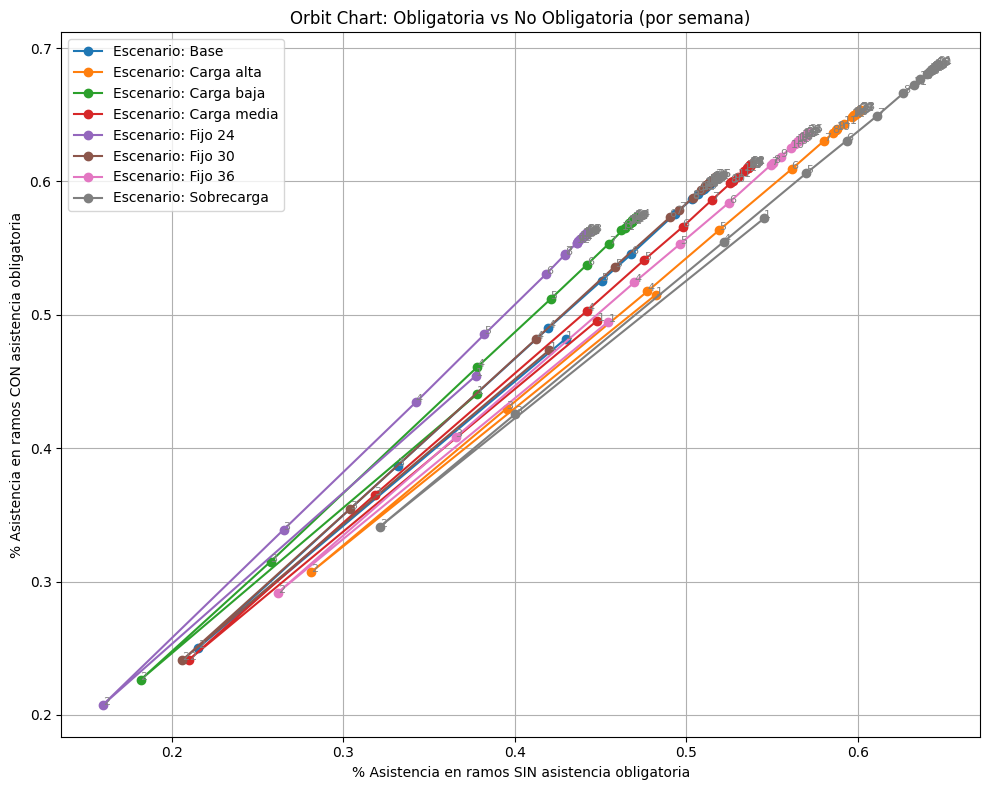

In [26]:
# Orbit Chart: Asistencia obligatoria vs no obligatoria por semana
plt.figure(figsize=(10, 8))

escenarios = df_semanal_creditos["escenario"].unique()

for escenario in escenarios:
    subset = df_semanal_creditos[df_semanal_creditos["escenario"] == escenario]
    plt.plot(
        subset["% no obligatoria"],
        subset["% obligatoria"],
        marker="o",
        label=f"Escenario: {escenario}"
    )
    # Ponemos las semanas en los puntos
    for i, row in subset.iterrows():
        plt.text(
            row["% no obligatoria"],
            row["% obligatoria"],
            str(row["semana"]),
            fontsize=8,
            color="gray"
        )

plt.xlabel("% Asistencia en ramos SIN asistencia obligatoria")
plt.ylabel("% Asistencia en ramos CON asistencia obligatoria")
plt.title("Orbit Chart: Obligatoria vs No Obligatoria (por semana)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Clima

In [6]:
# Escenarios de clima para comparar diferentes condiciones climáticas
scenarios = [
    {"name": "Clima Random (Base)", "params": {"weather_type": ["random"]}},
    {"name": "Clima Soleado", "params": {"weather_type": ["sunny"]}},
    {"name": "Clima Lluvioso", "params": {"weather_type": ["rainy"]}},
    {"name": "Clima Frío", "params": {"weather_type": ["cold"]}},
    {"name": "Clima Caluroso", "params": {"weather_type": ["hot"]}},
    {"name": "Clima Nublado", "params": {"weather_type": ["cloudy"]}},
    {"name": "Clima Helado", "params": {"weather_type": ["freezing"]}},
]

# Definimos los parámetros base para cada escenario de clima
dfs = []
for esc in scenarios:
    base_params = {
        "num_students": 50,
        "min_credits": 21,
        "max_credits": 39,
        "prob_mandatory": [0.35],
        "personal_weight": [0.5],
        "social_weight": [0.3],
        "external_weight": [0.2],
        "network_k": [4],
        "network_p": [0.3],
    }
    base_params.update(esc["params"])
    df = ejecutar_escenario(esc["name"], base_params)
    dfs.append(df)

# Concatenar todos
resultados_comparativos_clima = pd.concat(dfs, ignore_index=True)


Ejecutando escenario: Clima Random (Base)


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Clima Soleado


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Clima Lluvioso


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Clima Frío


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Clima Caluroso


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Clima Nublado


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Clima Helado


  0%|          | 0/75 [00:00<?, ?it/s]

In [7]:
resultados_comparativos_clima.head()

RunId  iteration  Step  num_students  min_credits  max_credits  \
0      0          0     0            50           21           39   
1      0          0     0            50           21           39   
2      0          0     0            50           21           39   
3      0          0     0            50           21           39   
4      0          0     0            50           21           39   

   prob_mandatory  personal_weight  social_weight  external_weight  ...  \
0            0.35              0.5            0.3              0.2  ...   
1            0.35              0.5            0.3              0.2  ...   
2            0.35              0.5            0.3              0.2  ...   
3            0.35              0.5            0.3              0.2  ...   
4            0.35              0.5            0.3              0.2  ...   

   Attendance Rate  Attendance Reasons Count  Reasons Effect Count  \
0              1.0          50            {}                    {}   
1              1.0          50            {}                    {}   
2              1.0          50            {}                    {}   
3              1.0          50            {}                    {}   
4              1.0          50            {}                    {}   

   Motivation Weather AgentID  Attends Class  \
0    0.854501  random       1           True   
1    0.854501  random       2           True   
2    0.854501  random       3           True   
3    0.854501  random       4           True   
4    0.854501  random       5           True   

                                           Week Data            Escenario  
0  [{'week': 1, 'days': [{'day': 'mon', 'attended...  Clima Random (Base)  
1  [{'week': 1, 'days': [{'day': 'mon', 'attended...  Clima Random (Base)  
2  [{'week': 1, 'days': [{'day': 'mon', 'attended...  Clima Random (Base)  
3  [{'week': 1, 'days': [{'day': 'mon', 'attended...  Clima Random (Base)  
4  [{'week': 1, 'days': [{'day': 'mon', 'attended...  Clima Random (Base)  

[5 rows x 23 columns]

In [8]:
# Procesar los resultados de los escenarios de clima
df_resultados_clima = procesar_resultados(resultados_comparativos_clima)
df_resultados_clima


Escenario  Motivación promedio  Asistencia promedio  \
0    Clima Caluroso             0.298203             0.518000   
1    Clima Caluroso             0.256688             0.458154   
2    Clima Caluroso             0.300162             0.555077   
3    Clima Caluroso             0.261457             0.450615   
4    Clima Caluroso             0.254509             0.458923   
..              ...                  ...                  ...   
520   Clima Soleado             0.580161             0.642308   
521   Clima Soleado             0.492885             0.569231   
522   Clima Soleado             0.448128             0.504000   
523   Clima Soleado             0.477734             0.552154   
524   Clima Soleado             0.487292             0.529231   

     Asistencia obligatoria  Asistencia no obligatoria  % Asistencia total  \
0                  0.855385                   0.850769            0.619983   
1                  0.801538                   0.740000            0.575632   
2                  0.861538                   0.787692            0.620595   
3                  0.797692                   0.762308            0.568759   
4                  0.813077                   0.790000            0.573320   
..                      ...                        ...                 ...   
520                0.835385                   0.773077            0.735369   
521                0.868462                   0.757692            0.698435   
522                0.790000                   0.714615            0.563267   
523                0.869231                   0.795385            0.665069   
524                0.833077                   0.820000            0.631302   

     % Asistencia obligatoria  % Asistencia no obligatoria  Créditos promedio  \
0                    0.829583                     0.523362              32.10   
1                    0.774493                     0.438662              33.78   
2                    0.836944                     0.518823              34.26   
3                    0.773524                     0.476253              32.22   
4                    0.787318                     0.479984              32.76   
..                        ...                          ...                ...   
520                  0.824017                     0.628946              31.62   
521                  0.850919                     0.554615              32.58   
522                  0.776601                     0.460615              32.46   
523                  0.860867                     0.550948              31.80   
524                  0.819049                     0.547185              31.80   

     Ramos obligatorios  Ramos electivos  \
0                  1.84             3.00   
1                  1.78             3.22   
2                  1.98             3.22   
3                  1.56             3.50   
4                  1.82             3.30   
..                  ...              ...   
520                1.90             2.70   
521                1.84             2.92   
522                1.64             3.20   
523                1.82             2.98   
524                1.48             3.22   

                                               Razones  \
0    {'Desgaste': 0.03362091503267974, 'Desmotivaci...   
1    {'Desgaste': 0.0044444444444444444, 'Desmotiva...   
2    {'Desgaste': 0.021818181818181816, 'Desmotivac...   
3            {'Desgaste': 0.02, 'Desmotivación': 0.96}   
4          {'Desgaste': 0.005, 'Desmotivación': 0.975}   
..                                                 ...   
520            {'Desgaste': 0.2, 'Desmotivación': 0.5}   
521           {'Desgaste': 0.12, 'Desmotivación': 0.7}   
522          {'Desgaste': 0.09, 'Desmotivación': 0.77}   
523           {'Desgaste': 0.1, 'Desmotivación': 0.72}   
524           {'Desgaste': 0.1, 'Desmotivación': 0.76}   

                                    Razones dominantes  
0                                   

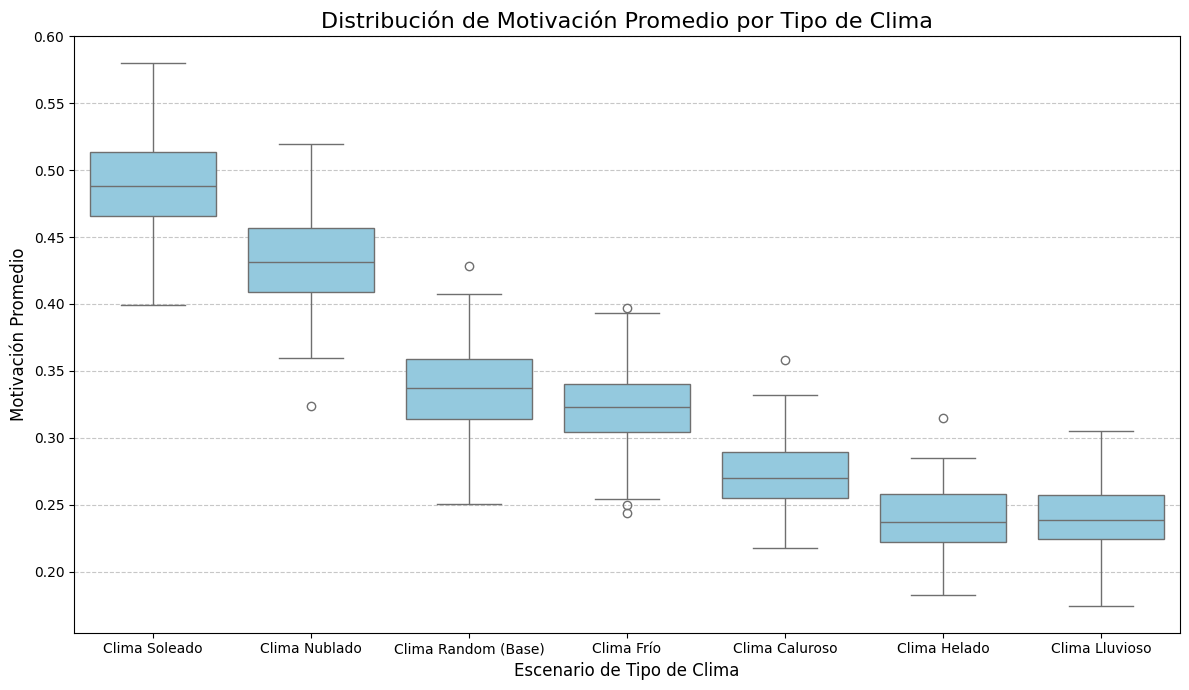

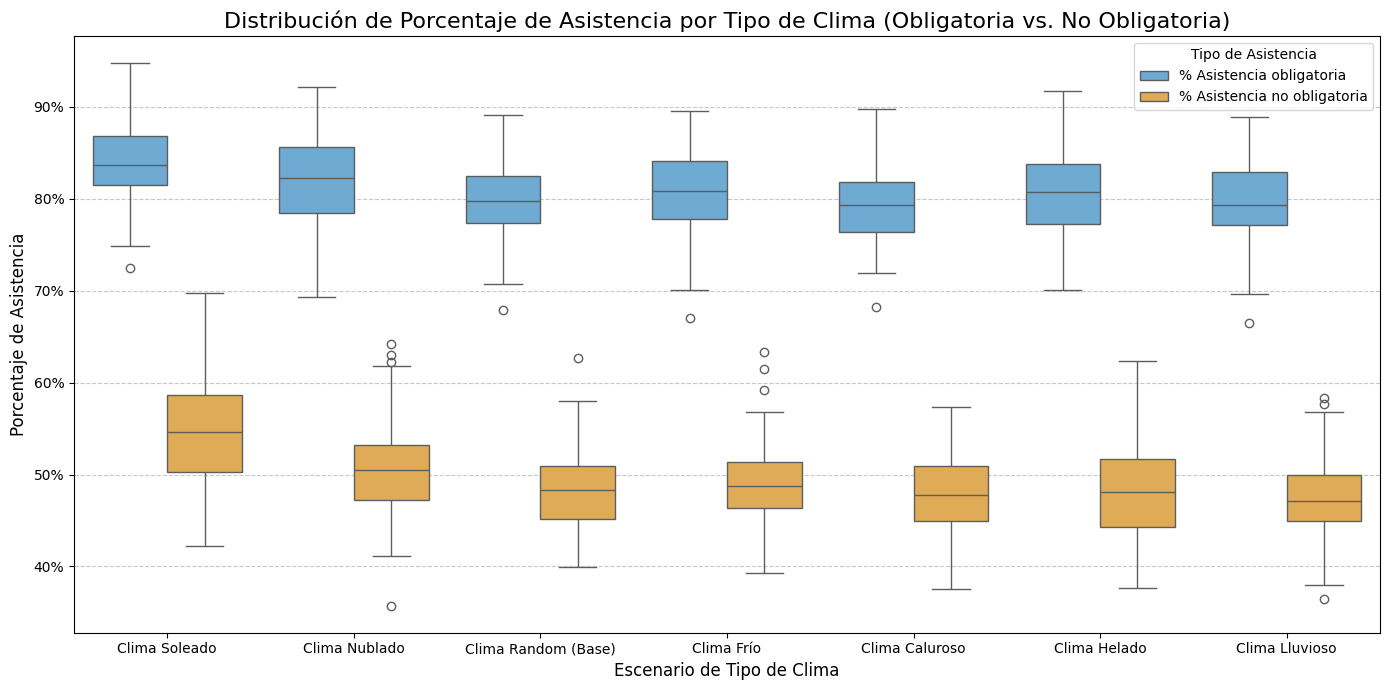

In [ ]:
# Gráfico de cajas para comparar motivación y asistencia por escenario de clima
# Ordenar los escenarios de clima
orden_climas = ["Clima Soleado", "Clima Nublado", "Clima Random (Base)", "Clima Frío", "Clima Caluroso", "Clima Helado", "Clima Lluvioso"]

# Gráfico 1: Motivación Promedio por tipo de clima  
plt.figure(figsize=(12, 7)) 

sns.boxplot(x="Escenario", y="Motivación promedio", data=df_resultados_clima, order=orden_climas, color="#87CEEB")

plt.title("Distribución de Motivación Promedio por Tipo de Clima", fontsize=16)
plt.xlabel("Escenario de Tipo de Clima", fontsize=12)
plt.ylabel("Motivación Promedio", fontsize=12)
#plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show() 


# Gráfico 2: Asistencia Obligatoria vs. No Obligatoria por clima

df_asistencia_melted = df_resultados_clima.melt(
    id_vars=['Escenario'],
    value_vars=['% Asistencia obligatoria', '% Asistencia no obligatoria'],
    var_name='Tipo de Asistencia',
    value_name='Porcentaje de Asistencia'
)

# Definir colores para los tipos de asistencia
colors_asistencia = {
    '% Asistencia obligatoria': '#5DADE2', 
    '% Asistencia no obligatoria': '#F5B041' 
}

plt.figure(figsize=(14, 7))
ax = sns.boxplot(
    x="Escenario",
    y="Porcentaje de Asistencia",
    hue="Tipo de Asistencia", 
    data=df_asistencia_melted,
    order=orden_climas,
    palette=colors_asistencia
)


plt.title("Distribución de Porcentaje de Asistencia por Tipo de Clima (Obligatoria vs. No Obligatoria)", fontsize=16)
plt.xlabel("Escenario de Tipo de Clima", fontsize=12)
plt.ylabel("Porcentaje de Asistencia", fontsize=12)
#plt.xticks(rotation=45, ha='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0)) 
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.legend(title="Tipo de Asistencia") 
plt.tight_layout()
plt.show()

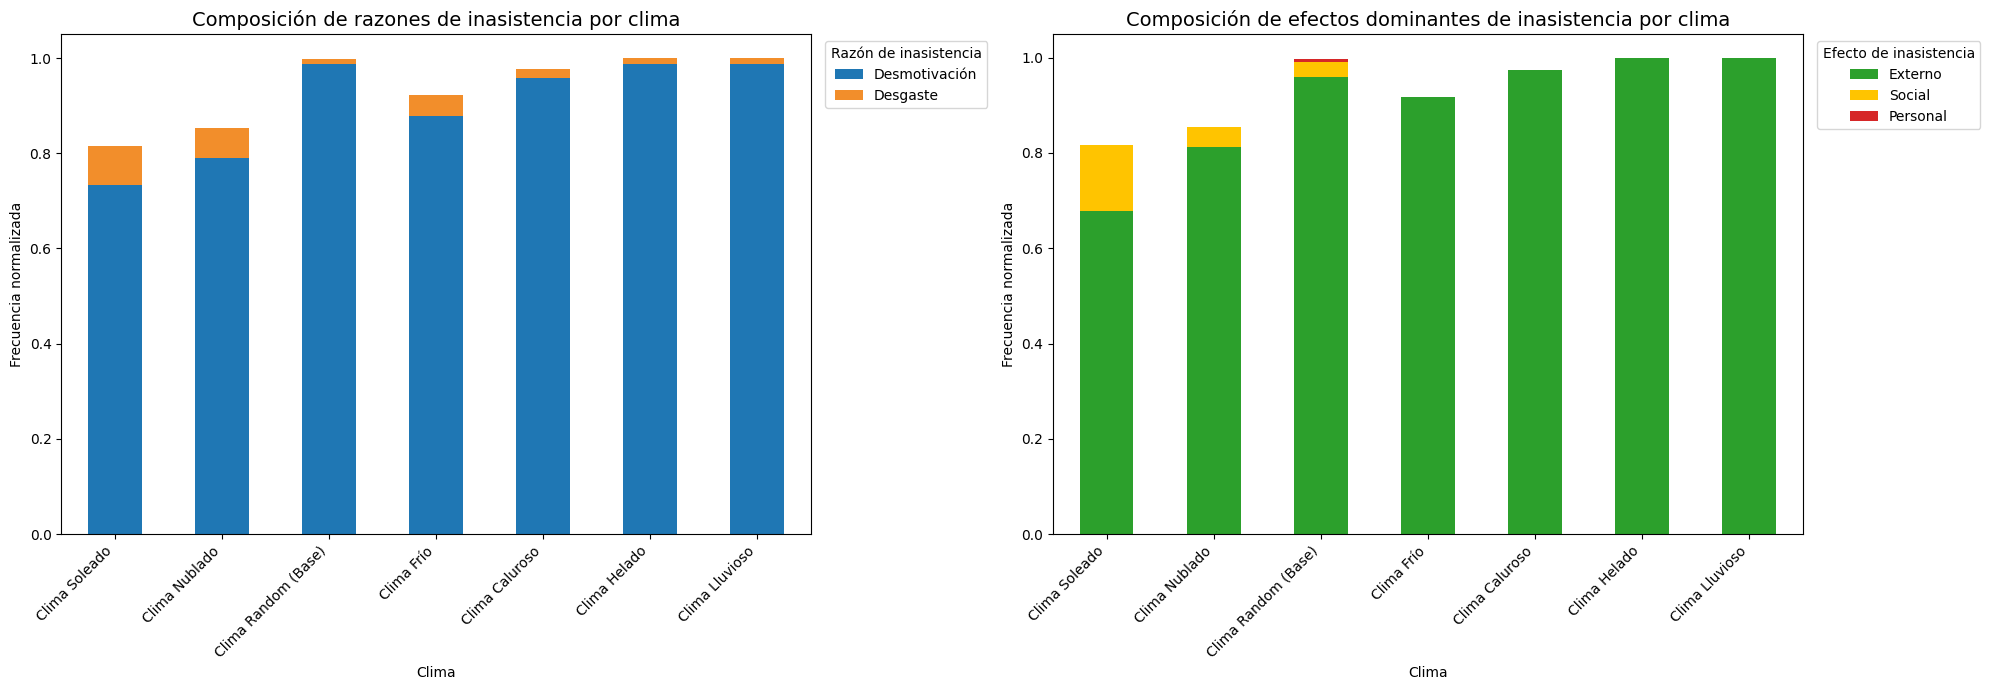

In [ ]:
# Expandimos las razones a columnas para el análisis de clima
df_razones = df_resultados_clima[["Escenario", "Razones"]].copy()
razones_expandido = df_razones["Razones"].apply(pd.Series)
df_razones_expandido = pd.concat([df_razones["Escenario"], razones_expandido], axis=1)

# Agrupar por clima y sacar promedio por razón
df_reasons_avg = df_razones_expandido.groupby("Escenario").mean().fillna(0).T

# Ordenen de los climas
orden_climas = ["Clima Soleado", "Clima Nublado", "Clima Random (Base)", "Clima Frío", "Clima Caluroso", "Clima Helado", "Clima Lluvioso"]

# Ordenar las columnas de acuerdo a los climas
clim_orden_reasons = [c for c in orden_climas if c in df_reasons_avg.columns]
df_reasons_avg = df_reasons_avg[clim_orden_reasons]

# Extraer las razones dominantes
df_reasons_effect = df_resultados_clima[["Escenario", "Razones dominantes"]].copy()
reasons_effect_expandido = df_reasons_effect["Razones dominantes"].apply(pd.Series)
df_reasons_effect_expandido = pd.concat([df_reasons_effect["Escenario"], reasons_effect_expandido], axis=1)
# Agrupar por clima y sacar promedio por razón dominante
df_reasons_effect_avg = df_reasons_effect_expandido.groupby("Escenario").mean().fillna(0).T

# Ordenar las columnas de acuerdo a los climas
clim_orden_reasons_effect = [c for c in orden_climas if c in df_reasons_effect_avg.columns]
df_reasons_effect_avg = df_reasons_effect_avg[clim_orden_reasons_effect]

# Reordenar razones promedio (de mayor a menor para cada escenario)
df_reasons_avg = df_reasons_avg.sort_values(by=df_reasons_avg.columns.tolist(), ascending=False)

# Reordenar efectos promedio (también de mayor a menor)
df_reasons_effect_avg = df_reasons_effect_avg.sort_values(by=df_reasons_effect_avg.columns.tolist(), ascending=False)


fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Gráfico de barras apiladas para razones de inasistencia por clima
colors_for_reasons = ['#1f77b4','#F28E2B']
df_reasons_avg.T.plot(kind="bar", stacked=True, ax=axes[0], color=colors_for_reasons)
axes[0].set_title("Composición de razones de inasistencia por clima", fontsize=14)
axes[0].set_ylabel("Frecuencia normalizada")
axes[0].set_xlabel("Clima")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].legend(title="Razón de inasistencia", bbox_to_anchor=(1.01, 1), loc='upper left')

# Gráfico de barras apiladas para razones dominantes de inasistencia por clima
colors_for_effects = [ '#2CA02C', "#FFC400", '#d62728']
df_reasons_effect_avg.T.plot(kind="bar", stacked=True, ax=axes[1], color=colors_for_effects)
axes[1].set_title("Composición de efectos dominantes de inasistencia por clima", fontsize=14)
axes[1].set_ylabel("Frecuencia normalizada")
axes[1].set_xlabel("Clima")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].legend(title="Efecto de inasistencia", bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()

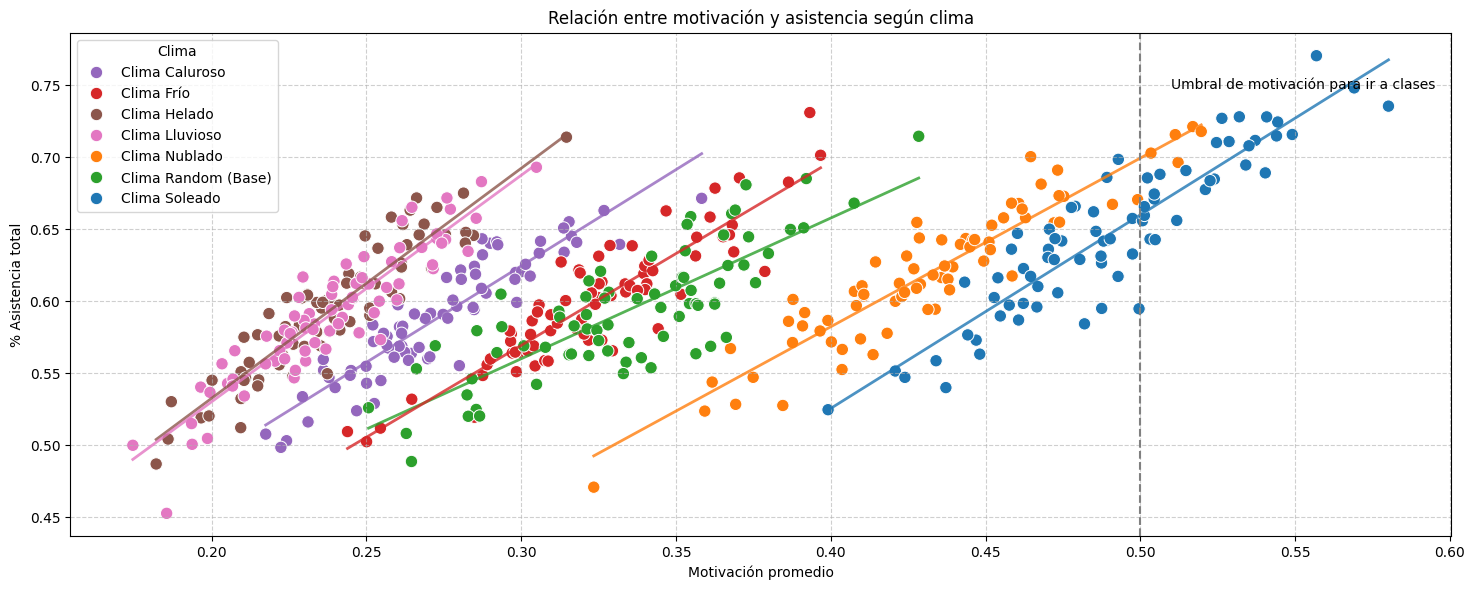

In [ ]:
plt.figure(figsize=(15, 6))

# Definir el orden de los escenarios de clima
colores_escenarios = sns.color_palette("tab10", n_colors=len(orden_climas))
mapa_colores = dict(zip(orden_climas, colores_escenarios))

# Scatterplot coloreado por clima
sns.scatterplot(
    x="Motivación promedio",
    y="% Asistencia total",
    hue="Escenario",
    data=df_resultados_clima,
    s=80,
    palette=mapa_colores
)

for i, escenario in enumerate(orden_climas):
    # Filtra los datos para el escenario actual
    df_temp = df_resultados_clima[df_resultados_clima["Escenario"] == escenario]

    sns.regplot(
        x="Motivación promedio",
        y="% Asistencia total",
        data=df_temp,
        scatter=False,
        color=mapa_colores[escenario],
        line_kws={'linewidth': 2, 'alpha': 0.8},
        ci=None
    )

# Línea vertical en el umbral de motivación 0.5
plt.axvline(x=0.5, color="gray", linestyle="--", linewidth=1.5)
plt.text(0.51, plt.ylim()[1] * 0.95, "Umbral de motivación para ir a clases", color="black")

# Títulos y etiquetas
plt.title("Relación entre motivación y asistencia según clima")
plt.xlabel("Motivación promedio")
plt.ylabel("% Asistencia total")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Clima")
plt.tight_layout()
plt.show()


In [107]:
# Procesar los resultados para el gráfico de Orbit Chart semanal
df_semanal_clima_detalle, df_semanal_clima = procesar_resultados_para_orbit_chart(resultados_comparativos_clima)


In [108]:
df_semanal_clima_detalle

escenario  run  semana  motivacion  asistencia  % obligatoria  \
0      Clima Caluroso    0       1    0.487608    0.507667       0.493333   
1      Clima Caluroso    0       2    0.317142    0.147000       0.155556   
2      Clima Caluroso    0       3    0.294401    0.328000       0.342222   
3      Clima Caluroso    0       4    0.290038    0.521000       0.528889   
4      Clima Caluroso    0       5    0.290693    0.555000       0.564444   
...               ...  ...     ...         ...         ...            ...   
13645   Clima Soleado   74      22    0.482911    0.586333       0.633333   
13646   Clima Soleado   74      23    0.481171    0.586333       0.633333   
13647   Clima Soleado   74      24    0.481615    0.582333       0.628571   
13648   Clima Soleado   74      25    0.480496    0.582333       0.628571   
13649   Clima Soleado   74      26    0.481145    0.586333       0.633333   

       % no obligatoria  
0                 0.456  
1                 0.140  
2                 0.308  
3                 0.476  
4                 0.508  
...                 ...  
13645             0.532  
13646             0.532  
13647             0.528  
13648             0.528  
13649             0.532  

[13650 rows x 7 columns]

In [109]:
df_semanal_clima

escenario  semana  motivacion  asistencia  % obligatoria  \
0    Clima Caluroso       1    0.453011    0.424004       0.424632   
1    Clima Caluroso       2    0.286452    0.141942       0.144935   
2    Clima Caluroso       3    0.268254    0.326236       0.347306   
3    Clima Caluroso       4    0.265889    0.493724       0.520975   
4    Clima Caluroso       5    0.265267    0.536951       0.565234   
..              ...     ...         ...         ...            ...   
177   Clima Soleado      22    0.484670    0.603067       0.630744   
178   Clima Soleado      23    0.484382    0.602756       0.630427   
179   Clima Soleado      24    0.484366    0.602498       0.630144   
180   Clima Soleado      25    0.484227    0.602698       0.630399   
181   Clima Soleado      26    0.484077    0.603027       0.630713   

     % no obligatoria  
0            0.370871  
1            0.120748  
2            0.294048  
3            0.442388  
4            0.480439  
..                ...  
177          0.541818  
178          0.541654  
179          0.541280  
180          0.541549  
181          0.541826  

[182 rows x 6 columns]

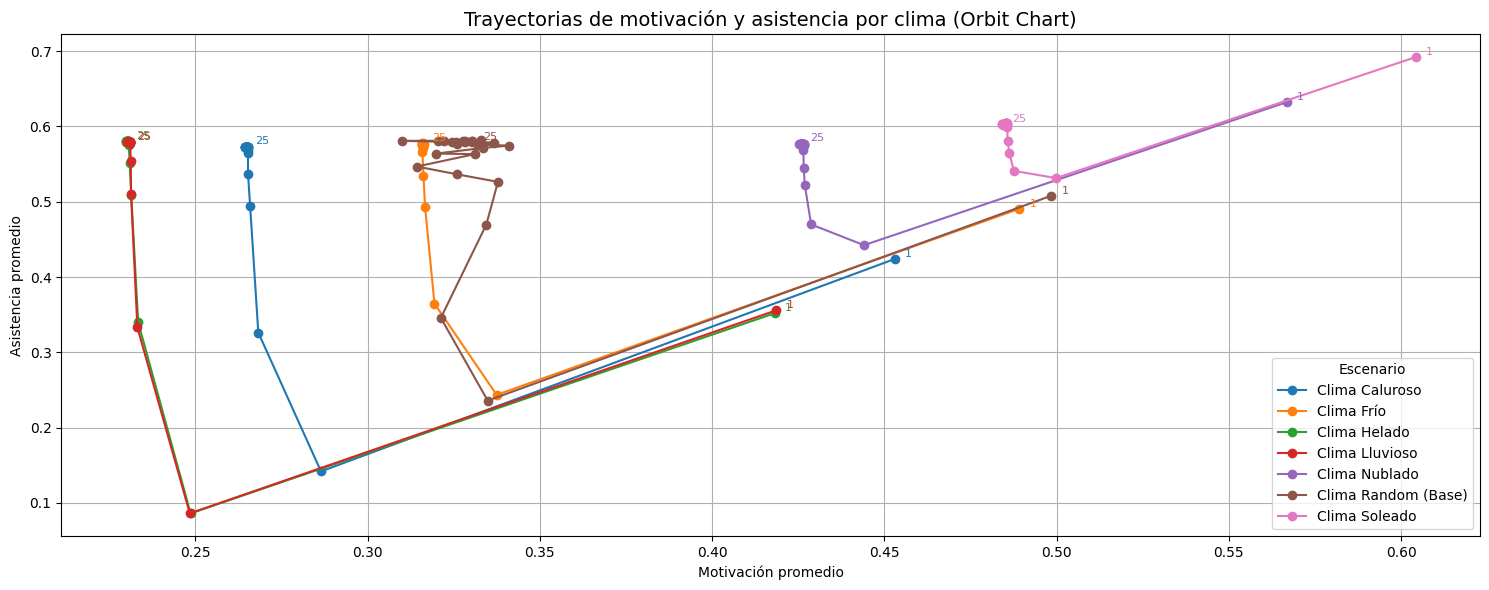

In [ ]:
# Gráfico Orbit Chart para los resultados por semana y escenario
plt.figure(figsize=(15, 6))

# Paleta de colores por escenario
palette = sns.color_palette("tab10", len(df_semanal_clima["escenario"].unique()))

# Orbit chart: línea por escenario
for i, (escenario, grupo) in enumerate(df_semanal_clima.groupby("escenario")):
    grupo_sorted = grupo.sort_values("semana")
    plt.plot(grupo_sorted["motivacion"], grupo_sorted["asistencia"],
             marker="o", label=escenario, color=palette[i])

    # Agregar número de semana en cada punto para ver la semana correspondiente
    for _, row in grupo_sorted.iterrows():
        if row["semana"] in [1, 25]:
            plt.text(row["motivacion"] + 0.003, row["asistencia"] + 0.003,
                    str(row["semana"]), fontsize=8, color=palette[i])

plt.title("Trayectorias de motivación y asistencia por clima (Orbit Chart)", fontsize=14)
plt.xlabel("Motivación promedio")
plt.ylabel("Asistencia promedio")
plt.legend(title="Escenario")
plt.grid(True)
plt.autoscale(enable=True, axis='both', tight=False)
plt.tight_layout()
plt.show()


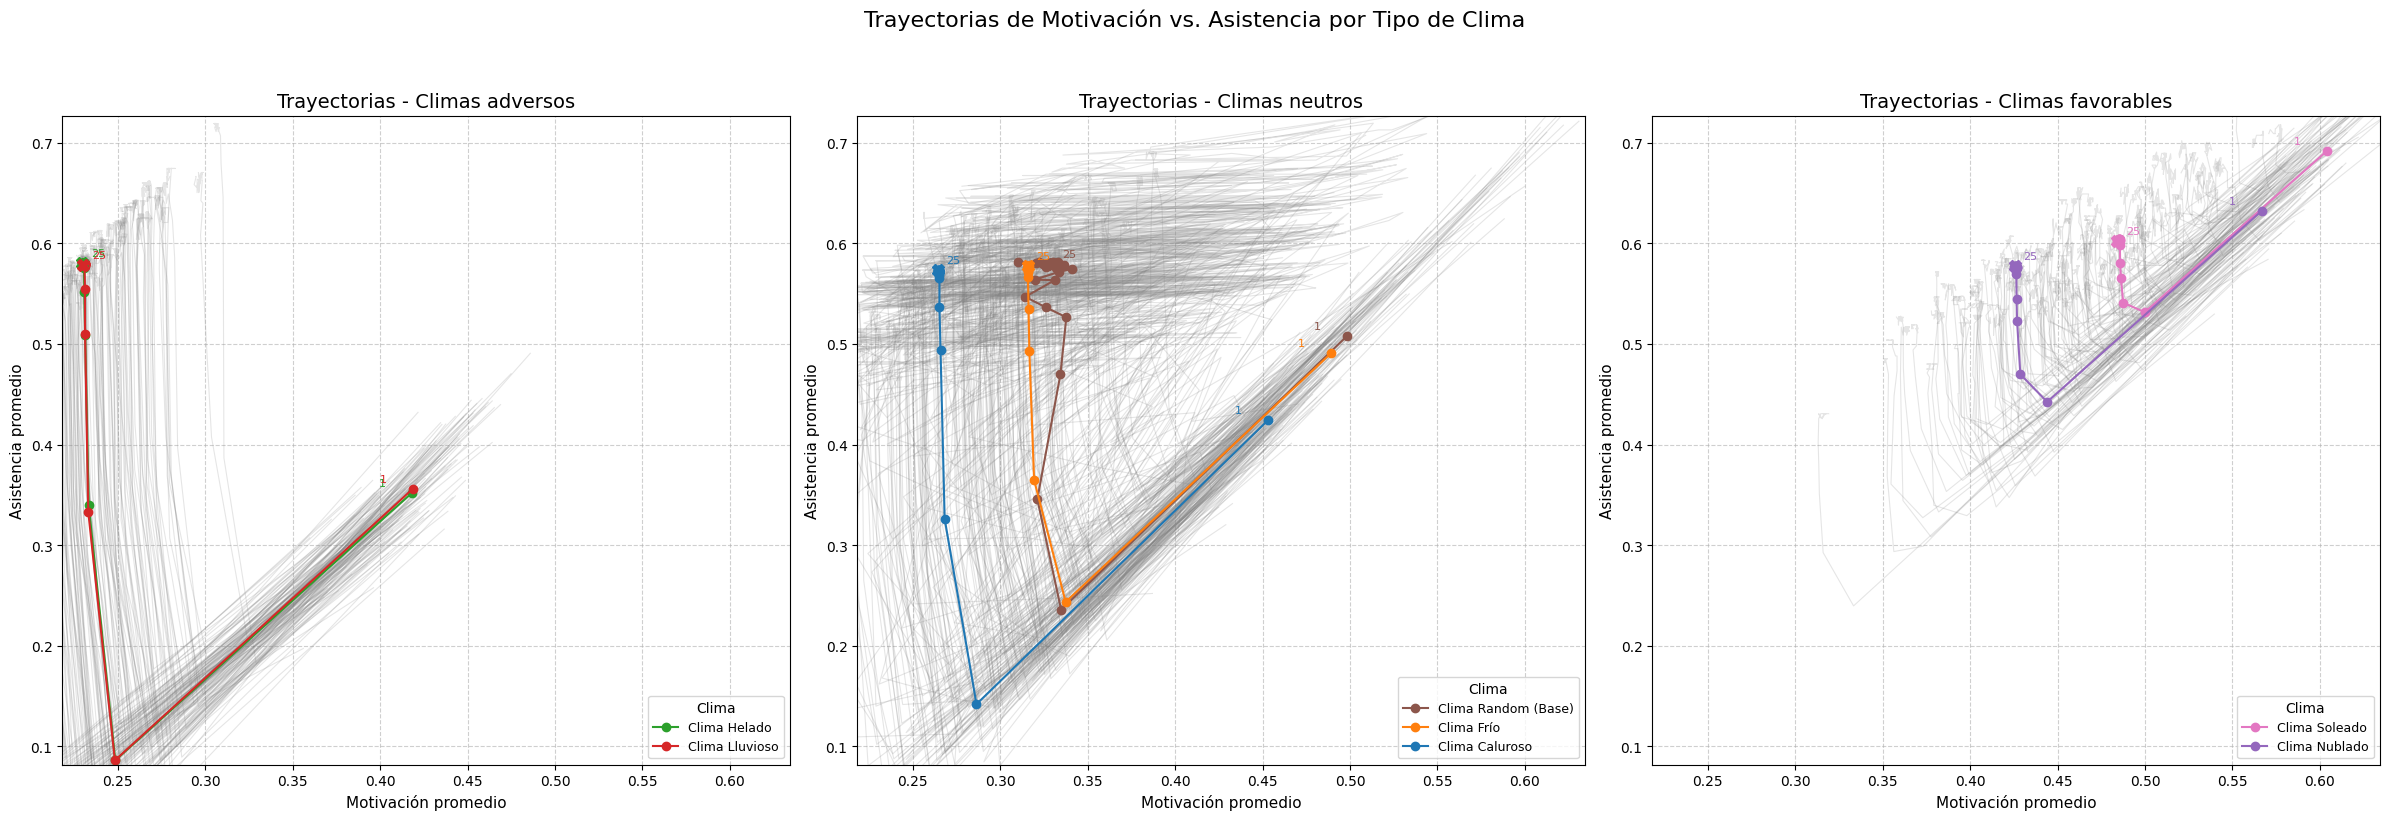

In [ ]:
# Crear grupos para los climas
grupo_bajo = ["Clima Helado", "Clima Lluvioso"]
grupo_medio = ["Clima Random (Base)", "Clima Frío", "Clima Caluroso"]
grupo_alto = ["Clima Soleado", "Clima Nublado"]

grupos = {
    "Climas adversos": grupo_bajo,
    "Climas neutros": grupo_medio, 
    "Climas favorables": grupo_alto,
}

# Calcular los límites globales de los ejes 
min_mot = df_semanal_clima["motivacion"].min()
max_mot = df_semanal_clima["motivacion"].max()
min_asi = df_semanal_clima["asistencia"].min()
max_asi = df_semanal_clima["asistencia"].max()

# Ajusta los límites para dejar un pequeño margen y redondear
global_xlim = (min_mot * 0.95, max_mot * 1.05)
global_ylim = (min_asi * 0.95, max_asi * 1.05)

# Obtener la paleta de colores consistente para todos los escenarios
all_scenarios = df_semanal_clima["escenario"].unique()
palette_colors = sns.color_palette("tab10", len(all_scenarios))
# Crear un mapeo de escenario a color para asegurar consistencia
color_map = {scenario: palette_colors[i] for i, scenario in enumerate(all_scenarios)}

# La figura combinada con subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
for i, (nombre_grupo, escenarios) in enumerate(grupos.items()):
    ax = axes[i]

    # 1) Pinto cada trayectoria individual en gris y con alpha
    for escenario in escenarios:
        for run in df_semanal_clima_detalle[df_semanal_clima_detalle["escenario"] == escenario]["run"].unique():
            serie = df_semanal_clima_detalle[
                (df_semanal_clima_detalle["escenario"] == escenario) &
                (df_semanal_clima_detalle["run"] == run)
            ].sort_values("semana")
            ax.plot(
                serie["motivacion"], serie["asistencia"],
                color="gray", alpha=0.2, linewidth=0.8
            )

    # 2) Pinto encima la media en color consistente
    for escenario in escenarios:
        serie_med = df_semanal_clima[df_semanal_clima["escenario"] == escenario].sort_values("semana")
        color = color_map[escenario]
        ax.plot(
            serie_med["motivacion"], serie_med["asistencia"],
            marker="o", label=escenario,
            color=color, linewidth=1.5, markersize=6
        )
        for _, row in serie_med.iterrows():
            if row["semana"] in [1, 25]:
                x_off = 0.005 if row["semana"] == 25 else -0.015
                y_off = 0.005
                ha = 'left' if row["semana"] == 25 else 'right'
                ax.text(
                    row["motivacion"] + x_off, row["asistencia"] + y_off,
                    str(row["semana"]), fontsize=8, color=color, ha=ha, va='bottom'
                )
            if row["semana"] == 25:
                ax.plot(
                    row["motivacion"], row["asistencia"],
                    marker="X", markersize=9, color=color,
                    zorder=5, linestyle='none'
                )

    # Resto de estilos: títulos, límites, grid, leyenda…
    ax.set_title(f"Trayectorias - {nombre_grupo}", fontsize=14)
    ax.set_xlim(global_xlim); ax.set_ylim(global_ylim)
    ax.set_xlabel("Motivación promedio", fontsize=11)
    ax.set_ylabel("Asistencia promedio", fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(title="Clima", loc="lower right", fontsize=9, title_fontsize=10)

fig.suptitle("Trayectorias de Motivación vs. Asistencia por Tipo de Clima", fontsize=16, y=1.02)
plt.tight_layout(rect=[0,0,1,0.98])
plt.show()

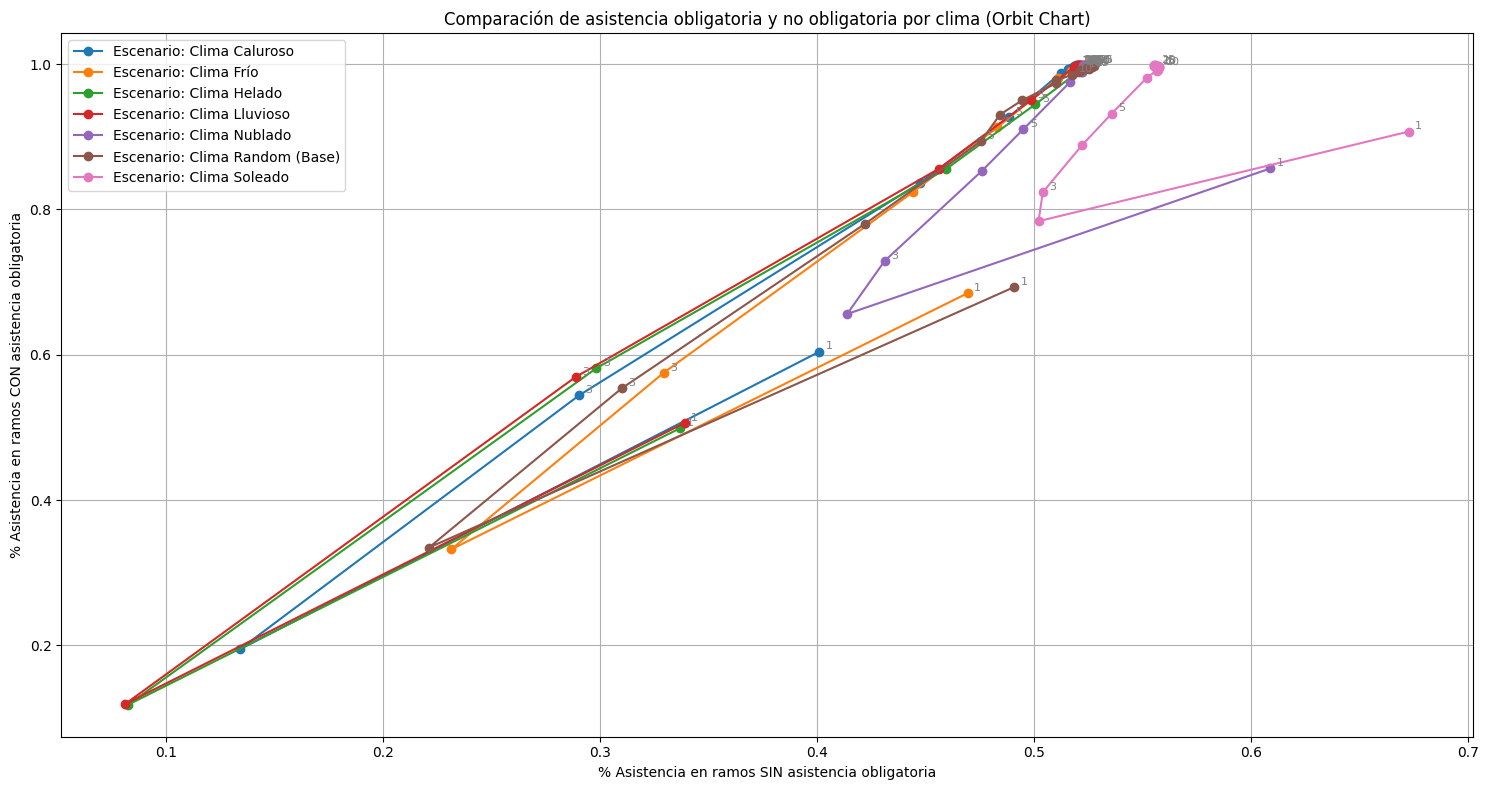

In [16]:
# Orbit Chart: Asistencia obligatoria vs no obligatoria por semana
plt.figure(figsize=(15, 8))

escenarios = df_semanal_clima["escenario"].unique()

palette = sns.color_palette("tab10", len(escenarios))

for i, escenario in enumerate(escenarios):
    subset = df_semanal_clima[df_semanal_clima["escenario"] == escenario]
    plt.plot(
        subset["% Asistencia no obligatoria"],
        subset["% Asistencia obligatoria"],
        marker="o",
        label=f"Escenario: {escenario}",
        color=palette[i]
    )
    # Agregar las semanas en los puntos
    for i, row in subset.iterrows():
        if row["semana"] in [1,3, 5, 10, 15, 20, 25]:
            plt.text(
                row["% Asistencia no obligatoria"] + 0.003,
                row["% Asistencia obligatoria"] + 0.003,
                str(row["semana"]),
                fontsize=8,
                color="gray"
            )

plt.xlabel("% Asistencia en ramos SIN asistencia obligatoria")
plt.ylabel("% Asistencia en ramos CON asistencia obligatoria")
plt.title("Comparación de asistencia obligatoria y no obligatoria por clima (Orbit Chart)")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Obligación

In [19]:
# Escenarios de probabilidad de obligatoriedad para comparar diferentes niveles de ramos obligatorios
obligation_scenarios = [
    {"name": "Base", "prob_mandatory": 0.35},
    {"name": "Ninguna obligatoria", "prob_mandatory": 0.0},
    {"name": "Pocas obligatorias",  "prob_mandatory": 0.25},
    {"name": "Mitad obligatorias",  "prob_mandatory": 0.5},
    {"name": "Muchas obligatorias", "prob_mandatory": 0.75},
    {"name": "Todas obligatorias",  "prob_mandatory": 1.0},
]

# Definimos los parámetros base para cada escenario de obligatoriedad
dfs = []
for esc in obligation_scenarios:
    base_params = {
        "num_students": 50,
        "prob_mandatory": [esc["prob_mandatory"]],
        "personal_weight": [0.5],
        "social_weight": [0.3],
        "external_weight": [0.2],
        "weather_type": ["random"],
        "min_credits": 21,
        "max_credits": 39,
    }
    df = ejecutar_escenario(esc["name"], base_params)
    dfs.append(df)

# Concatenar todos
resultados_comparativos_obligatoriedad = pd.concat(dfs, ignore_index=True)


Ejecutando escenario: Base


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Ninguna obligatoria


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Pocas obligatorias


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Mitad obligatorias


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Muchas obligatorias


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Todas obligatorias


  0%|          | 0/75 [00:00<?, ?it/s]

In [20]:
resultados_comparativos_obligatoriedad.head()

RunId  iteration  Step  num_students  prob_mandatory  personal_weight  \
0      0          0     0            50            0.35              0.5   
1      0          0     0            50            0.35              0.5   
2      0          0     0            50            0.35              0.5   
3      0          0     0            50            0.35              0.5   
4      0          0     0            50            0.35              0.5   

   social_weight  external_weight weather_type  min_credits  ...  \
0            0.3              0.2       random           21  ...   
1            0.3              0.2       random           21  ...   
2            0.3              0.2       random           21  ...   
3            0.3              0.2       random           21  ...   
4            0.3              0.2       random           21  ...   

   Attendance Rate  Attendance  Reasons Count Reasons Effect Count Motivation  \
0              1.0          50             {}                   {}   0.839416   
1              1.0          50             {}                   {}   0.839416   
2              1.0          50             {}                   {}   0.839416   
3              1.0          50             {}                   {}   0.839416   
4              1.0          50             {}                   {}   0.839416   

   Weather AgentID  Attends Class  \
0   random       1           True   
1   random       2           True   
2   random       3           True   
3   random       4           True   
4   random       5           True   

                                           Week Data Escenario  
0  [{'week': 1, 'days': [{'day': 'mon', 'attended...      Base  
1  [{'week': 1, 'days': [{'day': 'mon', 'attended...      Base  
2  [{'week': 1, 'days': [{'day': 'mon', 'attended...      Base  
3  [{'week': 1, 'days': [{'day': 'mon', 'attended...      Base  
4  [{'week': 1, 'days': [{'day': 'mon', 'attended...      Base  

[5 rows x 21 columns]

In [21]:
# Procesar los resultados de los escenarios de obligatoriedad
df_resultados_obligatoriedad = procesar_resultados(resultados_comparativos_obligatoriedad)
df_resultados_obligatoriedad


Escenario  Motivación promedio  Asistencia promedio  \
0                  Base             0.373879             0.565538   
1                  Base             0.324339             0.439692   
2                  Base             0.307654             0.500000   
3                  Base             0.273418             0.419385   
4                  Base             0.346498             0.504154   
..                  ...                  ...                  ...   
445  Todas obligatorias             0.586988             0.877846   
446  Todas obligatorias             0.636263             0.854462   
447  Todas obligatorias             0.566837             0.876000   
448  Todas obligatorias             0.623065             0.889231   
449  Todas obligatorias             0.625930             0.856923   

     Asistencia obligatoria  Asistencia no obligatoria  % Asistencia total  \
0                  0.863077                   0.823077            0.651945   
1                  0.709231                   0.627692            0.565775   
2                  0.898462                   0.796923            0.621313   
3                  0.740769                   0.736154            0.489172   
4                  0.840000                   0.783846            0.598847   
..                      ...                        ...                 ...   
445                0.990000                   0.000000            0.959776   
446                0.989231                   0.000000            0.959806   
447                0.987692                   0.000000            0.953995   
448                0.991538                   0.000000            0.963659   
449                0.991538                   0.000000            0.962021   

     % Asistencia obligatoria  % Asistencia no obligatoria  Créditos promedio  \
0                    0.832185                     0.545366              34.80   
1                    0.686636                     0.447306              29.64   
2                    0.862238                     0.464912              33.66   
3                    0.716706                     0.377588              29.76   
4                    0.809975                     0.479949              30.54   
..                        ...                          ...                ...   
445                  0.959776                     0.000000              33.24   
446                  0.959806                     0.000000              31.38   
447                  0.953995                     0.000000              34.14   
448                  0.963659                     0.000000              34.02   
449                  0.962021                     0.000000              31.74   

     Ramos obligatorios  Ramos electivos  \
0                  1.96             3.26   
1                  1.56             2.88   
2                  1.98             3.40   
3                  1.38             3.14   
4                  1.84             2.88   
..                  ...              ...   
445                5.20             0.00   
446                4.84             0.00   
447                5.08             0.00   
448                5.38             0.00   
449                4.96             0.00   

                                               Razones  \
0    {'Desgaste': 0.014595959595959593, 'Desmotivac...   
1    {'Desgaste': 0.013015873015873014, 'Desmotivac...   
2    {'Desgaste': 0.004615384615384616, 'Desmotivac...   
3    {'Desgaste': 0.0022222222222222222, 'Desmotiva...   
4    {'Desgaste': 0.010666666666666666, 'Desmotivac...   
..                                                 ...   
445  {'Desgaste': 0.13442929292929293, 'Desmotivaci...   
446  {'Desgaste': 0.23017094017094017, 'Desmotivaci...   
447  {'Desgaste': 0.08938888888888888, 'Desmotivaci...   
448  {'Desgaste': 0.2515318586642116, 'Desmotivació...   
449  {'Desgaste': 0.23531024531024528, 'Desmotivaci...   

                                    Razones domin

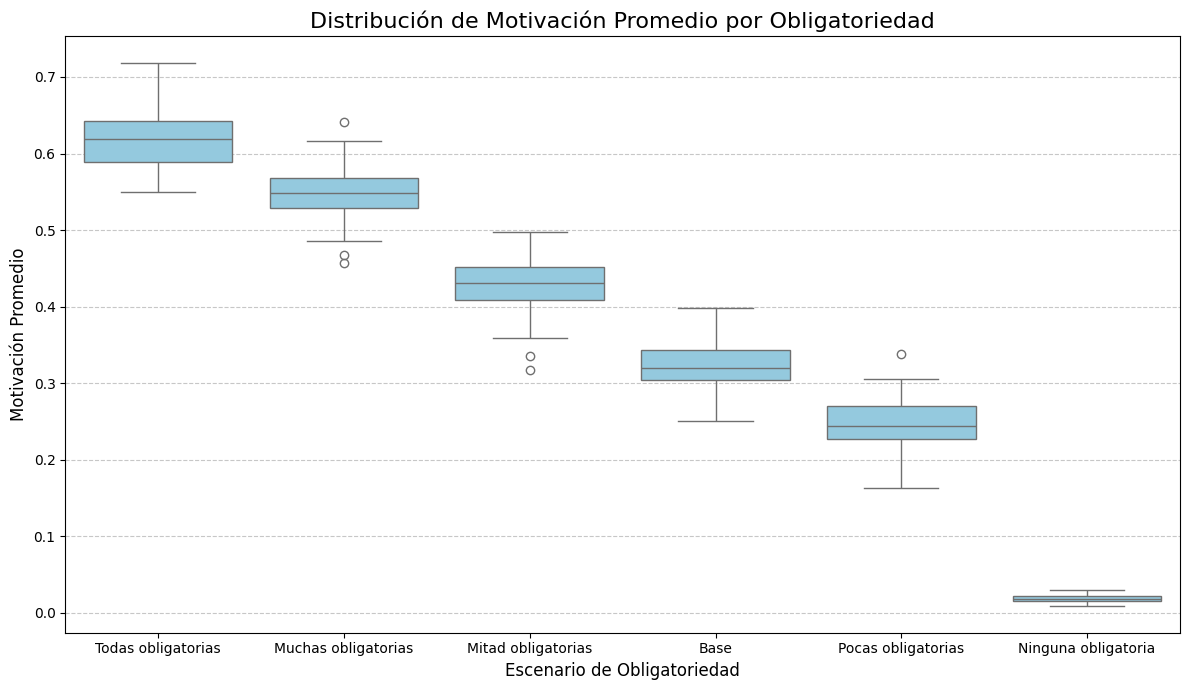

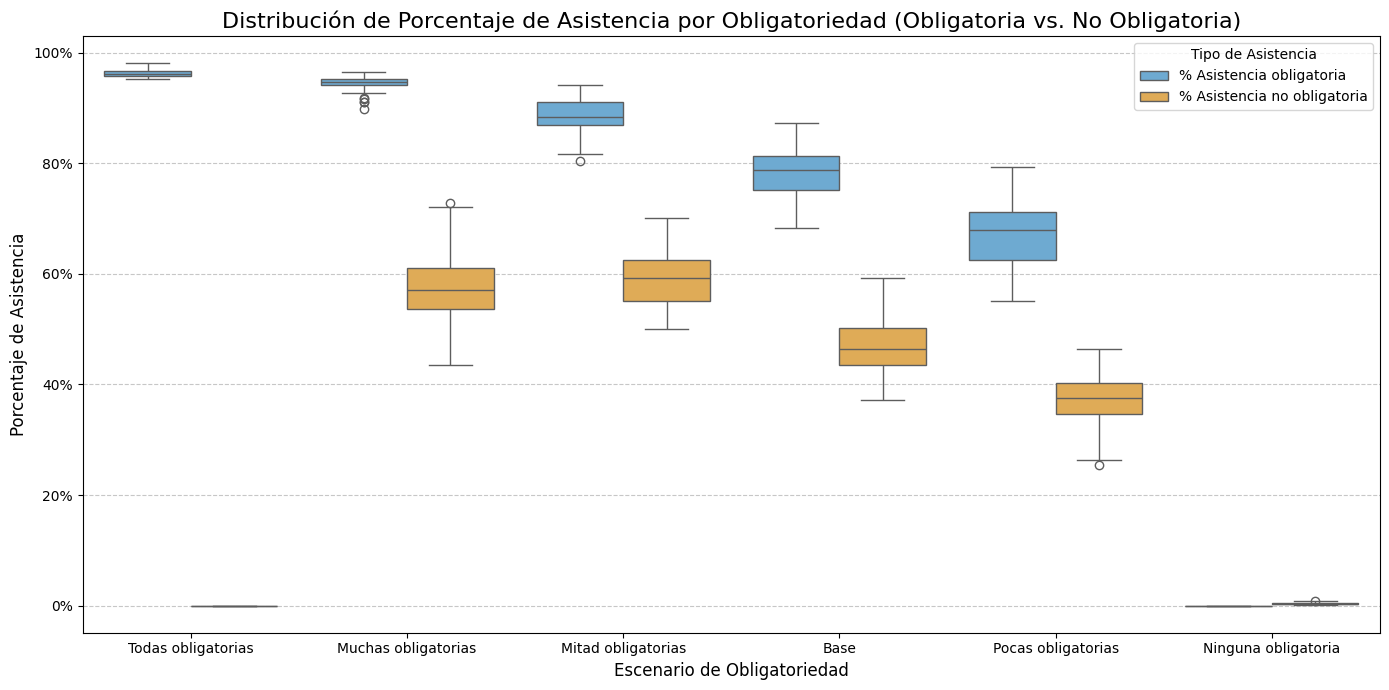

In [ ]:
# Gráfico de cajas para comparar motivación y asistencia por escenario de obligatoriedad

orden_obligatoriodad = ["Todas obligatorias", "Muchas obligatorias", "Mitad obligatorias", "Base", "Pocas obligatorias", "Ninguna obligatoria"]

# Gráfico 1: Motivación Promedio por obligatoriedad
plt.figure(figsize=(12, 7)) 

sns.boxplot(x="Escenario", y="Motivación promedio", data=df_resultados_obligatoriedad, order=orden_obligatoriodad, color="#87CEEB")

plt.title("Distribución de Motivación Promedio por Obligatoriedad", fontsize=16)
plt.xlabel("Escenario de Obligatoriedad", fontsize=12)
plt.ylabel("Motivación Promedio", fontsize=12)
#plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show() 

# Gráfico 2: Asistencia Obligatoria vs. No Obligatoria por obligatoriedad

df_asistencia_melted = df_resultados_obligatoriedad.melt(
    id_vars=['Escenario'],
    value_vars=['% Asistencia obligatoria', '% Asistencia no obligatoria'],
    var_name='Tipo de Asistencia',
    value_name='Porcentaje de Asistencia'
)

# Definir colores para los tipos de asistencia
colors_asistencia = {
    '% Asistencia obligatoria': '#5DADE2',
    '% Asistencia no obligatoria': '#F5B041'
}

plt.figure(figsize=(14, 7)) 

ax = sns.boxplot(
    x="Escenario",
    y="Porcentaje de Asistencia",
    hue="Tipo de Asistencia", 
    data=df_asistencia_melted,
    order=orden_obligatoriodad,
    palette=colors_asistencia 
)

plt.title("Distribución de Porcentaje de Asistencia por Obligatoriedad (Obligatoria vs. No Obligatoria)", fontsize=16)
plt.xlabel("Escenario de Obligatoriedad", fontsize=12)
plt.ylabel("Porcentaje de Asistencia", fontsize=12)
#plt.xticks(rotation=45, ha='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0)) 
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.legend(title="Tipo de Asistencia") 
plt.tight_layout()
plt.show()


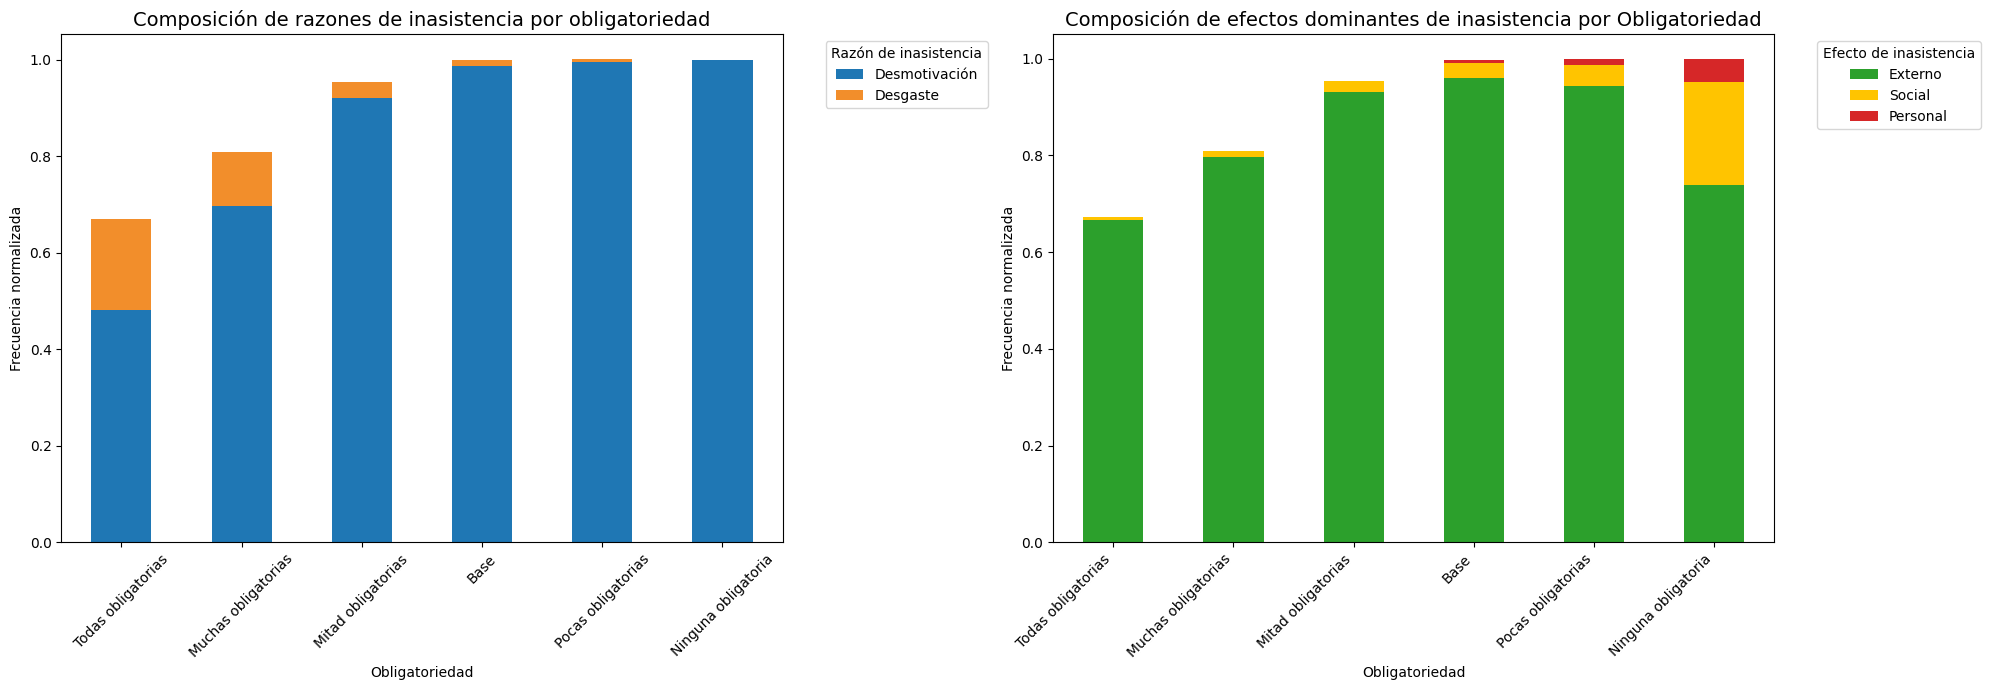

In [ ]:
# Expandimos las razones a columnas
df_razones = df_resultados_obligatoriedad[["Escenario", "Razones"]].copy()
razones_expandido = df_razones["Razones"].apply(pd.Series)
df_razones_expandido = pd.concat([df_razones["Escenario"], razones_expandido], axis=1)

# Agrupar por obligatoriedad y sacar promedio por razón
df_reasons_avg = df_razones_expandido.groupby("Escenario").mean().fillna(0).T

# Ordenar las columnas de acuerdo a la obligatoriedad 
orden_obligatoriodad = ["Todas obligatorias", "Muchas obligatorias", "Mitad obligatorias", "Base", "Pocas obligatorias", "Ninguna obligatoria"]
df_reasons_avg = df_reasons_avg[orden_obligatoriodad if all(c in df_reasons_avg.columns for c in orden_obligatoriodad) else df_reasons_avg.columns]

df_reasons_effect = df_resultados_obligatoriedad[["Escenario", "Razones dominantes"]].copy()
reasons_effect_expandido = df_reasons_effect["Razones dominantes"].apply(pd.Series)
df_reasons_effect_expandido = pd.concat([df_reasons_effect["Escenario"], reasons_effect_expandido], axis=1)
df_reasons_effect_avg = df_reasons_effect_expandido.groupby("Escenario").mean().fillna(0).T

clim_orden_reasons_effect = [c for c in orden_obligatoriodad if c in df_reasons_effect_avg.columns]
df_reasons_effect_avg = df_reasons_effect_avg[clim_orden_reasons_effect]

# Reordenar razones promedio (de mayor a menor para cada escenario)
df_reasons_avg = df_reasons_avg.sort_values(by=df_reasons_avg.columns.tolist(), ascending=False)

# Reordenar efectos promedio (también de mayor a menor)
df_reasons_effect_avg = df_reasons_effect_avg.sort_values(by=df_reasons_effect_avg.columns.tolist(), ascending=False)


# Crear gráfico de barras apiladas
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Título y ejes
colors_for_reasons = ['#1f77b4','#F28E2B']
df_reasons_avg.T.plot(kind="bar", stacked=True, ax=axes[0], color=colors_for_reasons)
axes[0].set_title("Composición de razones de inasistencia por obligatoriedad", fontsize=14)
axes[0].set_ylabel("Frecuencia normalizada")
axes[0].set_xlabel("Obligatoriedad")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].legend(title="Razón de inasistencia", bbox_to_anchor=(1.05, 1), loc='upper left')

colors_for_effects = [ '#2CA02C', "#FFC400", '#d62728']
df_reasons_effect_avg.T.plot(kind="bar", stacked=True, ax=axes[1], color=colors_for_effects)
axes[1].set_title("Composición de efectos dominantes de inasistencia por Obligatoriedad", fontsize=14)
axes[1].set_ylabel("Frecuencia normalizada")
axes[1].set_xlabel("Obligatoriedad")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].legend(title="Efecto de inasistencia", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()

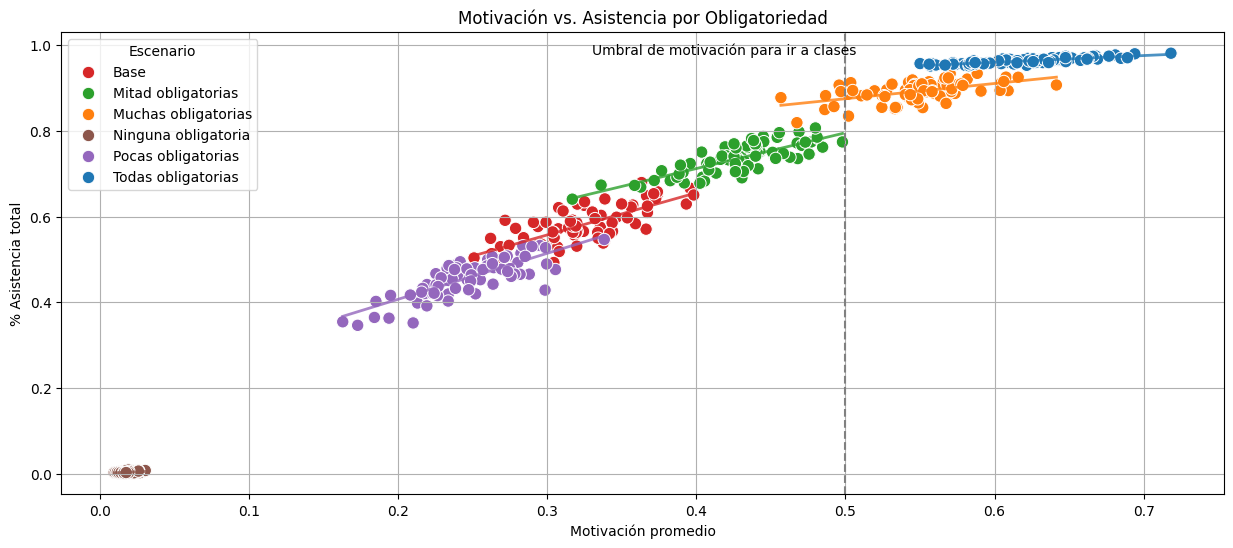

In [ ]:
# Gráfico de dispersión de motivación promedio vs asistencia total por escenario de obligatoriedad
plt.figure(figsize=(15, 6))

# Definir colores para cada escenario
colores_escenarios = sns.color_palette("tab10", n_colors=len(orden_obligatoriodad))
mapa_colores = dict(zip(orden_obligatoriodad, colores_escenarios))

sns.scatterplot(
    x="Motivación promedio",
    y="% Asistencia total",
    hue="Escenario",
    data=df_resultados_obligatoriedad,
    s=80,
    palette=mapa_colores,
)

for i, escenario in enumerate(orden_obligatoriodad):
    # Filtra los datos para el escenario actual
    df_temp = df_resultados_obligatoriedad[df_resultados_obligatoriedad["Escenario"] == escenario]

    sns.regplot(
        x="Motivación promedio",
        y="% Asistencia total",
        data=df_temp,
        scatter=False,
        color=mapa_colores[escenario],
        line_kws={'linewidth': 2, 'alpha': 0.8},
        ci=None
    )

# Línea vertical en el umbral de motivación 0.5
plt.axvline(x=0.5, color="gray", linestyle="--", linewidth=1.5)
plt.text(0.33, plt.ylim()[1] * 0.95, "Umbral de motivación para ir a clases", color="black")

plt.title("Motivación vs. Asistencia por Obligatoriedad")
plt.xlabel("Motivación promedio")
plt.ylabel("% Asistencia total")
plt.grid(True)
plt.legend(title="Escenario")
plt.show()


In [132]:
# Procesar los resultados para el gráfico de Orbit Chart semanal
df_semanal_obligatoriedad_detalle, df_semanal_obligatoriedad = procesar_resultados_para_orbit_chart(resultados_comparativos_obligatoriedad)


In [133]:
df_semanal_obligatoriedad_detalle

escenario  run  semana  motivacion  asistencia  % obligatoria  \
0                    Base    0       1    0.613098    0.720333       0.728889   
1                    Base    0       2    0.482912    0.537000       0.560000   
2                    Base    0       3    0.312210    0.201000       0.208889   
3                    Base    0       4    0.260676    0.261000       0.271111   
4                    Base    0       5    0.258846    0.521667       0.555556   
...                   ...  ...     ...         ...         ...            ...   
11695  Todas obligatorias   74      22    0.603229    1.000000       0.892000   
11696  Todas obligatorias   74      23    0.698574    0.992000       0.884000   
11697  Todas obligatorias   74      24    0.605834    0.988000       0.880000   
11698  Todas obligatorias   74      25    0.585545    1.000000       0.892000   
11699  Todas obligatorias   74      26    0.519065    0.983000       0.876000   

       % no obligatoria  
0              0.677551  
1              0.497959  
2              0.191837  
3              0.240816  
4              0.497959  
...                 ...  
11695          0.000000  
11696          0.000000  
11697          0.000000  
11698          0.000000  
11699          0.000000  

[11700 rows x 7 columns]

In [134]:
df_semanal_obligatoriedad

escenario  semana  motivacion  asistencia  % obligatoria  \
0                  Base       1    0.493923    0.499156       0.504483   
1                  Base       2    0.335978    0.245209       0.254180   
2                  Base       3    0.304540    0.319520       0.343014   
3                  Base       4    0.297924    0.432667       0.463430   
4                  Base       5    0.308665    0.494951       0.529095   
..                  ...     ...         ...         ...            ...   
151  Todas obligatorias      22    0.626400    0.991138       0.903360   
152  Todas obligatorias      23    0.621585    0.990324       0.902667   
153  Todas obligatorias      24    0.603567    0.988289       0.900693   
154  Todas obligatorias      25    0.608520    0.990013       0.902507   
155  Todas obligatorias      26    0.610088    0.990738       0.903040   

     % no obligatoria  
0            0.442342  
1            0.213967  
2            0.287642  
3            0.390428  
4            0.446658  
..                ...  
151          0.000000  
152          0.000000  
153          0.000000  
154          0.000000  
155          0.000000  

[156 rows x 6 columns]

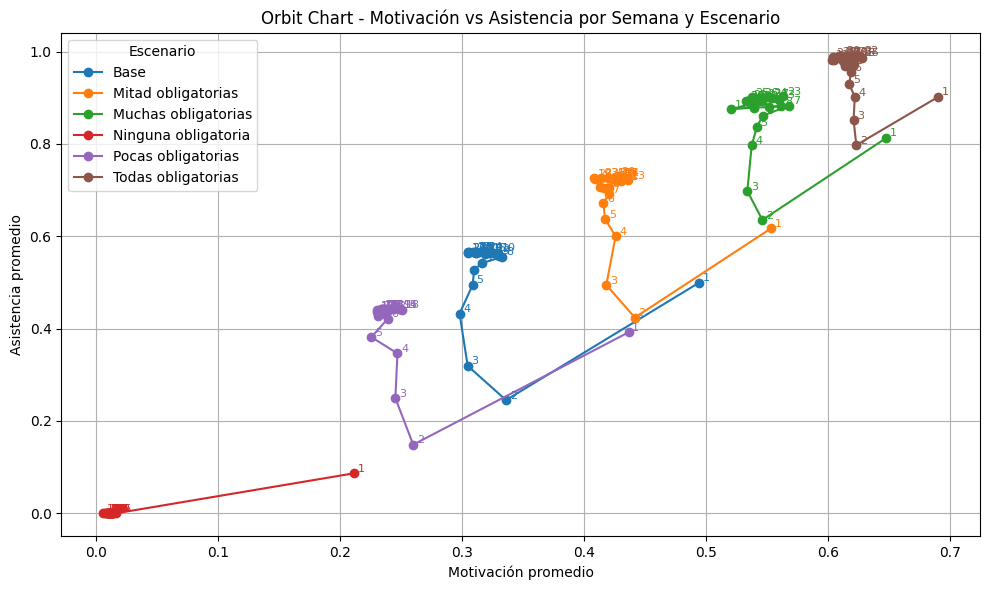

In [26]:
# Gráfico Orbit Chart para los resultados por semana y escenario
plt.figure(figsize=(10, 6))

# Paleta de colores por escenario
palette = sns.color_palette("tab10", len(df_semanal_obligatoriedad["escenario"].unique()))

# Orbit chart: línea por escenario
for i, (escenario, grupo) in enumerate(df_semanal_obligatoriedad.groupby("escenario")):
    grupo_sorted = grupo.sort_values("semana")
    plt.plot(grupo_sorted["motivacion"], grupo_sorted["asistencia"],
             marker="o", label=escenario, color=palette[i])

    # Agregar número de semana en cada punto para ver la semana correspondiente
    for _, row in grupo_sorted.iterrows():
        plt.text(row["motivacion"] + 0.003, row["asistencia"] + 0.003,
                 str(row["semana"]), fontsize=8, color=palette[i])

plt.title("Orbit Chart - Motivación vs Asistencia por Semana y Escenario")
plt.xlabel("Motivación promedio")
plt.ylabel("Asistencia promedio")
plt.legend(title="Escenario")
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.autoscale(enable=True, axis='both', tight=False)
plt.tight_layout()
plt.show()


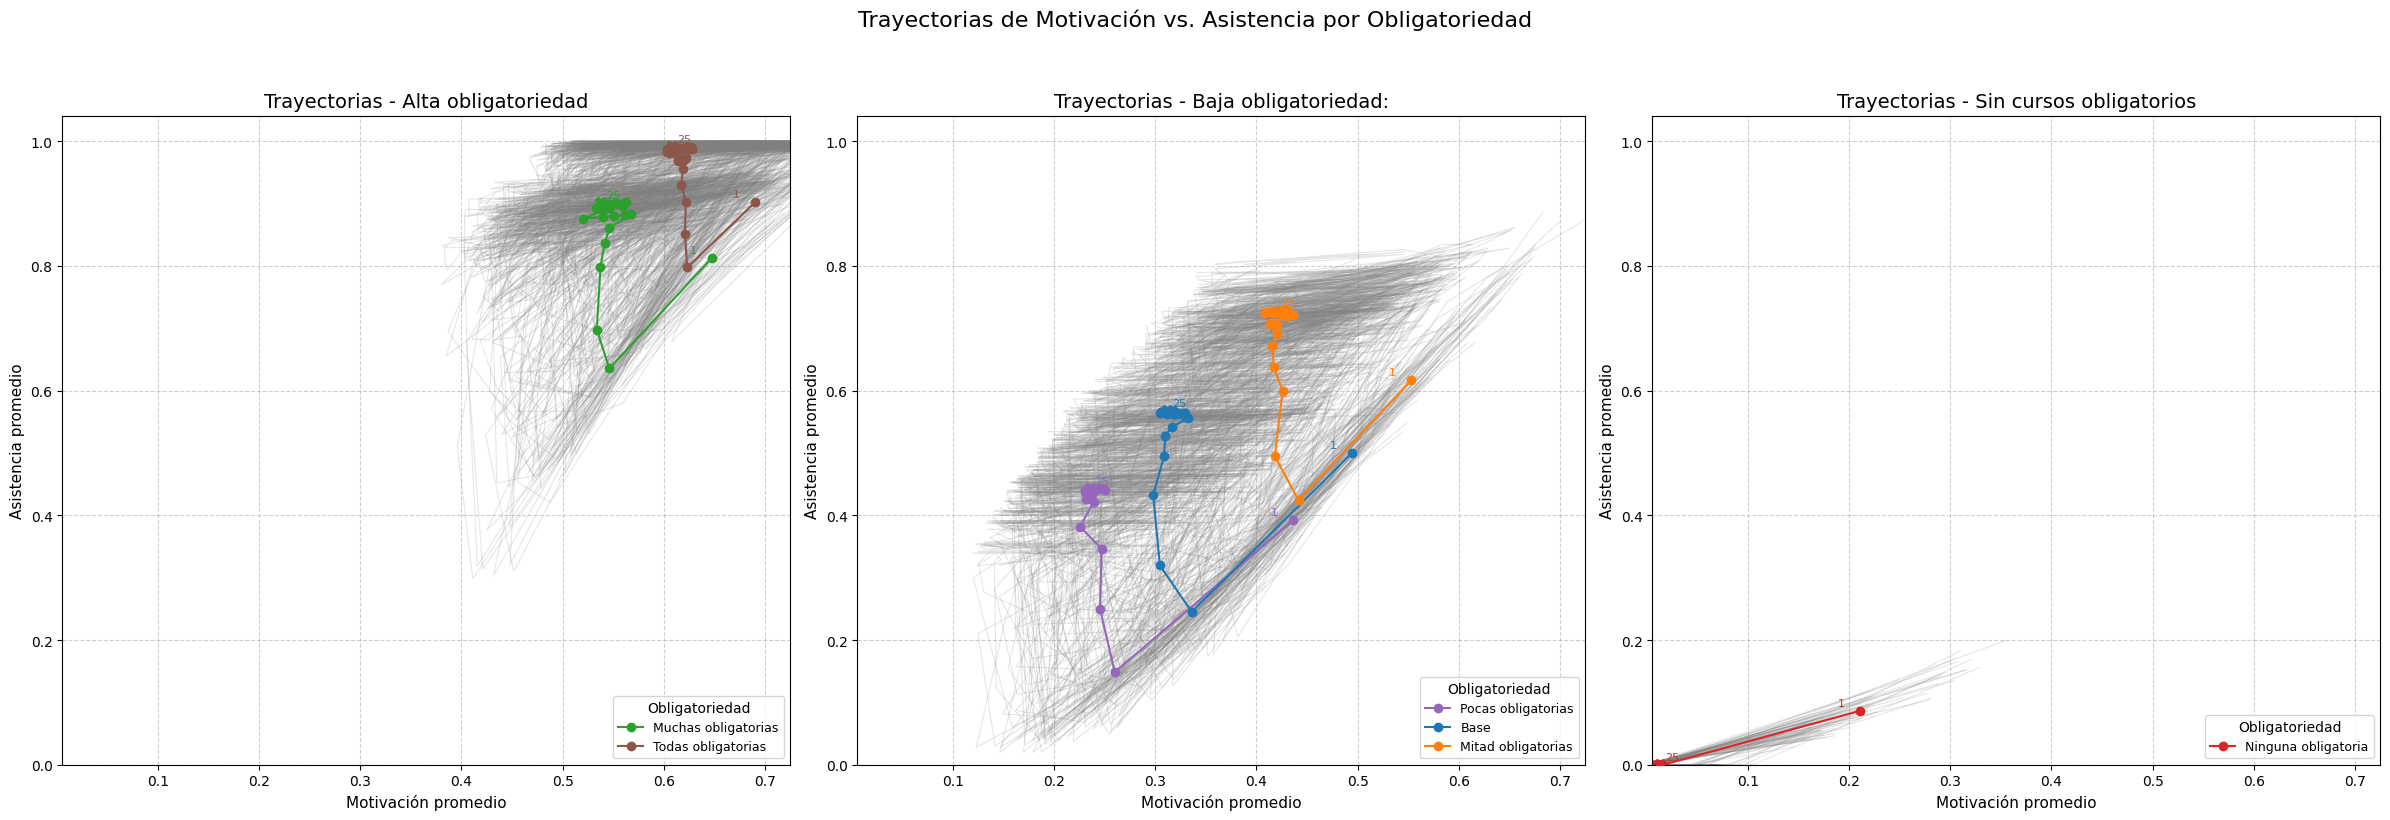

In [ ]:
# Crear grupos 
grupo_bajo = ["Ninguna obligatoria"]
grupo_medio = ["Pocas obligatorias", "Base", "Mitad obligatorias"]
grupo_alto = ["Muchas obligatorias", "Todas obligatorias"]

grupos = {
    "Alta obligatoriedad": grupo_alto,
    "Baja obligatoriedad:": grupo_medio,
    "Sin cursos obligatorios": grupo_bajo,
}

# Calcular los límites globales de los ejes 
min_mot = df_semanal_obligatoriedad["motivacion"].min()
max_mot = df_semanal_obligatoriedad["motivacion"].max()
min_asi = df_semanal_obligatoriedad["asistencia"].min()
max_asi = df_semanal_obligatoriedad["asistencia"].max()

# Ajusta los límites para dejar un pequeño margen y redondear
global_xlim = (min_mot * 0.95, max_mot * 1.05)
global_ylim = (min_asi * 0.95, max_asi * 1.05)

# La figura combinada con subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8)) 
axes = axes.flatten() 

# Obtener la paleta de colores consistente para todos los escenarios
all_scenarios = df_semanal_obligatoriedad["escenario"].unique()
palette_colors = sns.color_palette("tab10", len(all_scenarios))
# Crear un mapeo de escenario a color para asegurar consistencia
color_map = {scenario: palette_colors[i] for i, scenario in enumerate(all_scenarios)}

# Dibujar las trayectorias de motivación vs asistencia por clima
for i, (nombre_grupo, escenarios) in enumerate(grupos.items()):
    ax = axes[i] 

    # 1) Pinto cada trayectoria individual en gris y con alpha
    for escenario in escenarios:
        for run in df_semanal_obligatoriedad_detalle[df_semanal_obligatoriedad_detalle["escenario"] == escenario]["run"].unique():
            serie = df_semanal_obligatoriedad_detalle[
                (df_semanal_obligatoriedad_detalle["escenario"] == escenario) &
                (df_semanal_obligatoriedad_detalle["run"] == run)
            ].sort_values("semana")
            ax.plot(
                serie["motivacion"], serie["asistencia"],
                color="gray", alpha=0.2, linewidth=0.8
            )

    # 2) Pinto encima la media en color consistente
    for escenario in escenarios:
        grupo = df_semanal_obligatoriedad[df_semanal_obligatoriedad["escenario"] == escenario]
        grupo_sorted = grupo.sort_values("semana")
        
        # Usa el mapeo de color para obtener el color correcto y consistente
        line_color = color_map[escenario]
        
        ax.plot(grupo_sorted["motivacion"], grupo_sorted["asistencia"],
                marker="o", label=escenario, color=line_color, linewidth=1.5, markersize=6)

        for _, row in grupo_sorted.iterrows():
            if row["semana"] in [1, 25]:
                x_offset = 0.005 if row["semana"] == 25 else -0.015 
                y_offset = 0.005        
                ha = 'left' if row["semana"] == 25 else 'right'
                ax.text(row["motivacion"] + x_offset, row["asistencia"] + y_offset,
                        str(row["semana"]), fontsize=8, color=line_color, ha=ha, va='bottom')
            
            # Distintibo para la semana 25
            if row["semana"] == 25:
                ax.plot(row["motivacion"], row["asistencia"],
                        marker="X", markersize=9, color=line_color, zorder=5, linestyle='none') # Marcador 'X' más grande

    # Título y etiquetas al subplot
    ax.set_title(f"Trayectorias - {nombre_grupo}", fontsize=14) 
    ax.set_xlabel("Motivación promedio", fontsize=11)
    ax.set_ylabel("Asistencia promedio", fontsize=11)
    

    ax.set_xlim(global_xlim)
    ax.set_ylim(global_ylim)
    ax.grid(True, linestyle="--", alpha=0.6) 
    ax.legend(title="Obligatoriedad", loc="lower right", fontsize=9, title_fontsize=10) 

# Título general de la figura
fig.suptitle("Trayectorias de Motivación vs. Asistencia por Obligatoriedad", fontsize=16, y=1.02) 

plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()

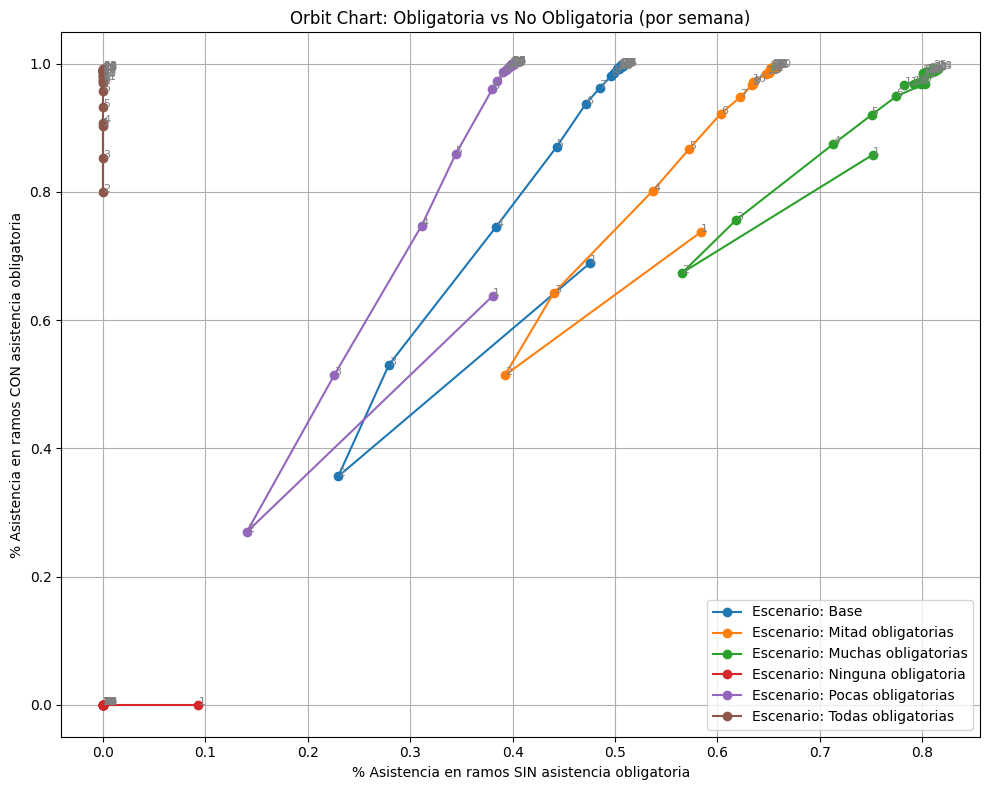

In [29]:
# Orbit Chart: Asistencia obligatoria vs no obligatoria por semana
plt.figure(figsize=(10, 8))

escenarios = df_semanal_obligatoriedad["escenario"].unique()

for escenario in escenarios:
    subset = df_semanal_obligatoriedad[df_semanal_obligatoriedad["escenario"] == escenario]
    plt.plot(
        subset["% Asistencia no obligatoria"],
        subset["% Asistencia obligatoria"],
        marker="o",
        label=f"Escenario: {escenario}"
    )
    # Agregar las semanas en los puntos
    for i, row in subset.iterrows():
        plt.text(
            row["% Asistencia no obligatoria"],
            row["% Asistencia obligatoria"],
            str(row["semana"]),
            fontsize=8,
            color="gray"
        )

plt.xlabel("% Asistencia en ramos SIN asistencia obligatoria")
plt.ylabel("% Asistencia en ramos CON asistencia obligatoria")
plt.title("Orbit Chart: Obligatoria vs No Obligatoria (por semana)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Peso motivacional del modelo

In [30]:
# Escenarios de motivación para comparar diferentes configuraciones de pesos de motivación
motivation_weight_scenarios = [
    {"name": "Base",                "personal_weight": 0.5,  "social_weight": 0.3,  "external_weight": 0.2},
    {"name": "Personal dominante",  "personal_weight": 1.0,  "social_weight": 0.0,  "external_weight": 0.0},
    {"name": "Social dominante",    "personal_weight": 0.0,  "social_weight": 1.0,  "external_weight": 0.0},
    {"name": "Externo dominante",   "personal_weight": 0.0,  "social_weight": 0.0,  "external_weight": 1.0},
    {"name": "Balanceado",          "personal_weight": 0.34, "social_weight": 0.33, "external_weight": 0.33},
    {"name": "Personal + Social",   "personal_weight": 0.6,  "social_weight": 0.4,  "external_weight": 0.0},
    {"name": "Personal + Externo",  "personal_weight": 0.7,  "social_weight": 0.0,  "external_weight": 0.3},
    {"name": "Social + Externo",   "personal_weight": 0.0,  "social_weight": 0.6,  "external_weight": 0.4},
]

# Definimos los parámetros base para cada escenario de motivación
dfs = []
for esc in motivation_weight_scenarios:
    base_params = {
        "num_students": 50,
        "prob_mandatory": [0.6],
        "personal_weight": [esc["personal_weight"]],
        "social_weight": [esc["social_weight"]],
        "external_weight": [esc["external_weight"]],
        "weather_type": ["random"],
        "min_credits": 21,
        "max_credits": 39,
        "network_k": [4],
        "network_p": [0.3],
    }
    df = ejecutar_escenario(esc["name"], base_params)
    dfs.append(df)

# Concatenar todos
resultados_comparativos_weight = pd.concat(dfs, ignore_index=True)


Ejecutando escenario: Base


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Personal dominante


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Social dominante


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Externo dominante


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Balanceado


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Personal + Social


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Personal + Externo


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Social + Externo


  0%|          | 0/75 [00:00<?, ?it/s]

In [31]:
resultados_comparativos_weight.head()

RunId  iteration  Step  num_students  prob_mandatory  personal_weight  \
0      0          0     0            50             0.6              0.5   
1      0          0     0            50             0.6              0.5   
2      0          0     0            50             0.6              0.5   
3      0          0     0            50             0.6              0.5   
4      0          0     0            50             0.6              0.5   

   social_weight  external_weight weather_type  min_credits  ...  \
0            0.3              0.2       random           21  ...   
1            0.3              0.2       random           21  ...   
2            0.3              0.2       random           21  ...   
3            0.3              0.2       random           21  ...   
4            0.3              0.2       random           21  ...   

   Attendance Rate  Attendance  Reasons Count  Reasons Effect Count  \
0              1.0          50             {}                    {}   
1              1.0          50             {}                    {}   
2              1.0          50             {}                    {}   
3              1.0          50             {}                    {}   
4              1.0          50             {}                    {}   

   Motivation Weather AgentID  Attends Class  \
0    0.853531  random       1           True   
1    0.853531  random       2           True   
2    0.853531  random       3           True   
3    0.853531  random       4           True   
4    0.853531  random       5           True   

                                           Week Data  Escenario  
0  [{'week': 1, 'days': [{'day': 'mon', 'attended...       Base  
1  [{'week': 1, 'days': [{'day': 'mon', 'attended...       Base  
2  [{'week': 1, 'days': [{'day': 'mon', 'attended...       Base  
3  [{'week': 1, 'days': [{'day': 'mon', 'attended...       Base  
4  [{'week': 1, 'days': [{'day': 'mon', 'attended...       Base  

[5 rows x 23 columns]

In [32]:
# Procesar los resultados de los escenarios de motivación
df_resultados_weight = procesar_resultados(resultados_comparativos_weight)
df_resultados_weight

Escenario  Motivación promedio  Asistencia promedio  \
0          Balanceado             0.349048             0.681077   
1          Balanceado             0.334468             0.661692   
2          Balanceado             0.300877             0.694923   
3          Balanceado             0.309387             0.680615   
4          Balanceado             0.337730             0.704154   
..                ...                  ...                  ...   
595  Social dominante             0.415703             0.738154   
596  Social dominante             0.444100             0.671538   
597  Social dominante             0.398612             0.703692   
598  Social dominante             0.443154             0.764923   
599  Social dominante             0.396747             0.634923   

     Asistencia obligatoria  Asistencia no obligatoria  % Asistencia total  \
0                  0.940769                   0.831538            0.778654   
1                  0.953846                   0.861538            0.781334   
2                  0.959231                   0.876154            0.795821   
3                  0.951538                   0.776154            0.801228   
4                  0.941538                   0.777692            0.818089   
..                      ...                        ...                 ...   
595                0.970769                   0.847692            0.871593   
596                0.953077                   0.734615            0.829585   
597                0.974615                   0.834615            0.824005   
598                0.976154                   0.913846            0.854790   
599                0.964615                   0.898462            0.774526   

     % Asistencia obligatoria  % Asistencia no obligatoria  Créditos promedio  \
0                    0.905456                     0.624694              33.12   
1                    0.910048                     0.609911              31.98   
2                    0.926016                     0.623646              33.54   
3                    0.910830                     0.569077              32.34   
4                    0.906550                     0.612129              32.58   
..                        ...                          ...                ...   
595                  0.944902                     0.689423              31.02   
596                  0.934255                     0.586911              30.84   
597                  0.949723                     0.607555              33.42   
598                  0.955341                     0.737115              34.44   
599                  0.941858                     0.621879              33.72   

     Ramos obligatorios  Ramos electivos  \
0                  2.80             2.12   
1                  2.82             2.02   
2                  3.04             2.10   
3                  2.98             1.88   
4                  3.20             1.76   
..                  ...              ...   
595                3.22             1.84   
596                2.94             1.66   
597                2.96             2.02   
598                2.92             2.08   
599                2.74             2.26   

                                               Razones  \
0    {'Desgaste': 0.03139907478142771, 'Desmotivaci...   
1    {'Desgaste': 0.009494949494949495, 'Desmotivac...   
2    {'Desgaste': 0.031002997002997006, 'Desmotivac...   
3    {'Desgaste': 0.02043745143745144, 'Desmotivaci...   
4    {'Desgaste': 0.025264790764790764, 'Desmotivac...   
..                                                 ...   
595  {'Desgaste': 0.059898989898989896, 'Desmotivac...   
596  {'Desgaste': 0.04515151515151516, 'Desmotivaci...   
597  {'Desgaste': 0.026222222222222223, 'Desmotivac...   
598  {'Desgaste': 0.10622222222222222, 'Desmotivaci...   
599  {'Desgaste': 0.08977272727272727, 'Desmotivaci...   

                                    Razones dominantes  
0    {'Persona

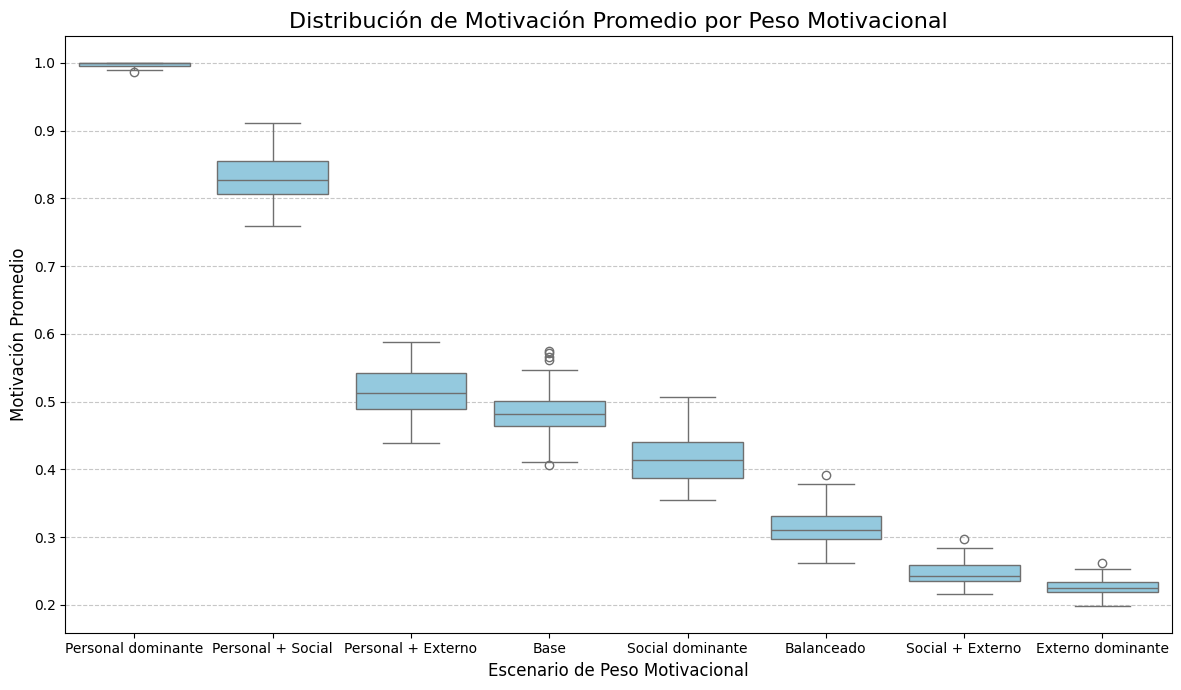

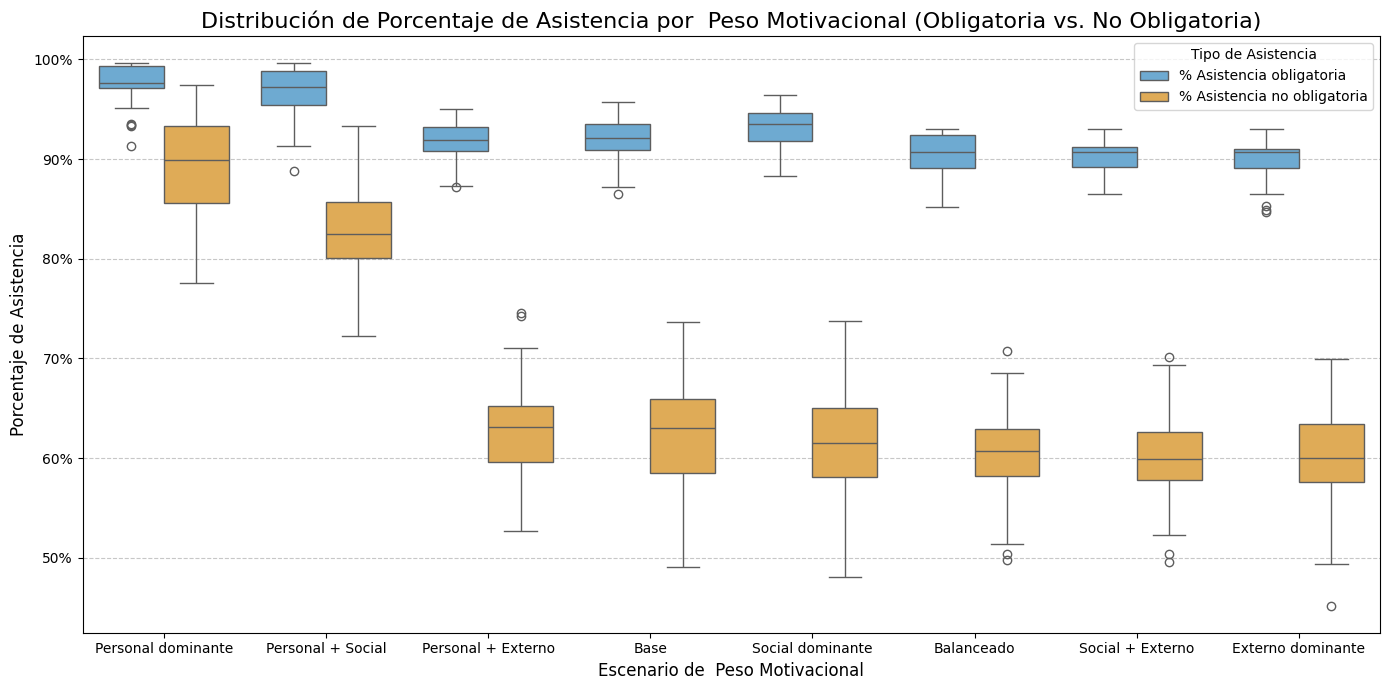

In [ ]:
# Gráfico de cajas para comparar motivación y asistencia por escenario de peso motivacional
orden_pesos =  ["Personal dominante", "Personal + Social", "Personal + Externo", "Base", "Social dominante", "Balanceado", "Social + Externo", "Externo dominante"]

# Gráfico 1: Motivación Promedio por tipo de clima  
plt.figure(figsize=(12, 7)) 

sns.boxplot(x="Escenario", y="Motivación promedio", data=df_resultados_weight, order=orden_pesos, color="#87CEEB")

plt.title("Distribución de Motivación Promedio por Peso Motivacional", fontsize=16)
plt.xlabel("Escenario de Peso Motivacional", fontsize=12)
plt.ylabel("Motivación Promedio", fontsize=12)
#plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show() 

# Gráfico 2: Asistencia Obligatoria vs. No Obligatoria por Carga Académica 

df_asistencia_melted = df_resultados_weight.melt(
    id_vars=['Escenario'],
    value_vars=['% Asistencia obligatoria', '% Asistencia no obligatoria'],
    var_name='Tipo de Asistencia',
    value_name='Porcentaje de Asistencia'
)

# Definir colores para los tipos de asistencia
colors_asistencia = {
    '% Asistencia obligatoria': '#5DADE2',
    '% Asistencia no obligatoria': '#F5B041'
}

plt.figure(figsize=(14, 7))

ax = sns.boxplot(
    x="Escenario",
    y="Porcentaje de Asistencia",
    hue="Tipo de Asistencia",
    data=df_asistencia_melted,
    order=orden_pesos,
    palette=colors_asistencia
)


plt.title("Distribución de Porcentaje de Asistencia por  Peso Motivacional (Obligatoria vs. No Obligatoria)", fontsize=16)
plt.xlabel("Escenario de  Peso Motivacional", fontsize=12)
plt.ylabel("Porcentaje de Asistencia", fontsize=12)
#plt.xticks(rotation=45, ha='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0)) 
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.legend(title="Tipo de Asistencia") 
plt.tight_layout()
plt.show()


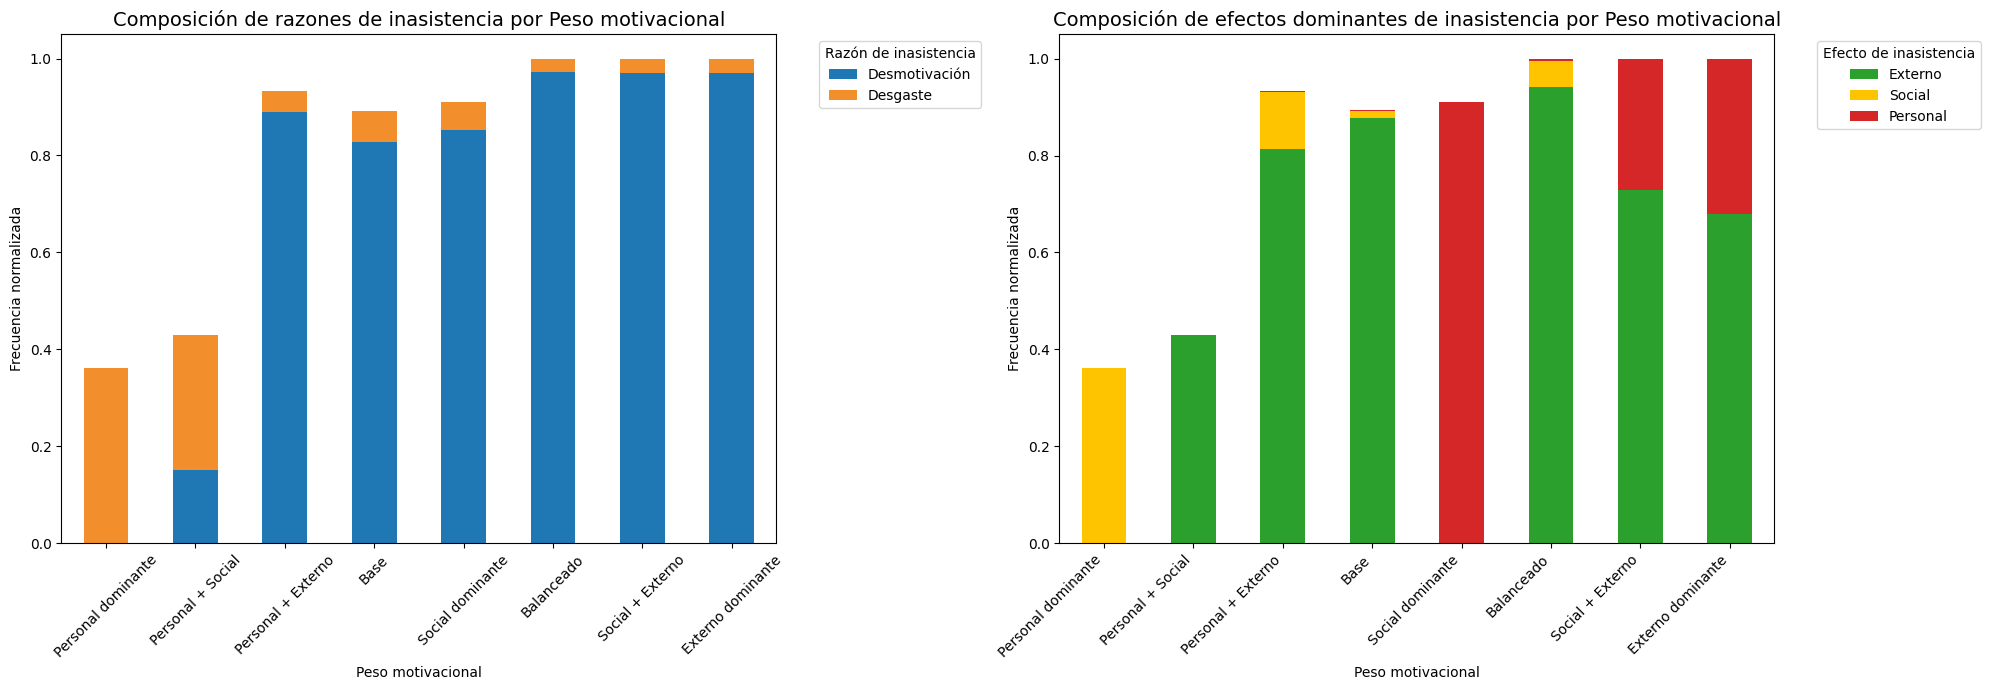

In [ ]:
# Expandimos las razones a columnas
df_razones = df_resultados_weight[["Escenario", "Razones"]].copy()
razones_expandido = df_razones["Razones"].apply(pd.Series)
df_razones_expandido = pd.concat([df_razones["Escenario"], razones_expandido], axis=1)

# Agrupar por clima y sacar promedio por razón
df_reasons_avg = df_razones_expandido.groupby("Escenario").mean().T

# Ordenar pesos motivacionales 
orden_pesos =  ["Personal dominante", "Personal + Social", "Personal + Externo", "Base", "Social dominante", "Balanceado", "Social + Externo", "Externo dominante"]
df_reasons_avg = df_reasons_avg[orden_pesos if all(c in df_reasons_avg.columns for c in orden_pesos) else df_reasons_avg.columns]

# Expandir las razones dominantes a columnas
df_reasons_effect = df_resultados_weight[["Escenario", "Razones dominantes"]].copy()
reasons_effect_expandido = df_reasons_effect["Razones dominantes"].apply(pd.Series)
df_reasons_effect_expandido = pd.concat([df_reasons_effect["Escenario"], reasons_effect_expandido], axis=1)
df_reasons_effect_avg = df_reasons_effect_expandido.groupby("Escenario").mean().fillna(0).T

clim_orden_reasons_effect = [c for c in orden_pesos if c in df_reasons_effect_avg.columns]
df_reasons_effect_avg = df_reasons_effect_avg[clim_orden_reasons_effect]

# Reordenar razones promedio (de mayor a menor para cada escenario)
orden_personalizado = ["Desmotivación", "Desgaste"] 
df_reasons_avg = df_reasons_avg.loc[orden_personalizado]

# Reordenar efectos promedio (también de mayor a menor)
orden_personalizado = ["Externo", "Social", "Personal"] 
df_reasons_effect_avg = df_reasons_effect_avg.loc[orden_personalizado]

# Crear gráfico de barras apiladas
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Título y ejes
colors_for_reasons = ['#1f77b4','#F28E2B']
df_reasons_avg.T.plot(kind="bar", stacked=True, ax=axes[0], color=colors_for_reasons)
axes[0].set_title("Composición de razones de inasistencia por Peso motivacional", fontsize=14)
axes[0].set_ylabel("Frecuencia normalizada")
axes[0].set_xlabel("Peso motivacional")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].legend(title="Razón de inasistencia", bbox_to_anchor=(1.05, 1), loc='upper left')

colors_for_effects = [ '#2CA02C', "#FFC400", '#d62728']
df_reasons_effect_avg.T.plot(kind="bar", stacked=True, ax=axes[1], color=colors_for_effects)
axes[1].set_title("Composición de efectos dominantes de inasistencia por Peso motivacional", fontsize=14)
axes[1].set_ylabel("Frecuencia normalizada")
axes[1].set_xlabel("Peso motivacional")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].legend(title="Efecto de inasistencia", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()

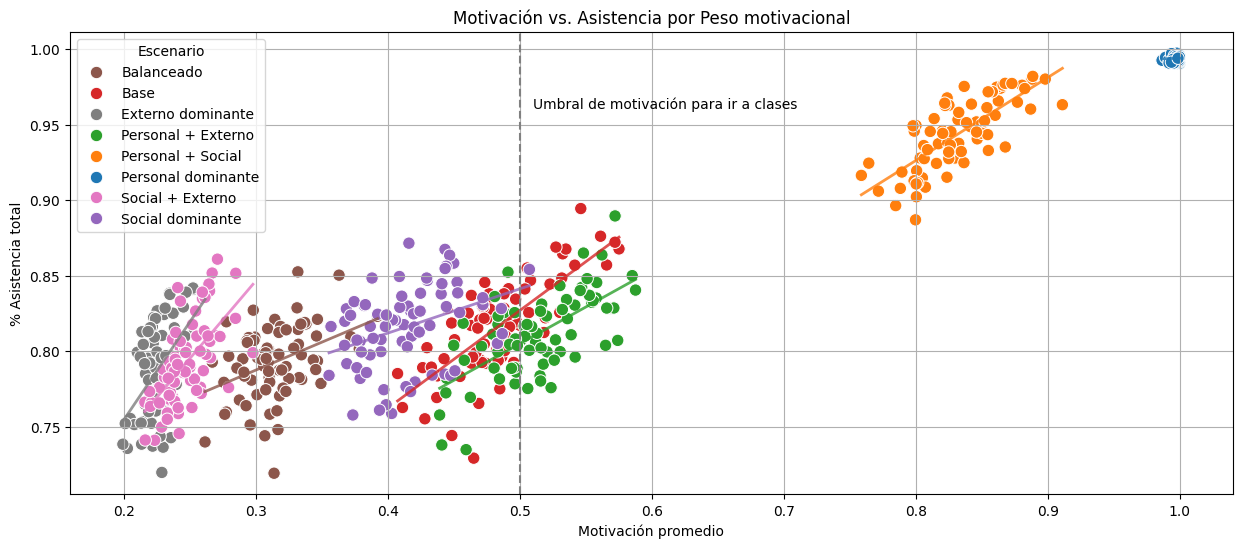

In [ ]:
# Gráfico de dispersión de motivación promedio vs asistencia total por escenario de peso motivacional
plt.figure(figsize=(15, 6))

colores_escenarios = sns.color_palette("tab10", n_colors=len(orden_pesos))
mapa_colores = dict(zip(orden_pesos, colores_escenarios))

sns.scatterplot(
    x="Motivación promedio",
    y="% Asistencia total",
    hue="Escenario",
    data=df_resultados_weight,
    s=80,
    palette=mapa_colores,
)

for i, escenario in enumerate(orden_pesos):
    # Filtra los datos para el escenario actual
    df_temp = df_resultados_weight[df_resultados_weight["Escenario"] == escenario]

    sns.regplot(
        x="Motivación promedio",
        y="% Asistencia total",
        data=df_temp,
        scatter=False,
        color=mapa_colores[escenario],
        line_kws={'linewidth': 2, 'alpha': 0.8},
        ci=None
    )

# Línea vertical en el umbral de motivación 0.5
plt.axvline(x=0.5, color="gray", linestyle="--", linewidth=1.5)
plt.text(0.51, plt.ylim()[1] * 0.95, "Umbral de motivación para ir a clases", color="black")

plt.title("Motivación vs. Asistencia por Peso motivacional")
plt.xlabel("Motivación promedio")
plt.ylabel("% Asistencia total")
plt.grid(True)
plt.legend(title="Escenario")
plt.show()


In [137]:
# Procesar los resultados para el gráfico de Orbit Chart semanal
df_semanal_weight_detalle, df_semanal_weight = procesar_resultados_para_orbit_chart(resultados_comparativos_weight)

In [138]:
df_semanal_weight_detalle

escenario  run  semana  motivacion  asistencia  % obligatoria  \
0            Balanceado    0       1    0.516062    0.553000       0.497959   
1            Balanceado    0       2    0.250973    0.060000       0.061224   
2            Balanceado    0       3    0.245067    0.435333       0.404082   
3            Balanceado    0       4    0.396107    0.756000       0.697959   
4            Balanceado    0       5    0.245610    0.777000       0.718367   
...                 ...  ...     ...         ...         ...            ...   
15595  Social dominante   74      22    0.393124    0.746667       0.668000   
15596  Social dominante   74      23    0.390583    0.750667       0.672000   
15597  Social dominante   74      24    0.387658    0.734667       0.656000   
15598  Social dominante   74      25    0.394525    0.750667       0.672000   
15599  Social dominante   74      26    0.400986    0.746667       0.668000   

       % no obligatoria  
0              0.455319  
1              0.063830  
2              0.382979  
3              0.663830  
4              0.685106  
...                 ...  
15595          0.662500  
15596          0.666667  
15597          0.650000  
15598          0.666667  
15599          0.666667  

[15600 rows x 7 columns]

In [139]:
df_semanal_weight

escenario  semana  motivacion  asistencia  % obligatoria  \
0          Balanceado       1    0.403384    0.304360       0.279443   
1          Balanceado       2    0.313908    0.222142       0.207219   
2          Balanceado       3    0.324940    0.589529       0.550349   
3          Balanceado       4    0.310873    0.693889       0.646061   
4          Balanceado       5    0.323548    0.769893       0.716033   
..                ...     ...         ...         ...            ...   
203  Social dominante      22    0.410163    0.810093       0.740118   
204  Social dominante      23    0.410514    0.809142       0.739158   
205  Social dominante      24    0.410215    0.809129       0.738989   
206  Social dominante      25    0.410347    0.808876       0.738770   
207  Social dominante      26    0.409966    0.809236       0.739263   

     % no obligatoria  
0            0.266106  
1            0.192459  
2            0.522552  
3            0.616781  
4            0.685241  
..                ...  
203          0.712034  
204          0.710518  
205          0.710198  
206          0.710046  
207          0.710487  

[208 rows x 6 columns]

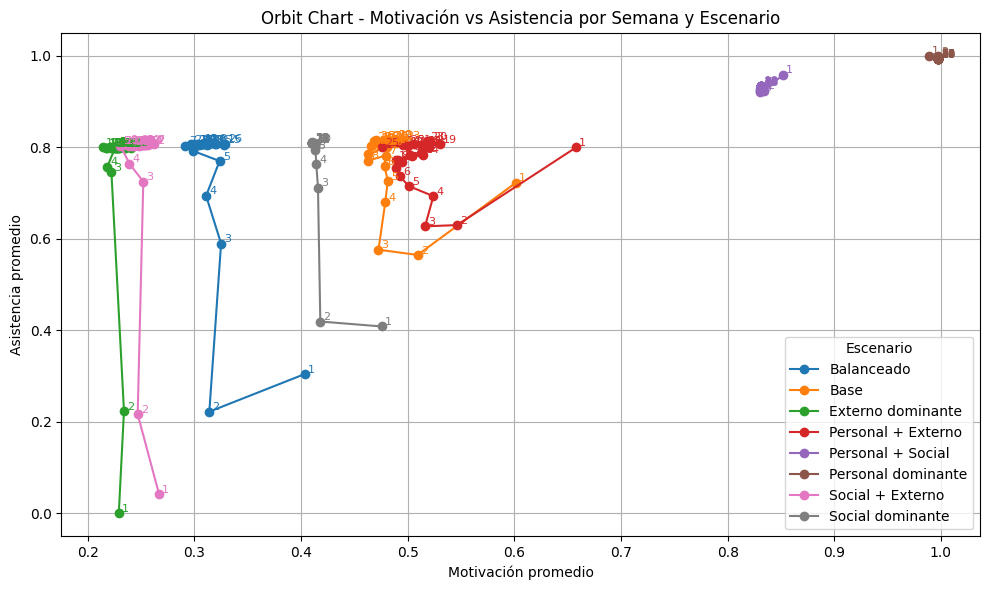

In [37]:
# Gráfico Orbit Chart para los resultados por semana y escenario
plt.figure(figsize=(10, 6))

# Paleta de colores por escenario
palette = sns.color_palette("tab10", len(df_semanal_weight["escenario"].unique()))

# Orbit chart: línea por escenario
for i, (escenario, grupo) in enumerate(df_semanal_weight.groupby("escenario")):
    grupo_sorted = grupo.sort_values("semana")
    plt.plot(grupo_sorted["motivacion"], grupo_sorted["asistencia"],
             marker="o", label=escenario, color=palette[i])

    # Agregar número de semana en cada punto para ver la semana correspondiente
    for _, row in grupo_sorted.iterrows():
        plt.text(row["motivacion"] + 0.003, row["asistencia"] + 0.003,
                 str(row["semana"]), fontsize=8, color=palette[i])

plt.title("Orbit Chart - Motivación vs Asistencia por Semana y Escenario")
plt.xlabel("Motivación promedio")
plt.ylabel("Asistencia promedio")
plt.legend(title="Escenario")
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.autoscale(enable=True, axis='both', tight=False)
plt.tight_layout()
plt.show()


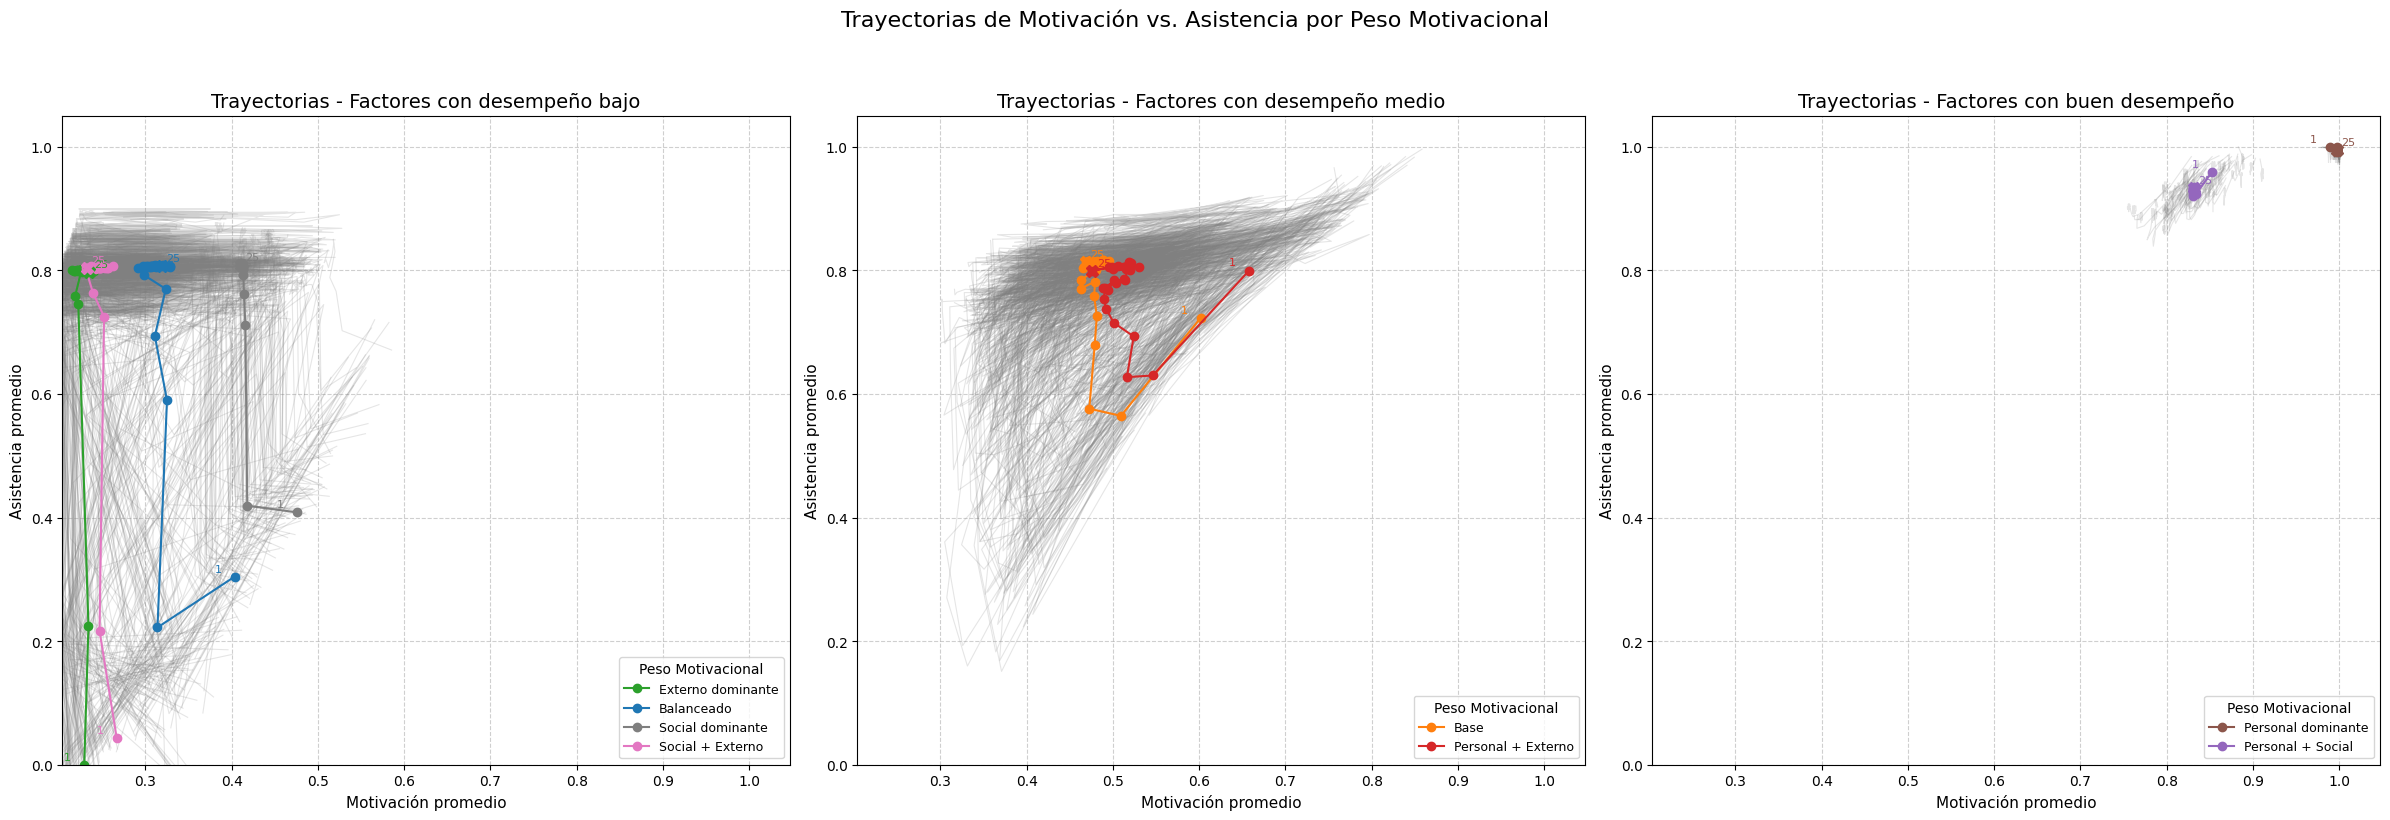

In [ ]:
# Crear grupos para los climas
grupo_bajo = ["Externo dominante", "Balanceado", "Social dominante", "Social + Externo"]
grupo_medio = [ "Base", "Personal + Externo"]
grupo_alto = ["Personal dominante", "Personal + Social"]

grupos = {
    "Factores con desempeño bajo": grupo_bajo,
    "Factores con desempeño medio": grupo_medio,
    "Factores con buen desempeño": grupo_alto,
}

# Se calcular los límites globales de los ejes 
min_mot = df_semanal_weight["motivacion"].min()
max_mot = df_semanal_weight["motivacion"].max()
min_asi = df_semanal_weight["asistencia"].min()
max_asi = df_semanal_weight["asistencia"].max()

# Límites para dejar un pequeño margen y redondear
global_xlim = (min_mot * 0.95, max_mot * 1.05)
global_ylim = (min_asi * 0.95, max_asi * 1.05)

# La figura combinada con subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8)) 
axes = axes.flatten() 

# Obtener la paleta de colores consistente para todos los escenarios
all_scenarios = df_semanal_weight["escenario"].unique()
palette_colors = sns.color_palette("tab10", len(all_scenarios))
# Crear un mapeo de escenario a color para asegurar consistencia
color_map = {scenario: palette_colors[i] for i, scenario in enumerate(all_scenarios)}

# Dibujar las trayectorias de motivación vs asistencia por clima
for i, (nombre_grupo, escenarios) in enumerate(grupos.items()):
    ax = axes[i] 

    # 1) Pinto cada trayectoria individual en gris y con alpha
    for escenario in escenarios:
        for run in df_semanal_weight_detalle[df_semanal_weight_detalle["escenario"] == escenario]["run"].unique():
            serie = df_semanal_weight_detalle[
                (df_semanal_weight_detalle["escenario"] == escenario) &
                (df_semanal_weight_detalle["run"] == run)
            ].sort_values("semana")
            ax.plot(
                serie["motivacion"], serie["asistencia"],
                color="gray", alpha=0.2, linewidth=0.8
            )

    # 2) Pinto encima la media en color consistente
    
    for escenario in escenarios:
        grupo = df_semanal_weight[df_semanal_weight["escenario"] == escenario]
        grupo_sorted = grupo.sort_values("semana")
        
        # Usa el mapeo de color para obtener el color correcto y consistente
        line_color = color_map[escenario]
        
        ax.plot(grupo_sorted["motivacion"], grupo_sorted["asistencia"],
                marker="o", label=escenario, color=line_color, linewidth=1.5, markersize=6)

        for _, row in grupo_sorted.iterrows():
            if row["semana"] in [1, 25]:
                x_offset = 0.005 if row["semana"] == 25 else -0.015 
                y_offset = 0.005
                ha = 'left' if row["semana"] == 25 else 'right'
                ax.text(row["motivacion"] + x_offset, row["asistencia"] + y_offset,
                        str(row["semana"]), fontsize=8, color=line_color, ha=ha, va='bottom')
            
            # Distintibo para la semana 25
            if row["semana"] == 25:
                ax.plot(row["motivacion"], row["asistencia"],
                        marker="X", markersize=9, color=line_color, zorder=5, linestyle='none') # Marcador 'X' más grande

    # Título y etiquetas al subplot
    ax.set_title(f"Trayectorias - {nombre_grupo}", fontsize=14) 
    ax.set_xlabel("Motivación promedio", fontsize=11)
    ax.set_ylabel("Asistencia promedio", fontsize=11)
    

    ax.set_xlim(global_xlim)
    ax.set_ylim(global_ylim)
    ax.grid(True, linestyle="--", alpha=0.6) 
    ax.legend(title="Peso Motivacional", loc="lower right", fontsize=9, title_fontsize=10) 

# Título general de la figura
fig.suptitle("Trayectorias de Motivación vs. Asistencia por Peso Motivacional", fontsize=16, y=1.02) 

plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()

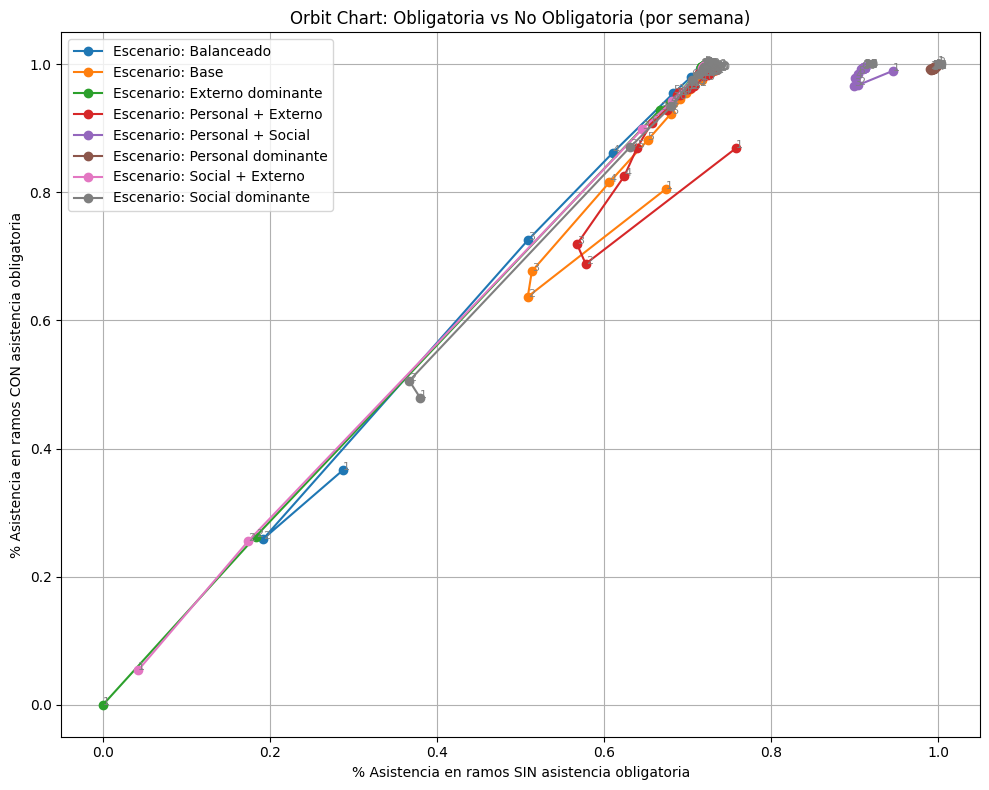

In [40]:
# Orbit Chart: Asistencia obligatoria vs no obligatoria por semana
plt.figure(figsize=(10, 8))

escenarios = df_semanal_weight["escenario"].unique()

for escenario in escenarios:
    subset = df_semanal_weight[df_semanal_weight["escenario"] == escenario]
    plt.plot(
        subset["% Asistencia no obligatoria"],
        subset["% Asistencia obligatoria"],
        marker="o",
        label=f"Escenario: {escenario}"
    )
    # Agregar las semanas en los puntos
    for i, row in subset.iterrows():
        plt.text(
            row["% Asistencia no obligatoria"],
            row["% Asistencia obligatoria"],
            str(row["semana"]),
            fontsize=8,
            color="gray"
        )

plt.xlabel("% Asistencia en ramos SIN asistencia obligatoria")
plt.ylabel("% Asistencia en ramos CON asistencia obligatoria")
plt.title("Orbit Chart: Obligatoria vs No Obligatoria (por semana)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Red social

In [41]:
# Escenarios de red para comparar diferentes configuraciones de redes sociales
network_scenarios = [
    {"name": "Red balanceada (Base)",       "k": 4,  "p": 0.3}, 
    {"name": "Red débil",                   "k": 2,  "p": 0.1},
    {"name": "Red local",                   "k": 4,  "p": 0.0},
    {"name": "Red aleatoria",               "k": 4,  "p": 1.0},
    {"name": "Red densa",                   "k": 8,  "p": 0.3},
    {"name": "Red completamente conectada", "k": 49, "p": 0},
]

# Definimos los parámetros base para cada escenario de red
dfs = []
for esc in network_scenarios:
    base_params = {
        "num_students": 50,
        "prob_mandatory": [0.6],
        "personal_weight": [0.5],
        "social_weight": [0.3],
        "external_weight": [0.2],
        "weather_type": ["random"],
        "min_credits": 21,
        "max_credits": 39,
        "network_k": [esc["k"]],
        "network_p": [esc["p"]],
    }
    df = ejecutar_escenario(esc["name"], base_params)
    dfs.append(df)

# Concatenar todos
resultados_comparativos_network = pd.concat(dfs, ignore_index=True)


Ejecutando escenario: Red balanceada (Base)


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Red débil


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Red local


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Red aleatoria


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Red densa


  0%|          | 0/75 [00:00<?, ?it/s]

Ejecutando escenario: Red completamente conectada


  0%|          | 0/75 [00:00<?, ?it/s]

In [42]:
resultados_comparativos_network.head()

RunId  iteration  Step  num_students  prob_mandatory  personal_weight  \
0      0          0     0            50             0.6              0.5   
1      0          0     0            50             0.6              0.5   
2      0          0     0            50             0.6              0.5   
3      0          0     0            50             0.6              0.5   
4      0          0     0            50             0.6              0.5   

   social_weight  external_weight weather_type  min_credits  ...  \
0            0.3              0.2       random           21  ...   
1            0.3              0.2       random           21  ...   
2            0.3              0.2       random           21  ...   
3            0.3              0.2       random           21  ...   
4            0.3              0.2       random           21  ...   

   Attendance Rate  Attendance  Reasons Count  Reasons Effect Count  \
0              1.0          50             {}                    {}   
1              1.0          50             {}                    {}   
2              1.0          50             {}                    {}   
3              1.0          50             {}                    {}   
4              1.0          50             {}                    {}   

   Motivation Weather AgentID  Attends Class  \
0    0.851279  random       1           True   
1    0.851279  random       2           True   
2    0.851279  random       3           True   
3    0.851279  random       4           True   
4    0.851279  random       5           True   

                                           Week Data              Escenario  
0  [{'week': 1, 'days': [{'day': 'mon', 'attended...  Red balanceada (Base)  
1  [{'week': 1, 'days': [{'day': 'mon', 'attended...  Red balanceada (Base)  
2  [{'week': 1, 'days': [{'day': 'mon', 'attended...  Red balanceada (Base)  
3  [{'week': 1, 'days': [{'day': 'mon', 'attended...  Red balanceada (Base)  
4  [{'week': 1, 'days': [{'day': 'mon', 'attended...  Red balanceada (Base)  

[5 rows x 23 columns]

In [43]:
# Procesar los resultados de los escenarios de red
df_resultados_network = procesar_resultados(resultados_comparativos_network)
df_resultados_network


Escenario  Motivación promedio  Asistencia promedio  \
0    Red aleatoria             0.477162             0.658615   
1    Red aleatoria             0.436874             0.669385   
2    Red aleatoria             0.491336             0.743077   
3    Red aleatoria             0.470785             0.675385   
4    Red aleatoria             0.478853             0.687077   
..             ...                  ...                  ...   
445      Red local             0.453411             0.679077   
446      Red local             0.488366             0.713231   
447      Red local             0.471044             0.717385   
448      Red local             0.518106             0.761385   
449      Red local             0.509264             0.734769   

     Asistencia obligatoria  Asistencia no obligatoria  % Asistencia total  \
0                  0.913846                   0.640769            0.767716   
1                  0.975385                   0.756154            0.793848   
2                  0.966923                   0.818462            0.853011   
3                  0.978462                   0.837692            0.820710   
4                  0.934615                   0.863077            0.801043   
..                      ...                        ...                 ...   
445                0.953077                   0.798462            0.778789   
446                0.984615                   0.759231            0.859610   
447                0.966923                   0.784615            0.818457   
448                0.955385                   0.863846            0.847266   
449                0.963846                   0.766154            0.817843   

     % Asistencia obligatoria  % Asistencia no obligatoria  Créditos promedio  \
0                    0.878424                     0.503599              31.44   
1                    0.931217                     0.564280              31.38   
2                    0.921205                     0.664905              34.20   
3                    0.936240                     0.645857              31.68   
4                    0.900494                     0.677280              33.36   
..                        ...                          ...                ...   
445                  0.913702                     0.541865              31.98   
446                  0.942023                     0.578985              32.22   
447                  0.929552                     0.608862              32.76   
448                  0.924167                     0.731113              33.54   
449                  0.927373                     0.586784              33.00   

     Ramos obligatorios  Ramos electivos  \
0                  3.00             1.98   
1                  3.04             2.00   
2                  3.24             2.12   
3                  2.96             1.96   
4                  2.98             2.10   
..                  ...              ...   
445                3.02             1.98   
446                3.16             1.62   
447                3.12             1.92   
448                3.28             1.72   
449                2.98             1.72   

                                               Razones  \
0    {'Desgaste': 0.07376068376068376, 'Desmotivaci...   
1    {'Desgaste': 0.014564102564102566, 'Desmotivac...   
2    {'Desgaste': 0.08043939393939394, 'Desmotivaci...   
3    {'Desgaste': 0.02410500610500611, 'Desmotivaci...   
4    {'Desgaste': 0.048040404040404036, 'Desmotivac...   
..                                                 ...   
445  {'Desgaste': 0.042222222222222223, 'Desmotivac...   
446  {'Desgaste': 0.06894444444444445, 'Desmotivaci...   
447  {'Desgaste': 0.08120768120768121, 'Desmotivaci...   
448  {'Desgaste': 0.1406915306915307, 'Desmotivació...   
449  {'Desgaste': 0.09316666666666666, 'Desmotivaci...   

                                    Razones dominantes  
0    {'Personal': 0.0017134803181314809, 'Socia

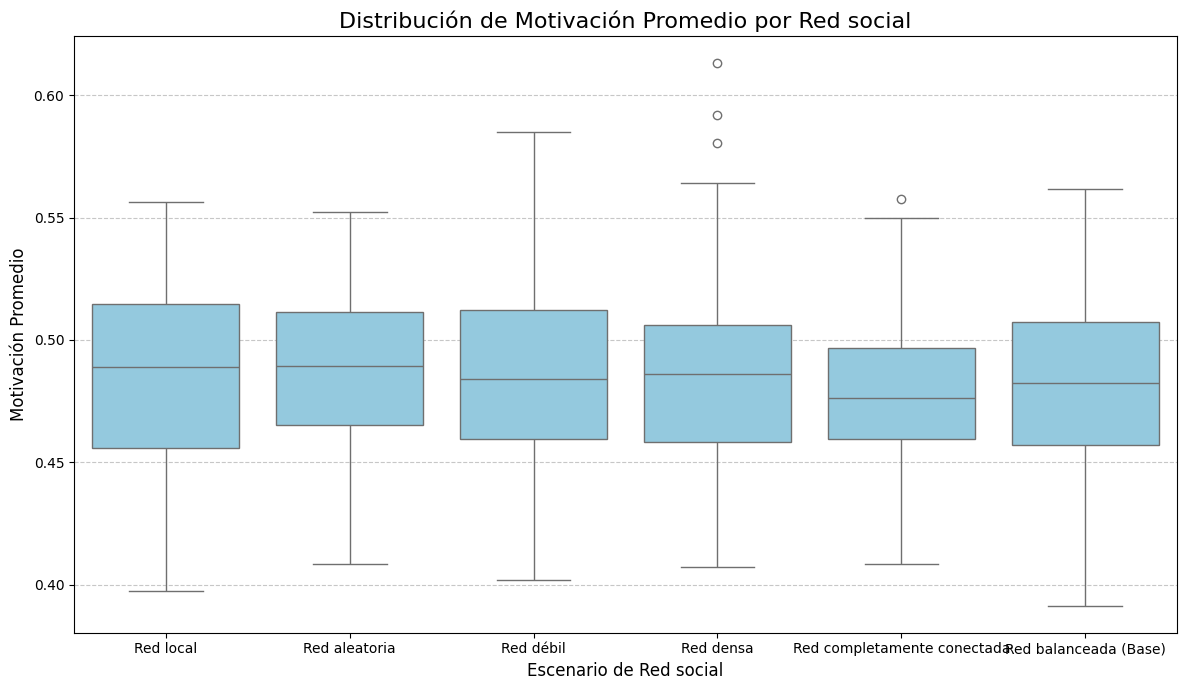

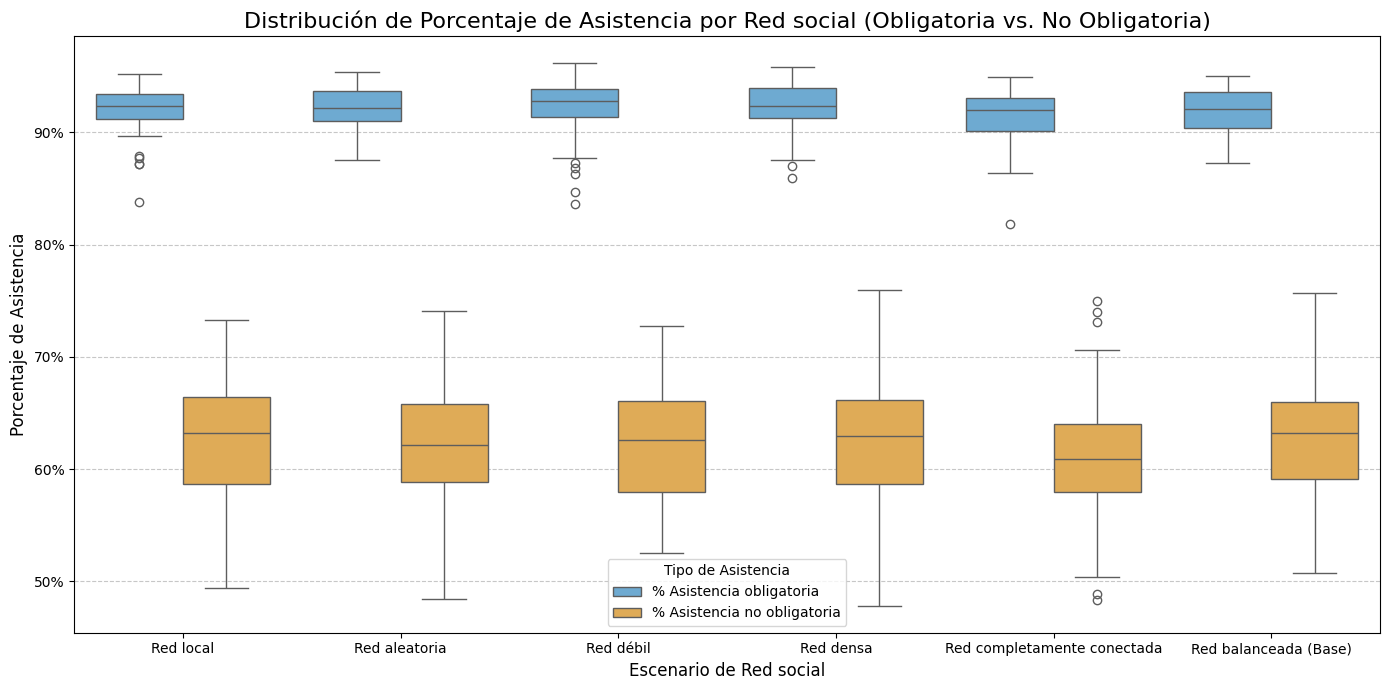

In [ ]:
# Gráfico de cajas para comparar motivación y asistencia por escenario de red social
orden_network = ["Red local", "Red aleatoria", "Red débil", "Red densa", "Red completamente conectada", "Red balanceada (Base)"]

# Gráfico 1: Motivación Promedio por tipo de clima  
plt.figure(figsize=(12, 7)) 

sns.boxplot(x="Escenario", y="Motivación promedio", data=df_resultados_network, order=orden_network, color="#87CEEB")

plt.title("Distribución de Motivación Promedio por Red social", fontsize=16)
plt.xlabel("Escenario de Red social", fontsize=12)
plt.ylabel("Motivación Promedio", fontsize=12)
#plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show() 

# Gráfico 2: Asistencia Obligatoria vs. No Obligatoria por Carga Académica 

df_asistencia_melted = df_resultados_network.melt(
    id_vars=['Escenario'],
    value_vars=['% Asistencia obligatoria', '% Asistencia no obligatoria'],
    var_name='Tipo de Asistencia',
    value_name='Porcentaje de Asistencia'
)

# Definir colores para los tipos de asistencia
colors_asistencia = {
    '% Asistencia obligatoria': '#5DADE2',
    '% Asistencia no obligatoria': '#F5B041'
}

plt.figure(figsize=(14, 7)) 

ax = sns.boxplot(
    x="Escenario",
    y="Porcentaje de Asistencia",
    hue="Tipo de Asistencia",
    data=df_asistencia_melted,
    order=orden_network,
    palette=colors_asistencia
)


plt.title("Distribución de Porcentaje de Asistencia por Red social (Obligatoria vs. No Obligatoria)", fontsize=16)
plt.xlabel("Escenario de Red social", fontsize=12)
plt.ylabel("Porcentaje de Asistencia", fontsize=12)
#plt.xticks(rotation=45, ha='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0)) 
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.legend(title="Tipo de Asistencia") 
plt.tight_layout()
plt.show()


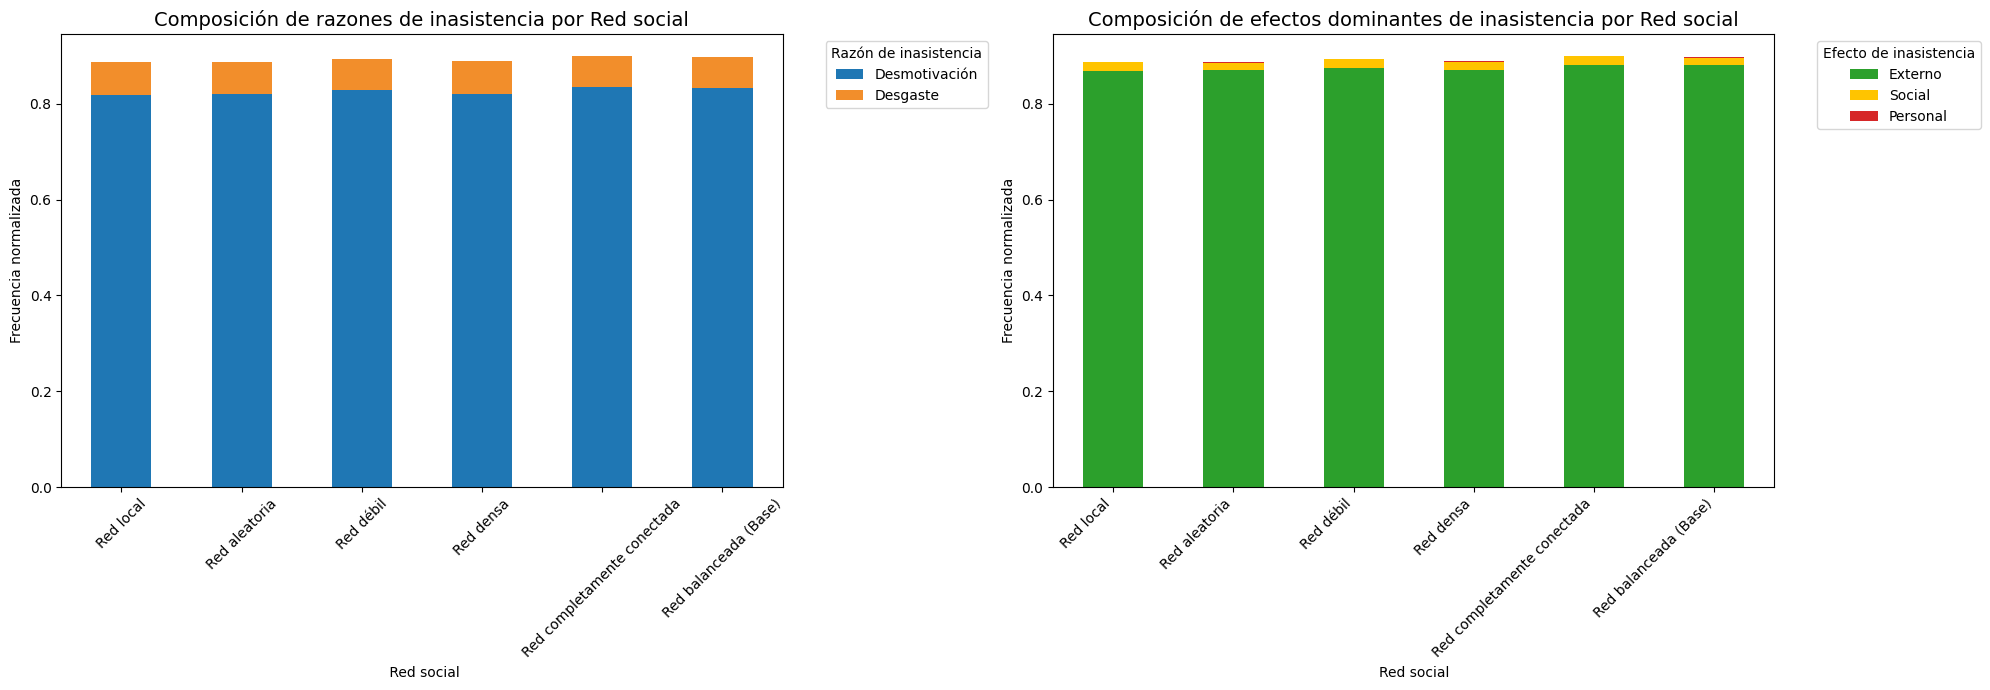

In [104]:
# Expandimos las razones a columnas
df_razones = df_resultados_network[["Escenario", "Razones"]].copy()
razones_expandido = df_razones["Razones"].apply(pd.Series)
df_razones_expandido = pd.concat([df_razones["Escenario"], razones_expandido], axis=1)

# Agrupar por network y sacar promedio por razón
df_reasons_avg = df_razones_expandido.groupby("Escenario").mean().T

orden_network = ["Red local", "Red aleatoria", "Red débil", "Red densa", "Red completamente conectada", "Red balanceada (Base)"]
df_reasons_avg = df_reasons_avg[orden_network if all(c in df_reasons_avg.columns for c in orden_network) else df_reasons_avg.columns]

df_reasons_effect = df_resultados_network[["Escenario", "Razones dominantes"]].copy()
reasons_effect_expandido = df_reasons_effect["Razones dominantes"].apply(pd.Series)
df_reasons_effect_expandido = pd.concat([df_reasons_effect["Escenario"], reasons_effect_expandido], axis=1)
df_reasons_effect_avg = df_reasons_effect_expandido.groupby("Escenario").mean().fillna(0).T

clim_orden_reasons_effect = [c for c in orden_network if c in df_reasons_effect_avg.columns]
df_reasons_effect_avg = df_reasons_effect_avg[clim_orden_reasons_effect]

# Reordenar razones promedio (de mayor a menor para cada escenario)
df_reasons_avg = df_reasons_avg.sort_values(by=df_reasons_avg.columns.tolist(), ascending=False)

# Reordenar efectos promedio (también de mayor a menor)
df_reasons_effect_avg = df_reasons_effect_avg.sort_values(by=df_reasons_effect_avg.columns.tolist(), ascending=False)


# Crear gráfico de barras apiladas
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

colors_for_reasons = ['#1f77b4','#F28E2B']
df_reasons_avg.T.plot(kind="bar", stacked=True, ax=axes[0], color=colors_for_reasons)
axes[0].set_title("Composición de razones de inasistencia por Red social", fontsize=14)
axes[0].set_ylabel("Frecuencia normalizada")
axes[0].set_xlabel(" Red social")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].legend(title="Razón de inasistencia", bbox_to_anchor=(1.05, 1), loc='upper left')

colors_for_effects = [ '#2CA02C', "#FFC400", '#d62728']
df_reasons_effect_avg.T.plot(kind="bar", stacked=True, ax=axes[1], color=colors_for_effects)
axes[1].set_title("Composición de efectos dominantes de inasistencia por Red social", fontsize=14)
axes[1].set_ylabel("Frecuencia normalizada")
axes[1].set_xlabel("Red social")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].legend(title="Efecto de inasistencia", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()


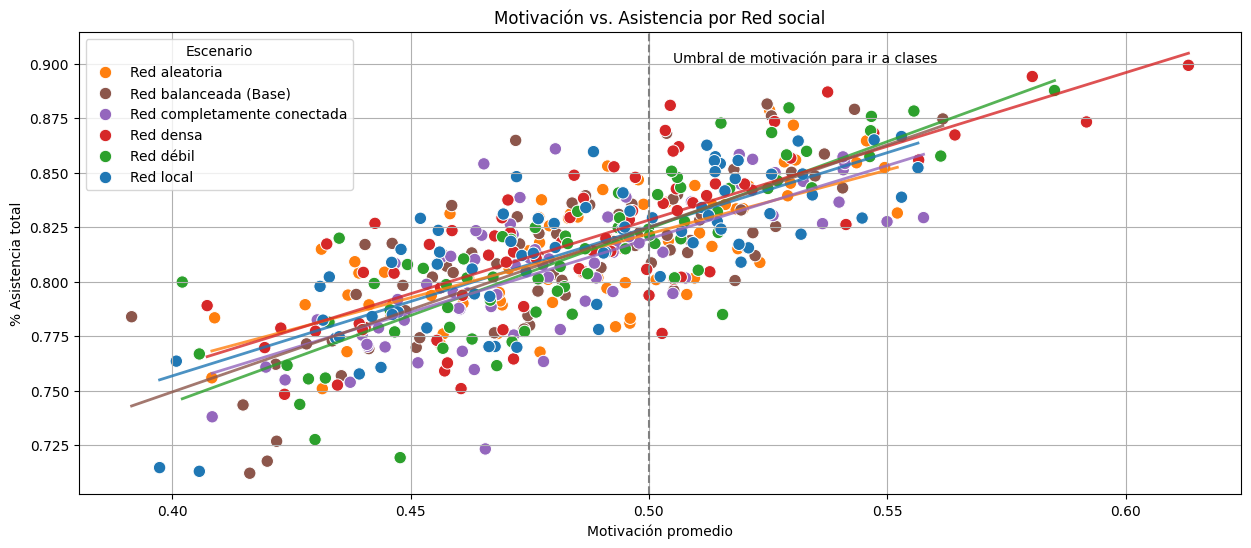

In [ ]:
# Gráfico de dispersión de motivación promedio vs asistencia total por escenario de red social
plt.figure(figsize=(15, 6))

colores_escenarios = sns.color_palette("tab10", n_colors=len(orden_network))
mapa_colores = dict(zip(orden_network, colores_escenarios))

sns.scatterplot(
    x="Motivación promedio",
    y="% Asistencia total",
    hue="Escenario",
    data=df_resultados_network,
    s=80,
    palette=mapa_colores,
)

for i, escenario in enumerate(orden_network):
    # Filtra los datos para el escenario actual
    df_temp = df_resultados_network[df_resultados_network["Escenario"] == escenario]

    sns.regplot(
        x="Motivación promedio",
        y="% Asistencia total",
        data=df_temp,
        scatter=False,
        color=mapa_colores[escenario],
        line_kws={'linewidth': 2, 'alpha': 0.8},
        ci=None
    )

# Línea vertical en el umbral de motivación 0.5
plt.axvline(x=0.5, color="gray", linestyle="--", linewidth=1.5)
plt.text(0.505, plt.ylim()[1] * 0.985, "Umbral de motivación para ir a clases", color="black")

plt.title("Motivación vs. Asistencia por Red social")
plt.xlabel("Motivación promedio")
plt.ylabel("% Asistencia total")
plt.grid(True)
plt.legend(title="Escenario")
plt.show()


In [142]:
# Procesar los resultados para el gráfico de Orbit Chart semanal
df_semanal_network_detalle, df_semanal_network = procesar_resultados_para_orbit_chart(resultados_comparativos_network)

In [143]:
df_semanal_network_detalle

escenario  run  semana  motivacion  asistencia  % obligatoria  \
0      Red aleatoria    0       1    0.710133    0.870667       0.800000   
1      Red aleatoria    0       2    0.603285    0.778667       0.727660   
2      Red aleatoria    0       3    0.429071    0.370667       0.353191   
3      Red aleatoria    0       4    0.431596    0.472667       0.446809   
4      Red aleatoria    0       5    0.382516    0.577333       0.544681   
...              ...  ...     ...         ...         ...            ...   
11695      Red local   74      22    0.533432    0.810333       0.779592   
11696      Red local   74      23    0.421128    0.806333       0.775510   
11697      Red local   74      24    0.540209    0.806333       0.775510   
11698      Red local   74      25    0.521608    0.810333       0.779592   
11699      Red local   74      26    0.457656    0.802333       0.771429   

       % no obligatoria  
0              0.735000  
1              0.635000  
2              0.320000  
3              0.390000  
4              0.470000  
...                 ...  
11695          0.740909  
11696          0.731818  
11697          0.731818  
11698          0.736364  
11699          0.727273  

[11700 rows x 7 columns]

In [144]:
df_semanal_network

escenario  semana  motivacion  asistencia  % obligatoria  \
0    Red aleatoria       1    0.600833    0.712818       0.651203   
1    Red aleatoria       2    0.504225    0.552218       0.506417   
2    Red aleatoria       3    0.496318    0.619933       0.572561   
3    Red aleatoria       4    0.484800    0.682351       0.629543   
4    Red aleatoria       5    0.474239    0.710520       0.656830   
..             ...     ...         ...         ...            ...   
151      Red local      22    0.482412    0.811400       0.749121   
152      Red local      23    0.487768    0.816556       0.753620   
153      Red local      24    0.494002    0.816791       0.754068   
154      Red local      25    0.491009    0.815173       0.752461   
155      Red local      26    0.480039    0.814547       0.751701   

     % no obligatoria  
0            0.628092  
1            0.476875  
2            0.542545  
3            0.603814  
4            0.629388  
..                ...  
151          0.718197  
152          0.722942  
153          0.723691  
154          0.722083  
155          0.720598  

[156 rows x 6 columns]

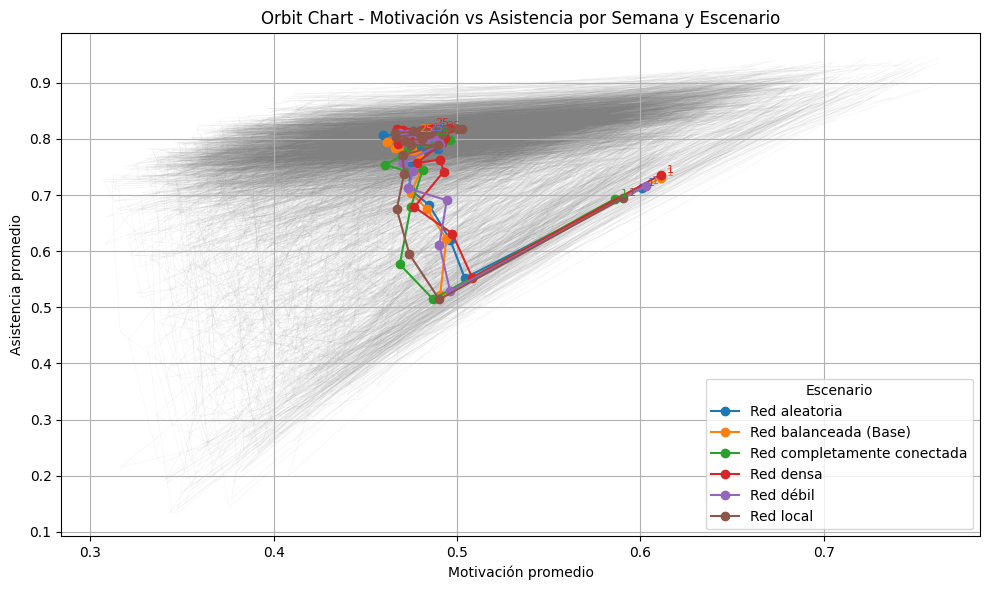

In [ ]:
# Gráfico Orbit Chart para los resultados por semana y escenario
plt.figure(figsize=(10, 6))

# Paleta de colores por escenario
palette = sns.color_palette("tab10", len(df_semanal_network["escenario"].unique()))

for i, (escenario, grupo) in enumerate(df_semanal_network.groupby("escenario")):
    df_escenario_detalle = df_semanal_network_detalle[df_semanal_network_detalle["escenario"] == escenario]
    for run_id in df_escenario_detalle["run"].unique(): 
        serie_individual = df_escenario_detalle[df_escenario_detalle["run"] == run_id].sort_values("semana")
        plt.plot(
            serie_individual["motivacion"], serie_individual["asistencia"],
            color="gray", alpha=0.08, linewidth=0.5, zorder=0 
        )
# Orbit chart: línea por escenario
for i, (escenario, grupo) in enumerate(df_semanal_network.groupby("escenario")):
    grupo_sorted = grupo.sort_values("semana")
    
    plt.plot(grupo_sorted["motivacion"], grupo_sorted["asistencia"],
             marker="o", label=escenario, color=palette[i])

    # Agregar número de semana en cada punto para ver la semana correspondiente
    for _, row in grupo_sorted.iterrows():
        if row["semana"] in [1, 25]:
            plt.text(row["motivacion"] + 0.003, row["asistencia"] + 0.003,
                    str(row["semana"]), fontsize=8, color=palette[i])

plt.title("Orbit Chart - Motivación vs Asistencia por Semana y Escenario")
plt.xlabel("Motivación promedio")
plt.ylabel("Asistencia promedio")
plt.legend(title="Escenario")
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.autoscale(enable=True, axis='both', tight=False)
plt.tight_layout()
plt.show()


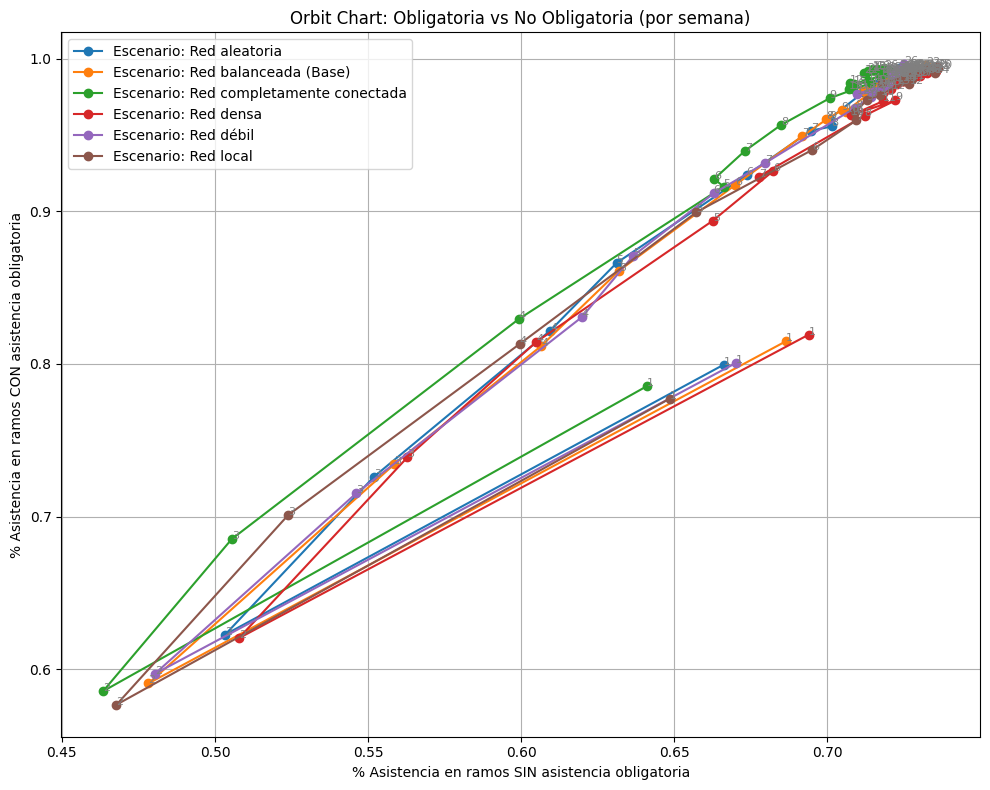

In [49]:
# Orbit Chart: Asistencia obligatoria vs no obligatoria por semana
plt.figure(figsize=(10, 8))

escenarios = df_semanal_network["escenario"].unique()

for escenario in escenarios:
    subset = df_semanal_network[df_semanal_network["escenario"] == escenario]
    plt.plot(
        subset["% Asistencia no obligatoria"],
        subset["% Asistencia obligatoria"],
        marker="o",
        label=f"Escenario: {escenario}"
    )
    # Agregar las semanas en los puntos
    for i, row in subset.iterrows():
        plt.text(
            row["% Asistencia no obligatoria"],
            row["% Asistencia obligatoria"],
            str(row["semana"]),
            fontsize=8,
            color="gray"
        )

plt.xlabel("% Asistencia en ramos SIN asistencia obligatoria")
plt.ylabel("% Asistencia en ramos CON asistencia obligatoria")
plt.title("Orbit Chart: Obligatoria vs No Obligatoria (por semana)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()